# In this notebook i show how to use decision trees for ARC Challenge. 



In this notebook i apply the decision tree approach on the evaluation set and provide some details about this approach. The challenges of ARC Challenge:

1. The tasks have variable sizes (ranging from 2x2 to 30x30).
2. Each task has very few samples (on average around 2). So, supervised learning approaches particularly over parameterised neural networks are likely to overfit.
3. It's not trivial to augment data to generate new samples. Most of the tasks involve abstract reasoning, so commonly used augmentation techniques are not suitable.

The decision tree approach addresses some of the problems. I flatten the input images and use each pixel as an observation. This helps handle variable task sizes (as long as input and output are same size). Flattening the image also has the advantage of giving more number of samples for training. It's also possible to control the number of estimators, tree depth, regularization which can help fight overfitting.

The problem with flattening the image is that it loses global structure information. So, i designed some features that can capture some global information about the environment of pixel like the moore neighbours, no. of unique colors in the row and column etc. For this approach, feature engineering is going to be very important.

# Loading Libraries

In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from xgboost import XGBClassifier
import pdb

# Set Paths

In [2]:
data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

# Plotting functions

In [3]:
def plot_result(test_input, test_prediction,
                input_shape):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Actual Target')
    test_prediction = test_prediction.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Model Prediction')
    plt.tight_layout()
    plt.show()
    
def plot_test(test_prediction, task_name):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(test_prediction, cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(f'Test Prediction {task_name}')
    plt.tight_layout()
    plt.show()

# For flattening 2D numpy arrays

In [4]:
# https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [5]:
sample_sub = pd.read_csv(data_path/'sample_submission.csv')
sample_sub = sample_sub.set_index('output_id')
sample_sub.head()

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...


# Extract neighbourhood Features

In [6]:
def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):

    if cur_row<=0: top = -1
    else: top = color[cur_row-1][cur_col]
        
    if cur_row>=nrows-1: bottom = -1
    else: bottom = color[cur_row+1][cur_col]
        
    if cur_col<=0: left = -1
    else: left = color[cur_row][cur_col-1]
        
    if cur_col>=ncols-1: right = -1
    else: right = color[cur_row][cur_col+1]
        
    return top, bottom, left, right

def get_tl_tr(color, cur_row, cur_col, nrows, ncols):
        
    if cur_row==0:
        top_left = -1
        top_right = -1
    else:
        if cur_col==0: top_left=-1
        else: top_left = color[cur_row-1][cur_col-1]
        if cur_col==ncols-1: top_right=-1
        else: top_right = color[cur_row-1][cur_col+1]   
        
    return top_left, top_right

# Make features for each train sample

In [7]:
def make_features(input_color, nfeat):
    nrows, ncols = input_color.shape
    feat = np.zeros((nrows*ncols,nfeat))
    cur_idx = 0
    for i in range(nrows):
        for j in range(ncols):
            feat[cur_idx,0] = i
            feat[cur_idx,1] = j
            feat[cur_idx,2] = input_color[i][j]
            feat[cur_idx,3:7] = get_moore_neighbours(input_color, i, j, nrows, ncols)
            feat[cur_idx,7:9] = get_tl_tr(input_color, i, j, nrows, ncols)
            feat[cur_idx,9] = len(np.unique(input_color[i,:]))
            feat[cur_idx,10] = len(np.unique(input_color[:,j]))
            feat[cur_idx,11] = (i+j)
            feat[cur_idx,12] = len(np.unique(input_color[i-local_neighb:i+local_neighb,
                                                         j-local_neighb:j+local_neighb]))

            cur_idx += 1
        
    return feat


In [8]:
def features(task, mode='train'):
    num_train_pairs = len(task[mode])
    feat, target = [], []
    
    global local_neighb
    for task_num in range(num_train_pairs):
        input_color = np.array(task[mode][task_num]['input'])
        target_color = task[mode][task_num]['output']
        nrows, ncols = len(task[mode][task_num]['input']), len(task[mode][task_num]['input'][0])

        target_rows, target_cols = len(task[mode][task_num]['output']), len(task[mode][task_num]['output'][0])
        
        if (target_rows!=nrows) or (target_cols!=ncols):
            print('Number of input rows:',nrows,'cols:',ncols)
            print('Number of target rows:',target_rows,'cols:',target_cols)
            not_valid=1
            return None, None, 1

        imsize = nrows*ncols
        offset = imsize*task_num*3 #since we are using three types of aug
        feat.extend(make_features(input_color, nfeat))
        target.extend(np.array(target_color).reshape(-1,))
            
    return np.array(feat), np.array(target), 0

# Training and Prediction

Number of input rows: 2 cols: 2
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/00576224.json

Made predictions for  009d5c81


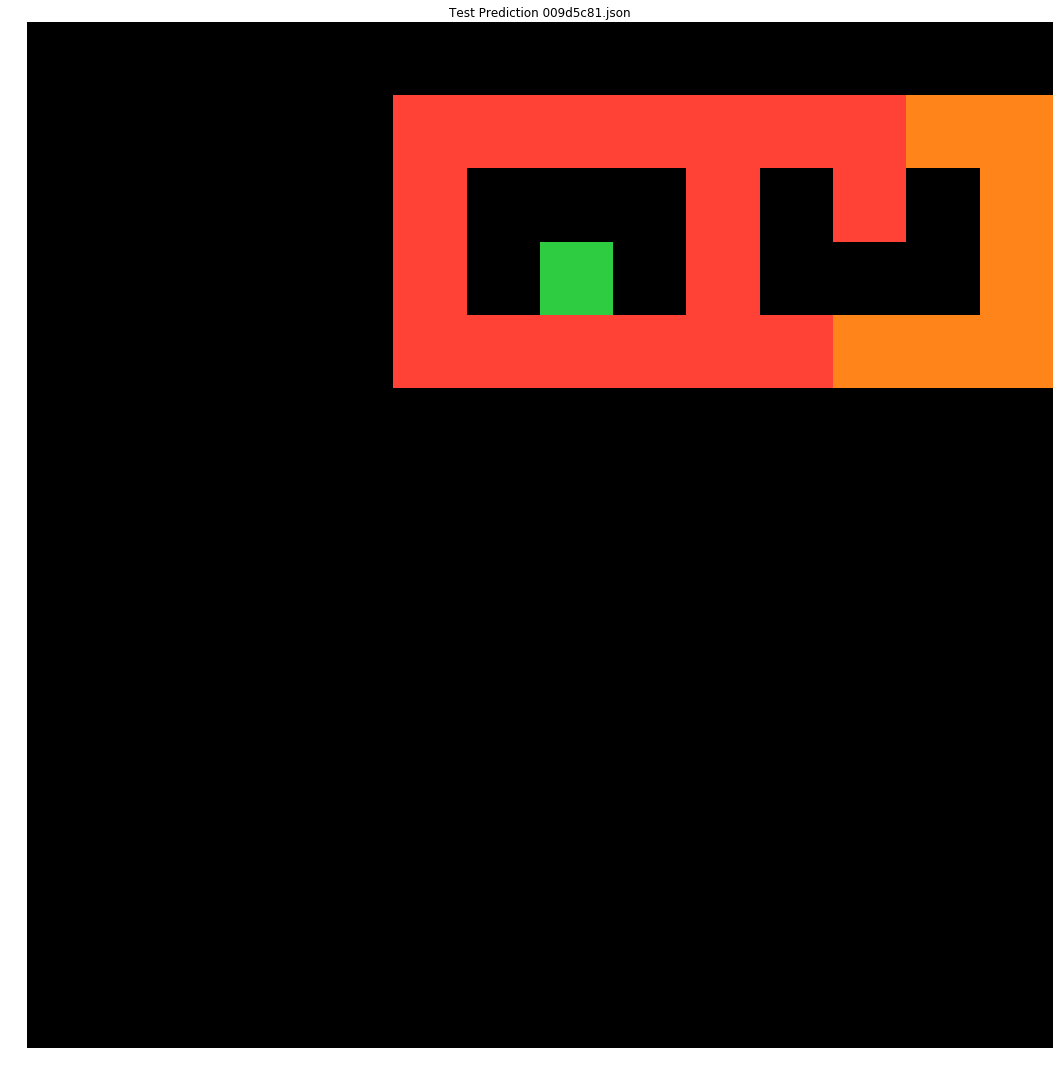

Made predictions for  00dbd492


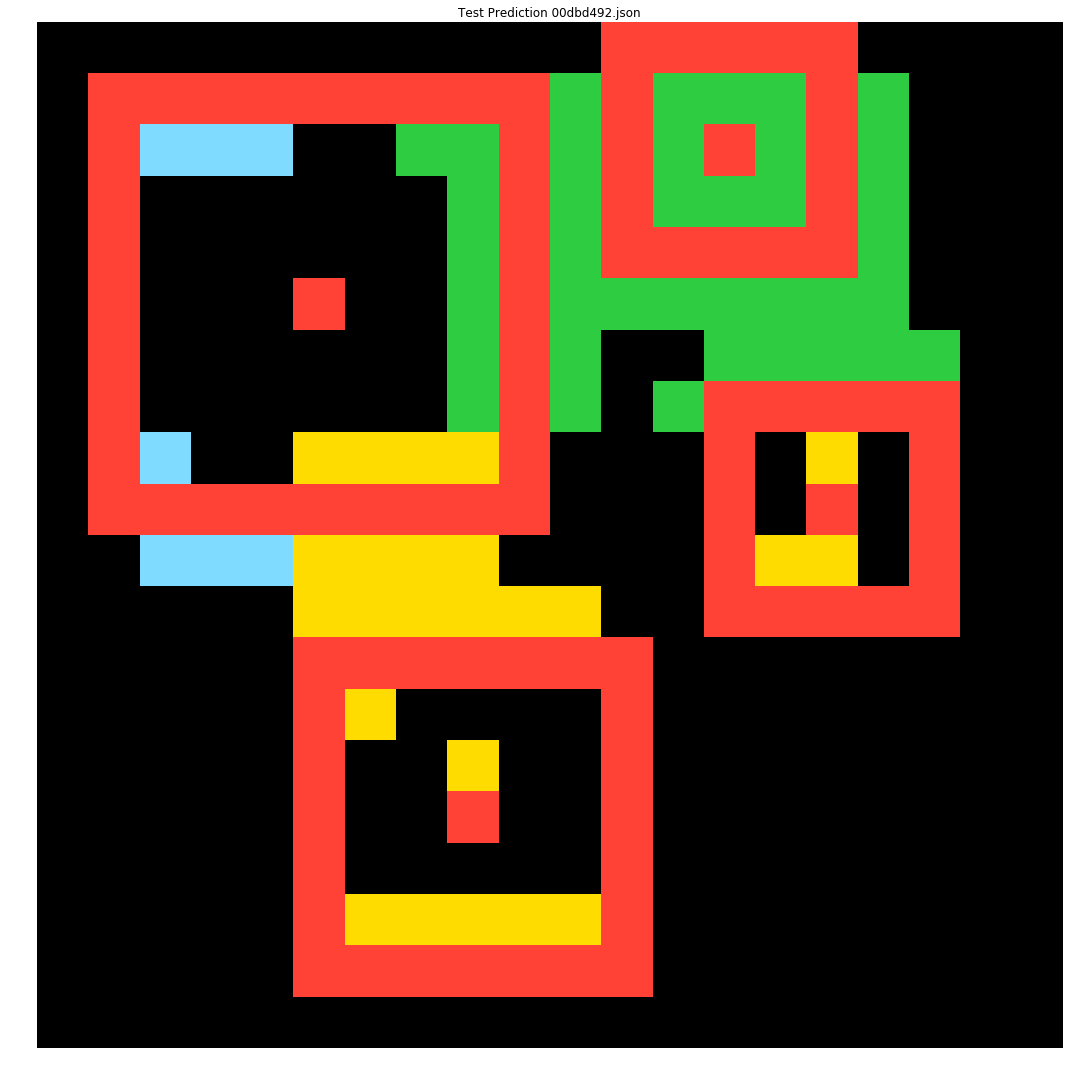

Made predictions for  03560426


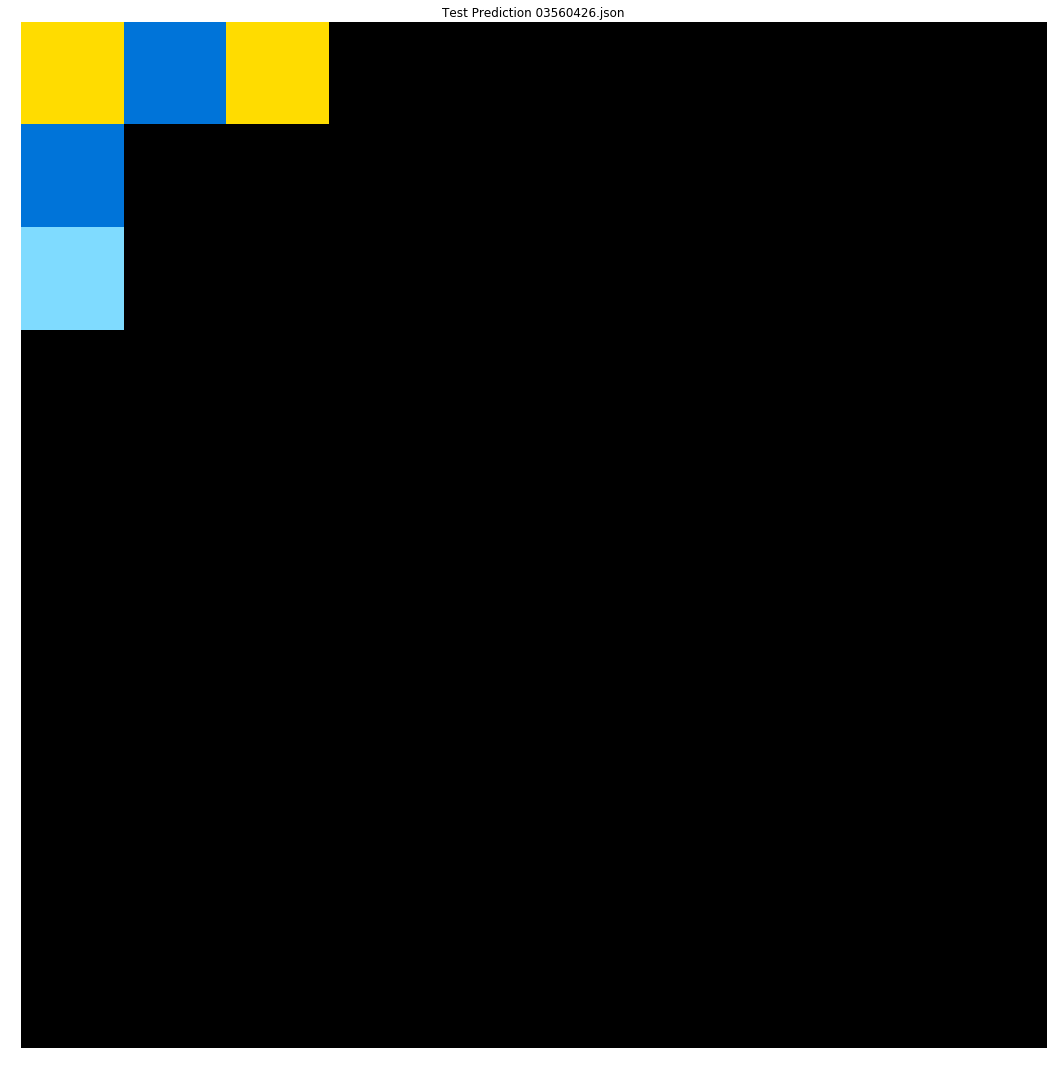

Made predictions for  05a7bcf2


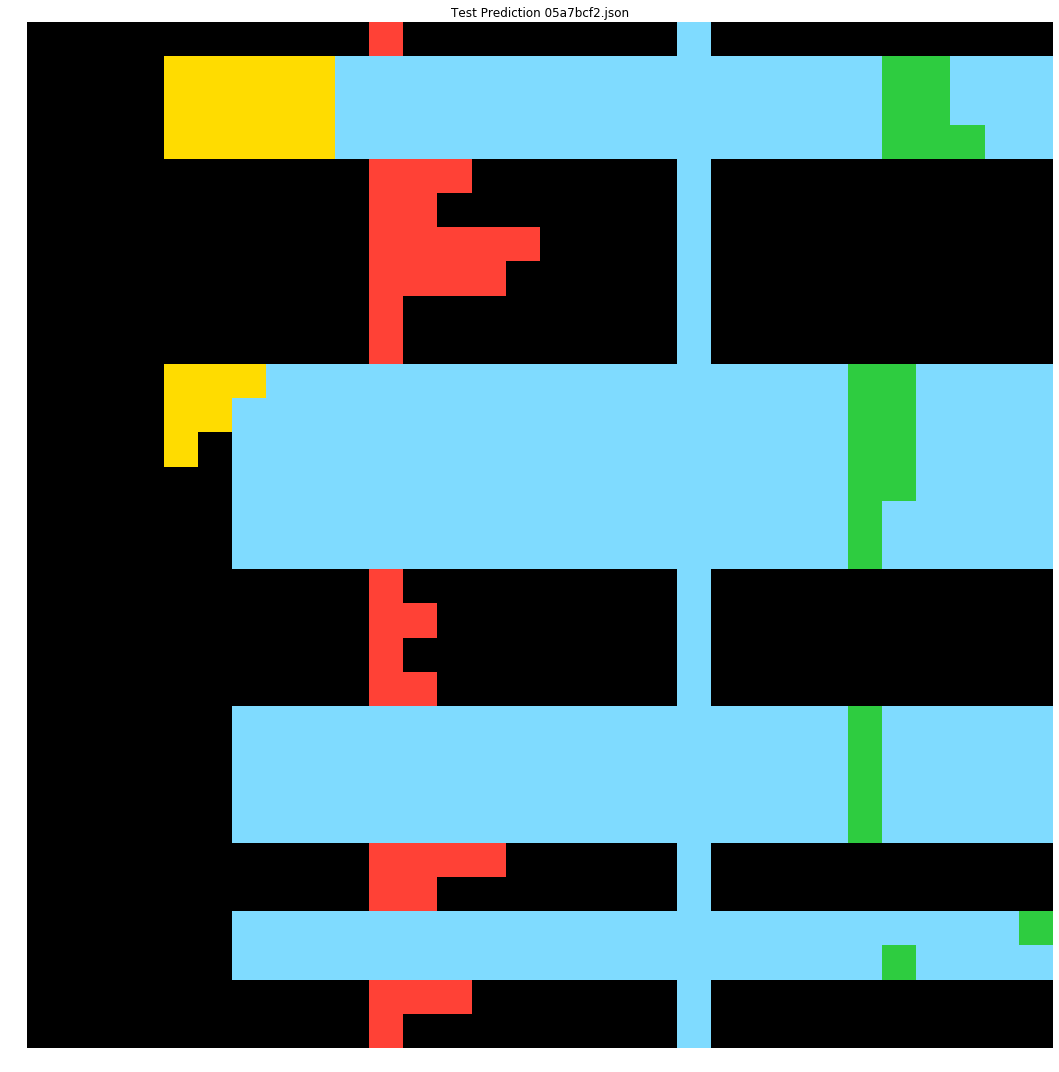

Made predictions for  0607ce86


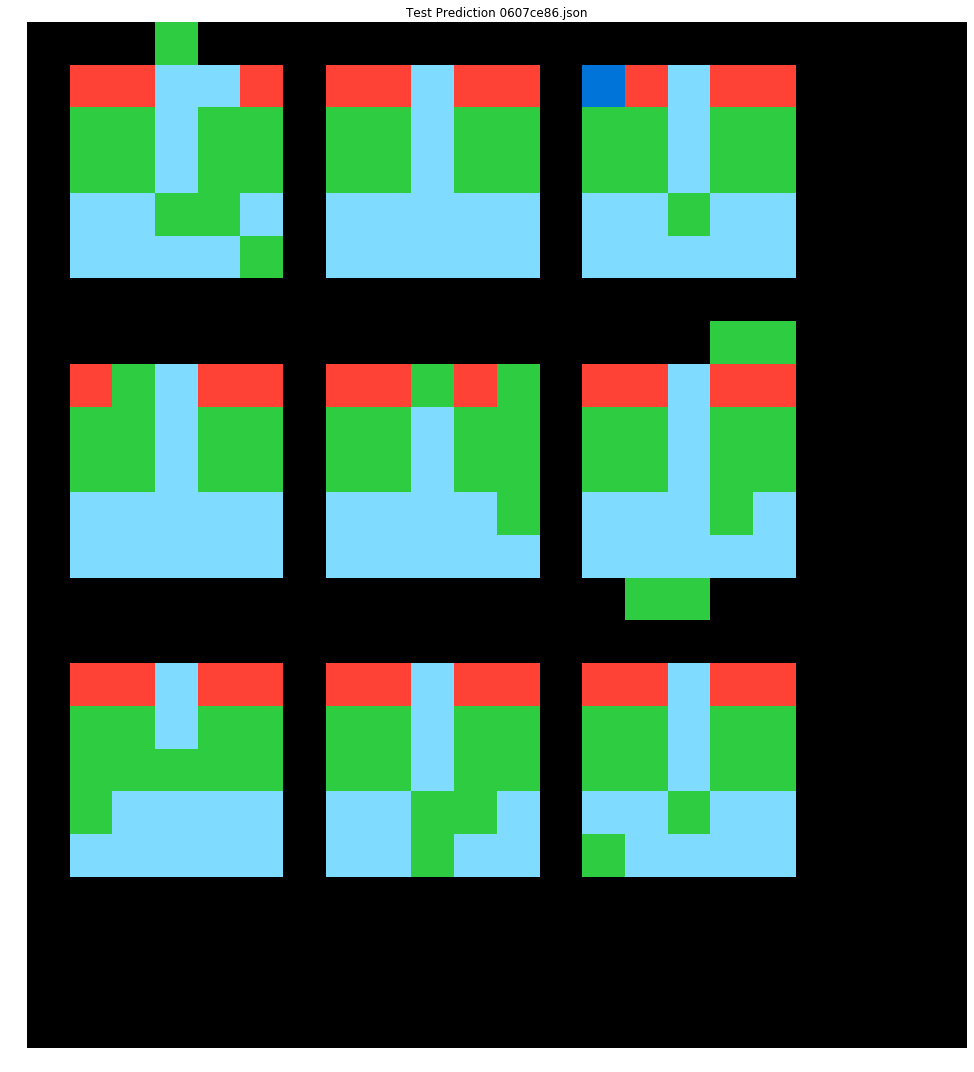

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0692e18c.json

Made predictions for  070dd51e


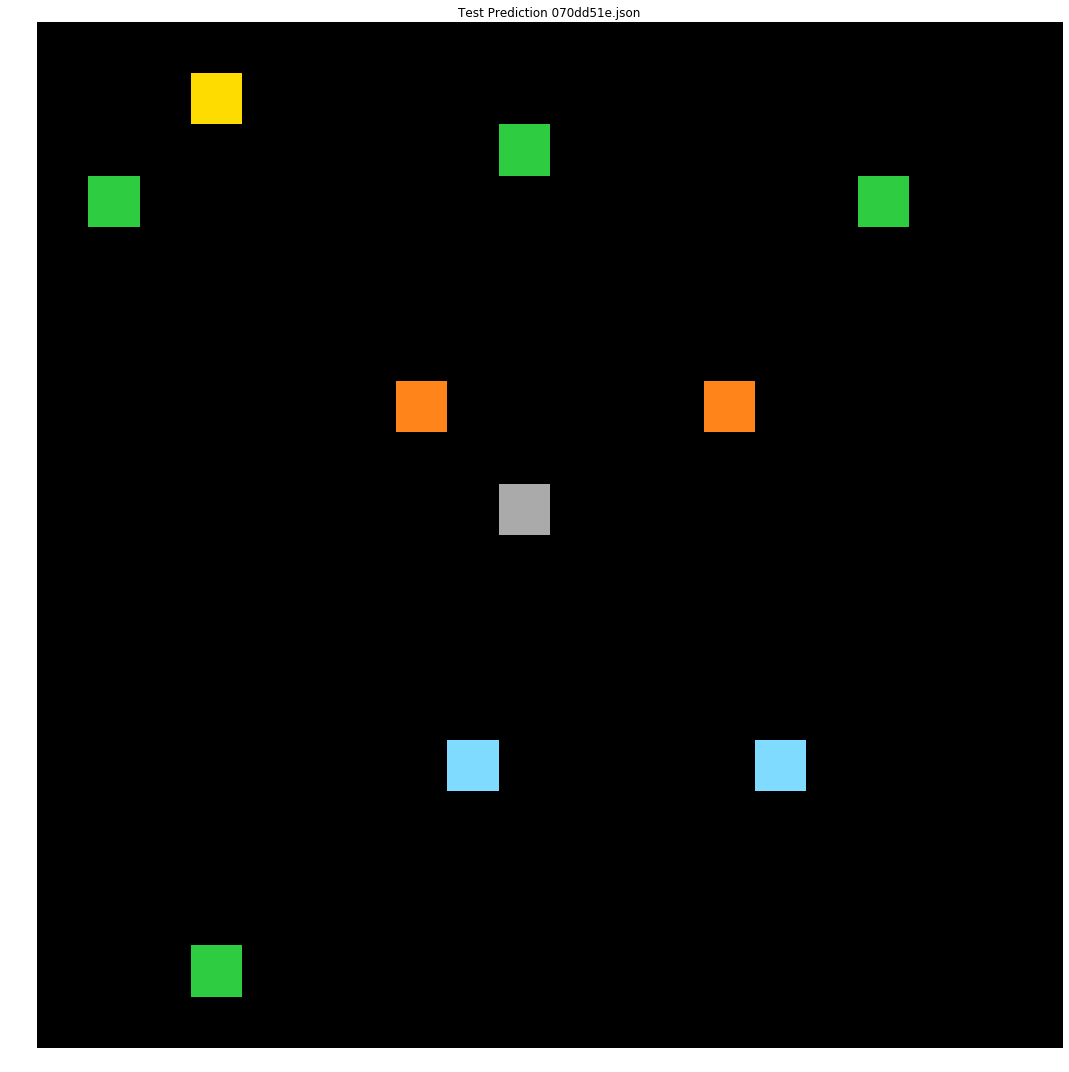

Made predictions for  08573cc6


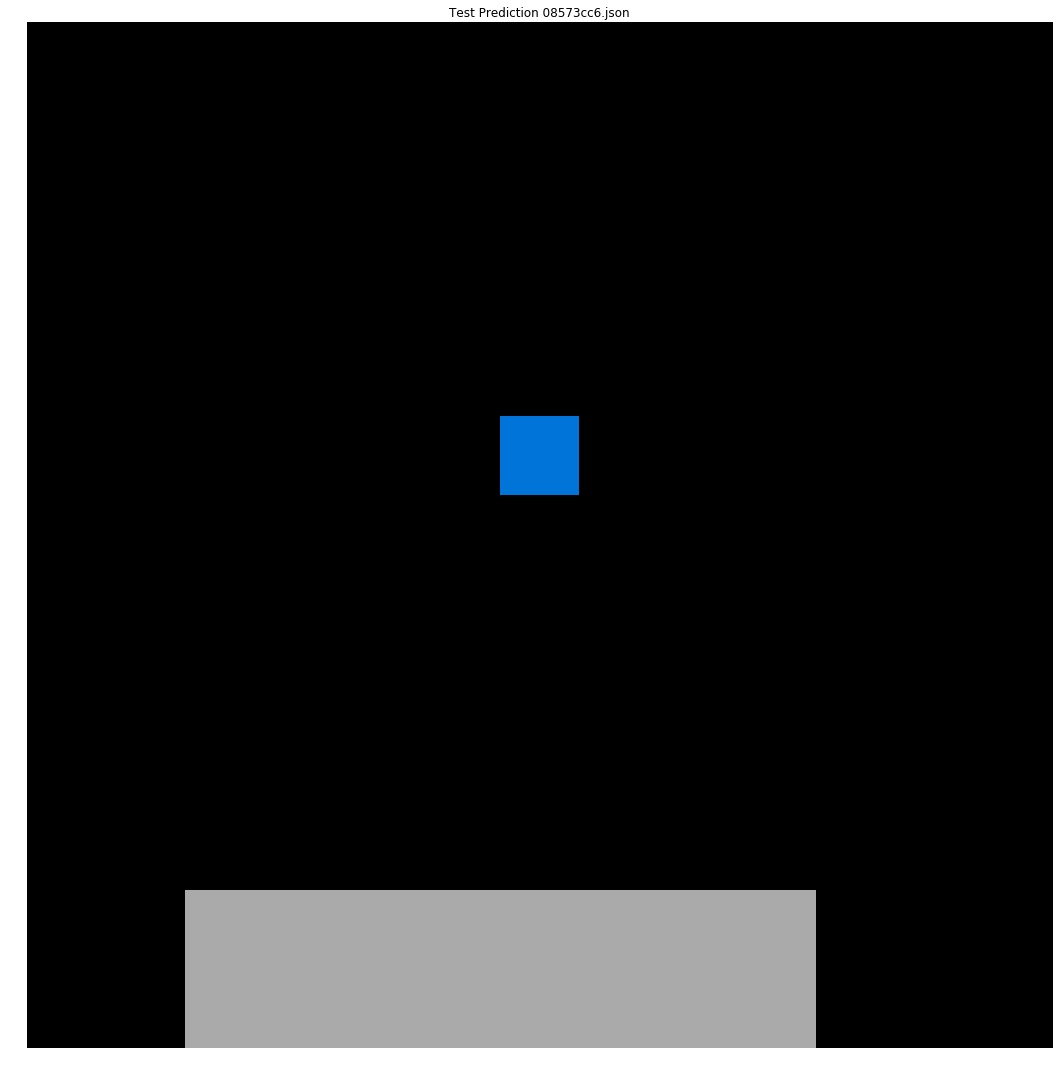

Number of input rows: 30 cols: 30
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0934a4d8.json

Made predictions for  09c534e7


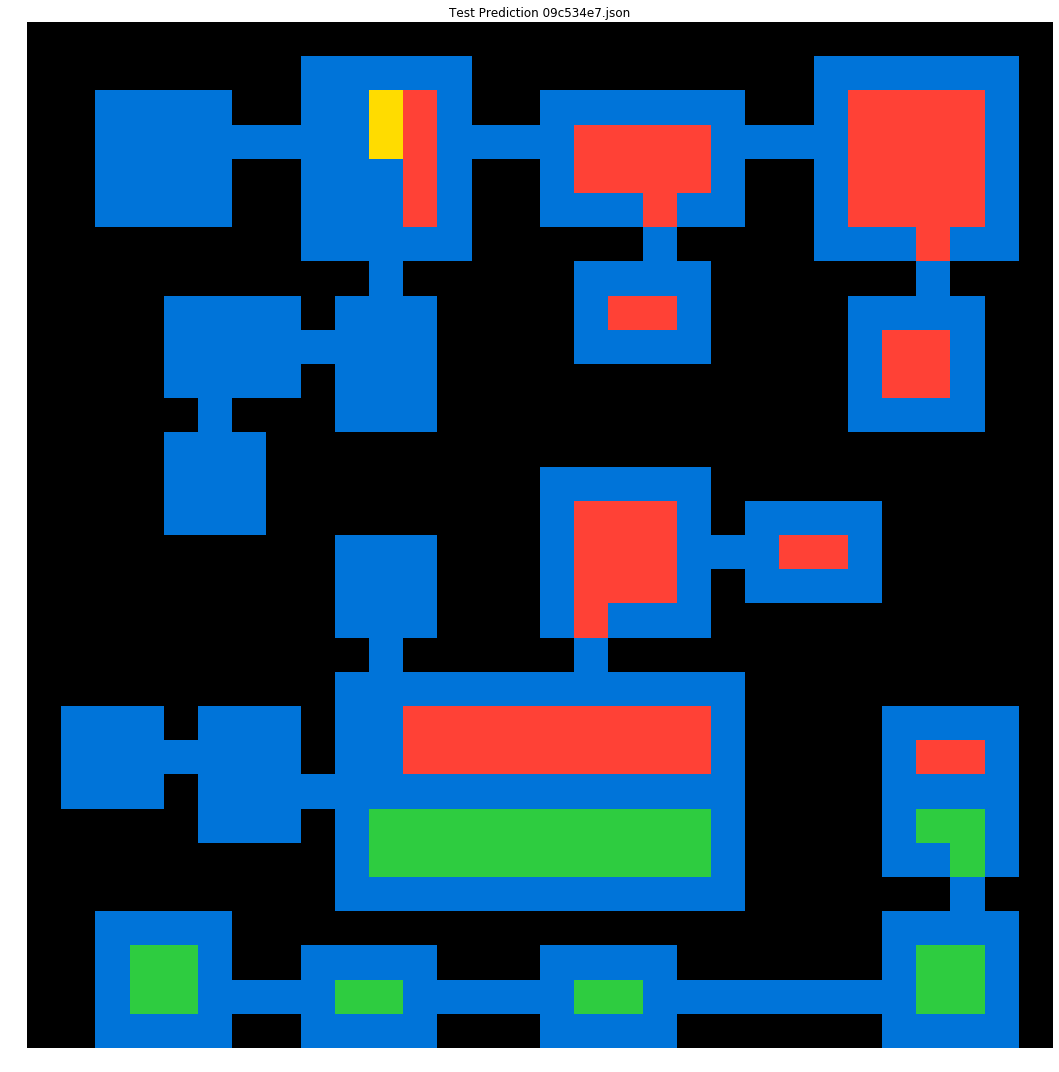

Number of input rows: 30 cols: 30
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0a1d4ef5.json

Made predictions for  0a2355a6


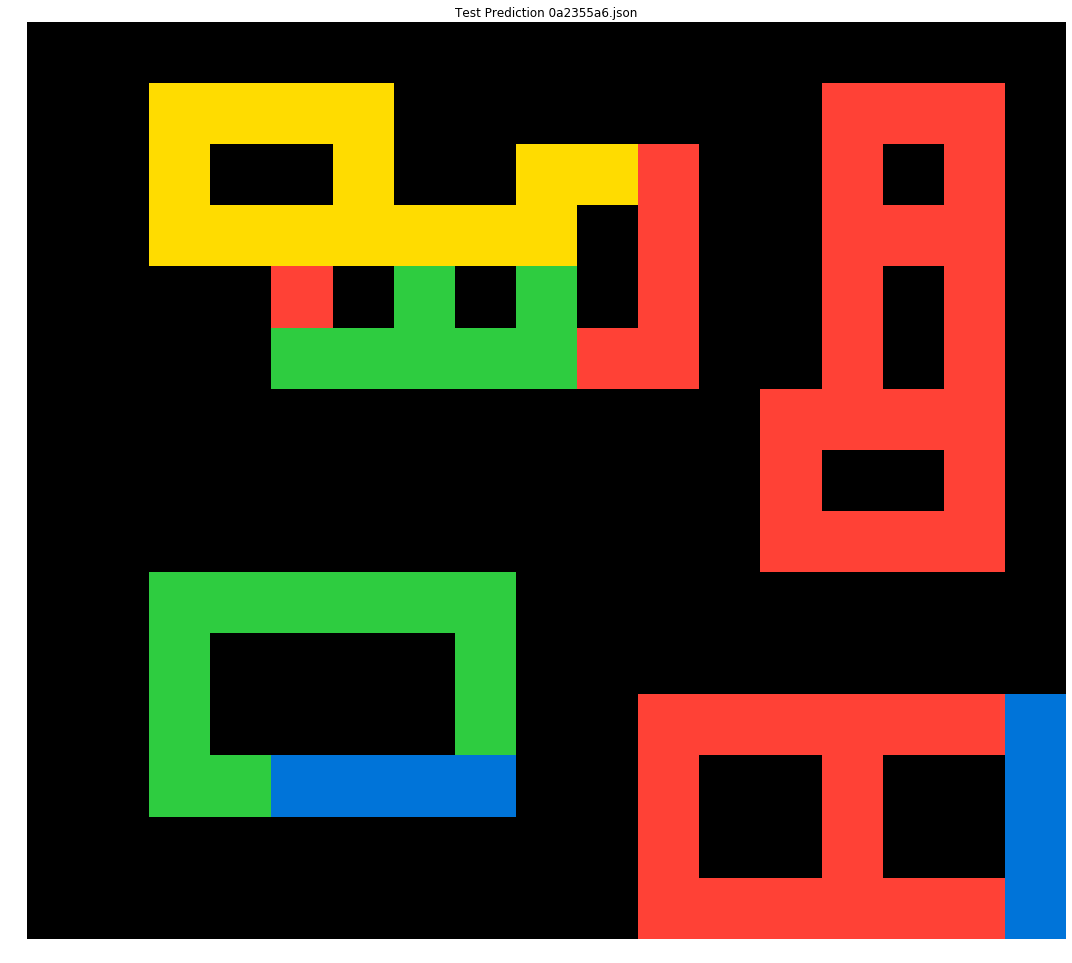

Made predictions for  0b17323b


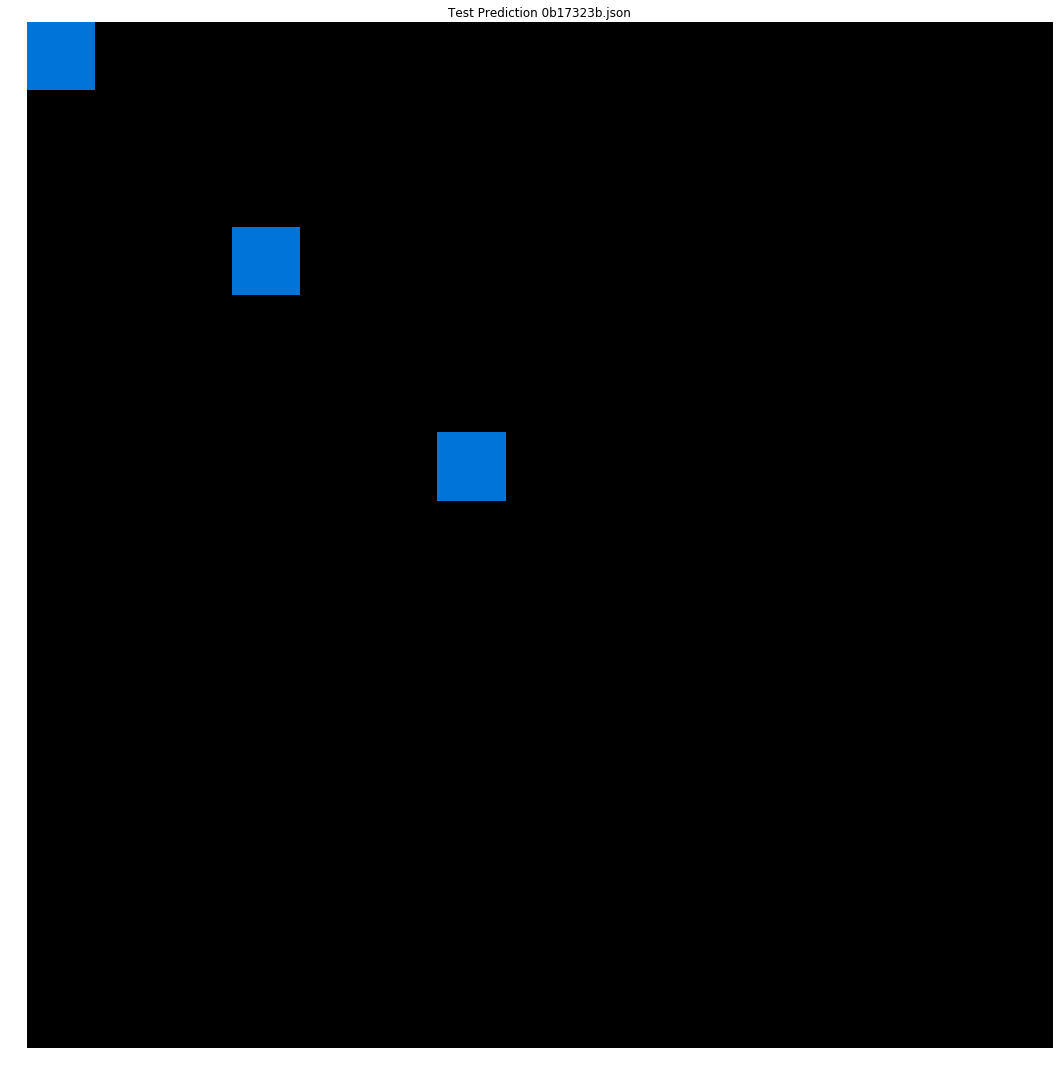

Number of input rows: 12 cols: 13
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0bb8deee.json

Made predictions for  0becf7df


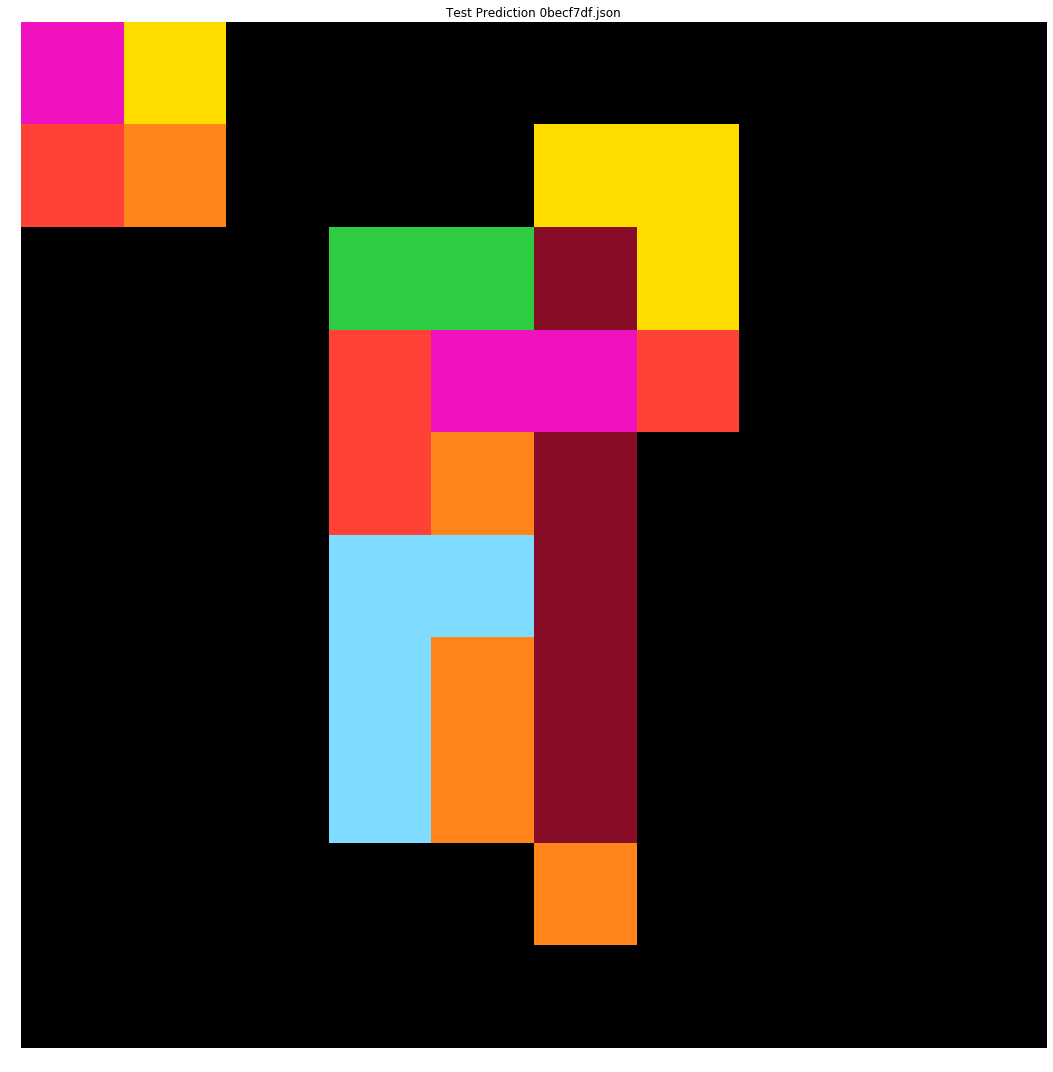

Number of input rows: 3 cols: 4
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0c786b71.json

Number of input rows: 13 cols: 4
Number of target rows: 6 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0c9aba6e.json

Made predictions for  0d87d2a6


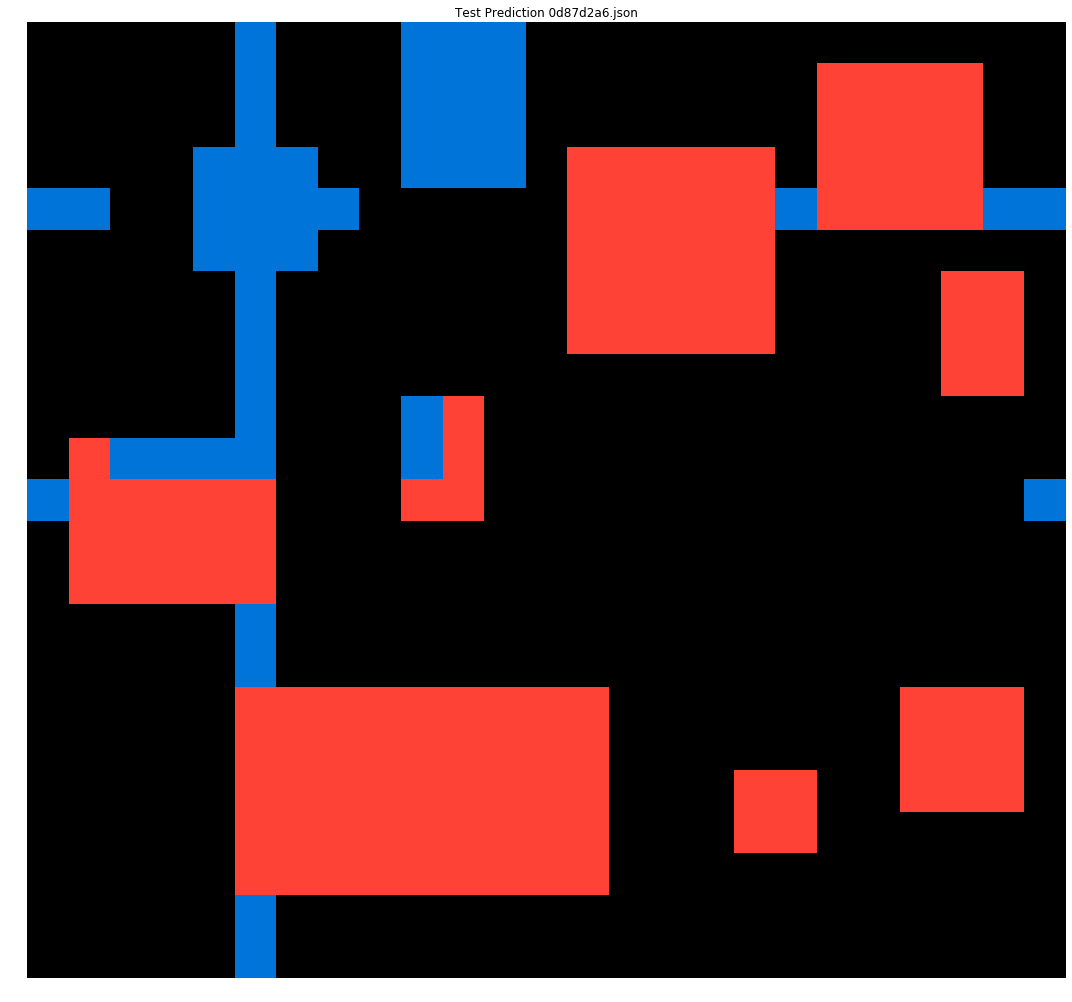

Made predictions for  0e671a1a


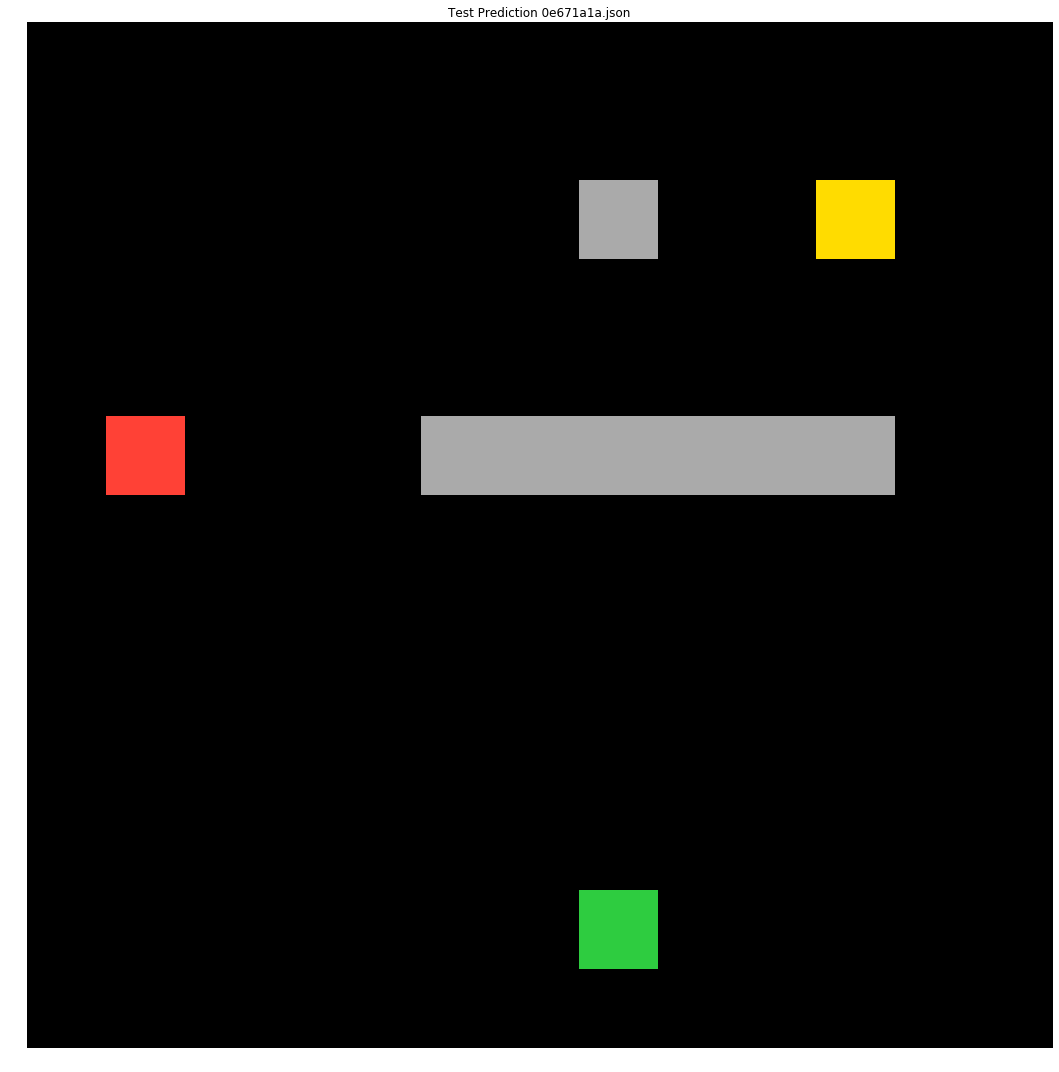

Made predictions for  0f63c0b9


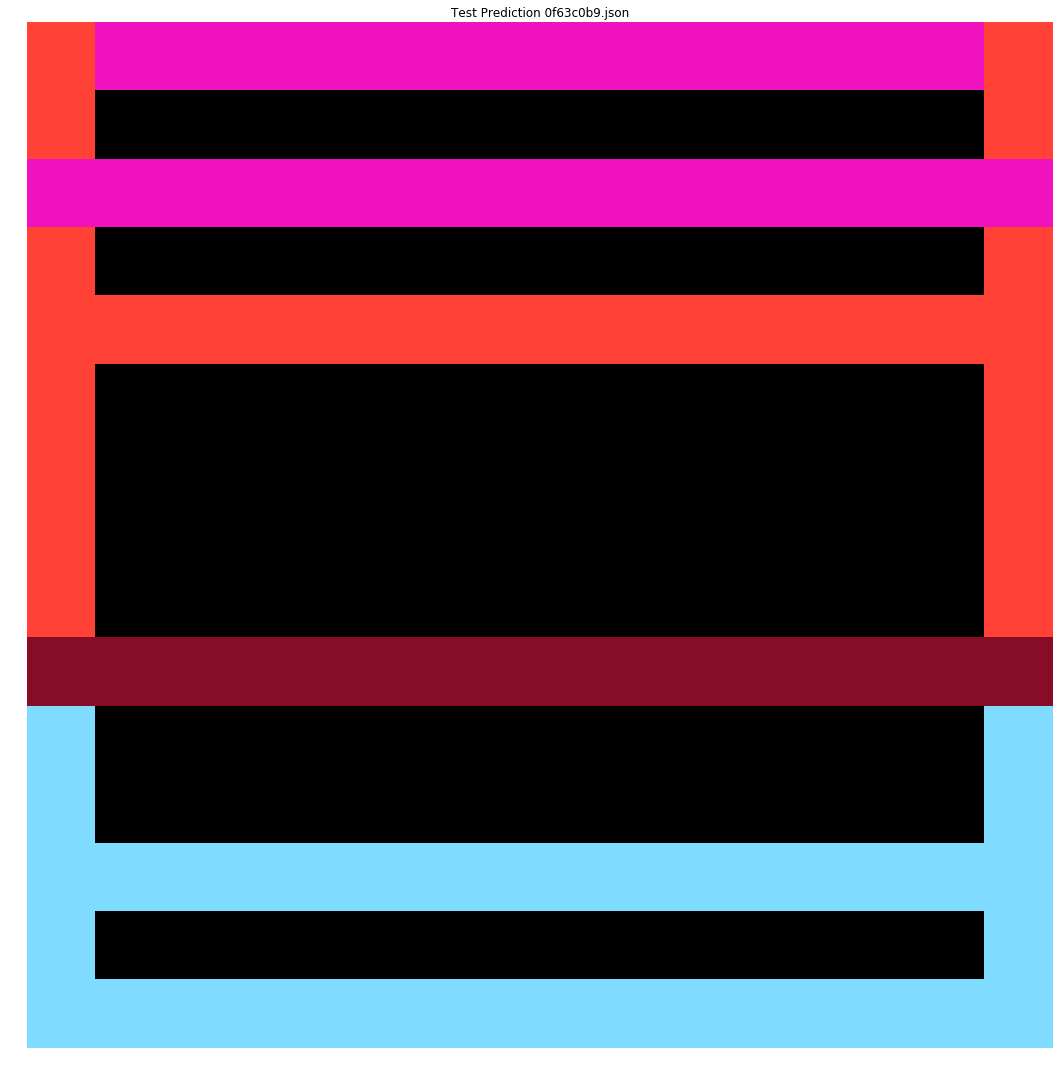

Made predictions for  103eff5b


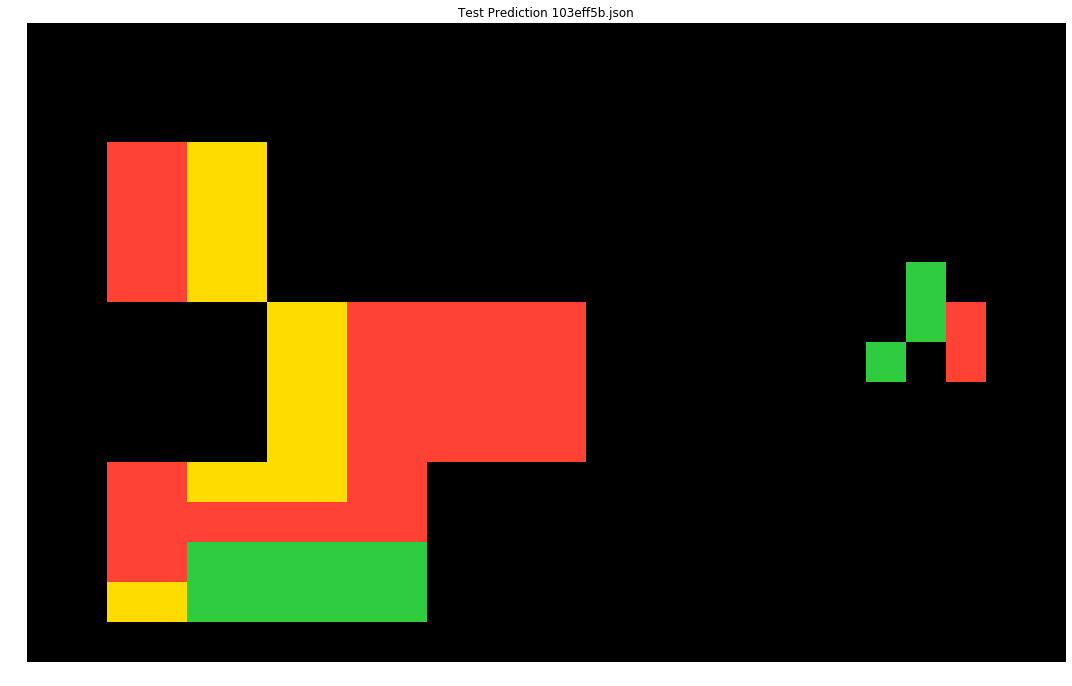

Made predictions for  11e1fe23


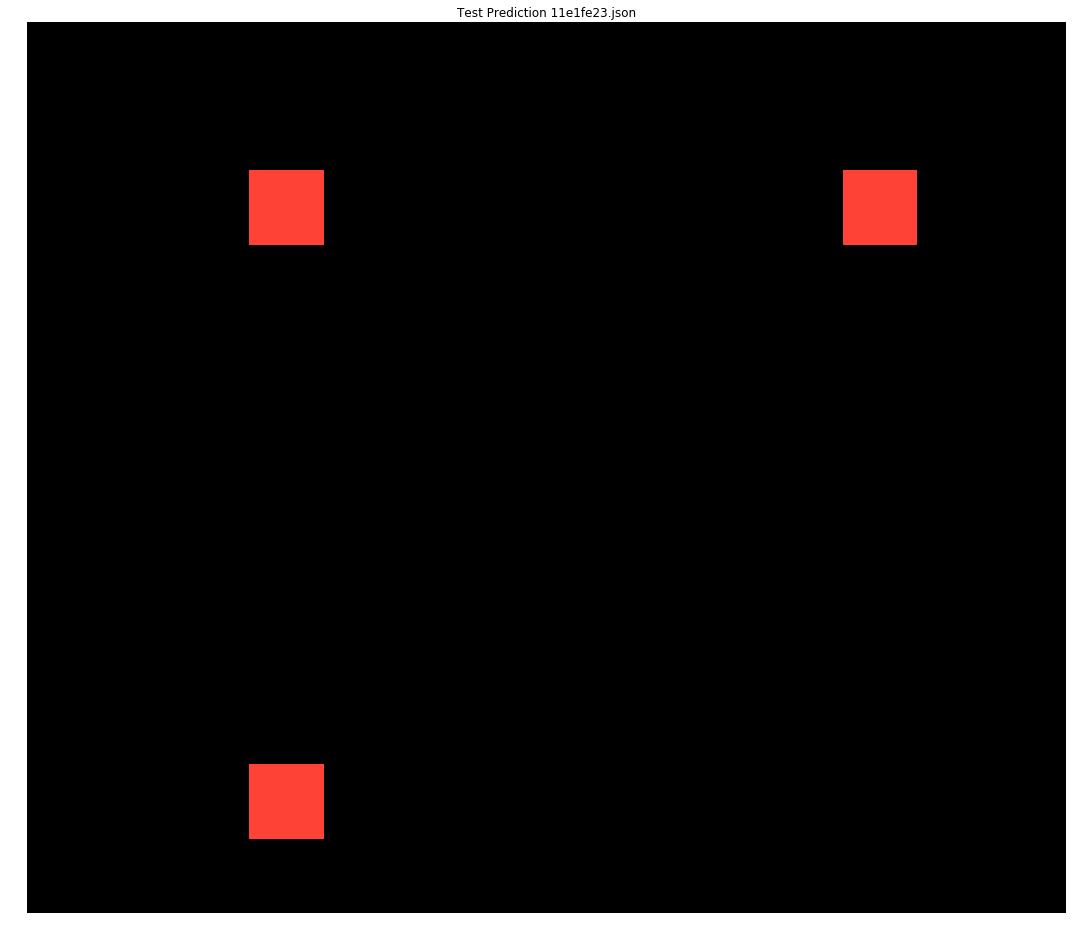

Made predictions for  12422b43


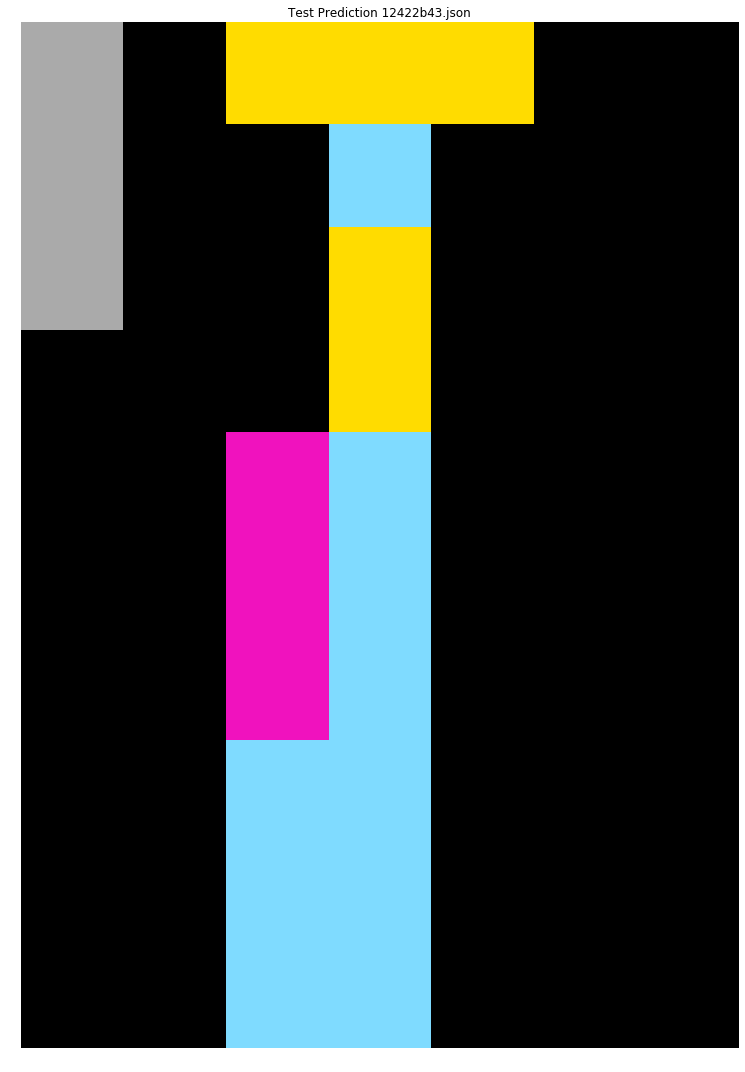

Number of input rows: 11 cols: 14
Number of target rows: 3 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/12997ef3.json

Made predictions for  12eac192


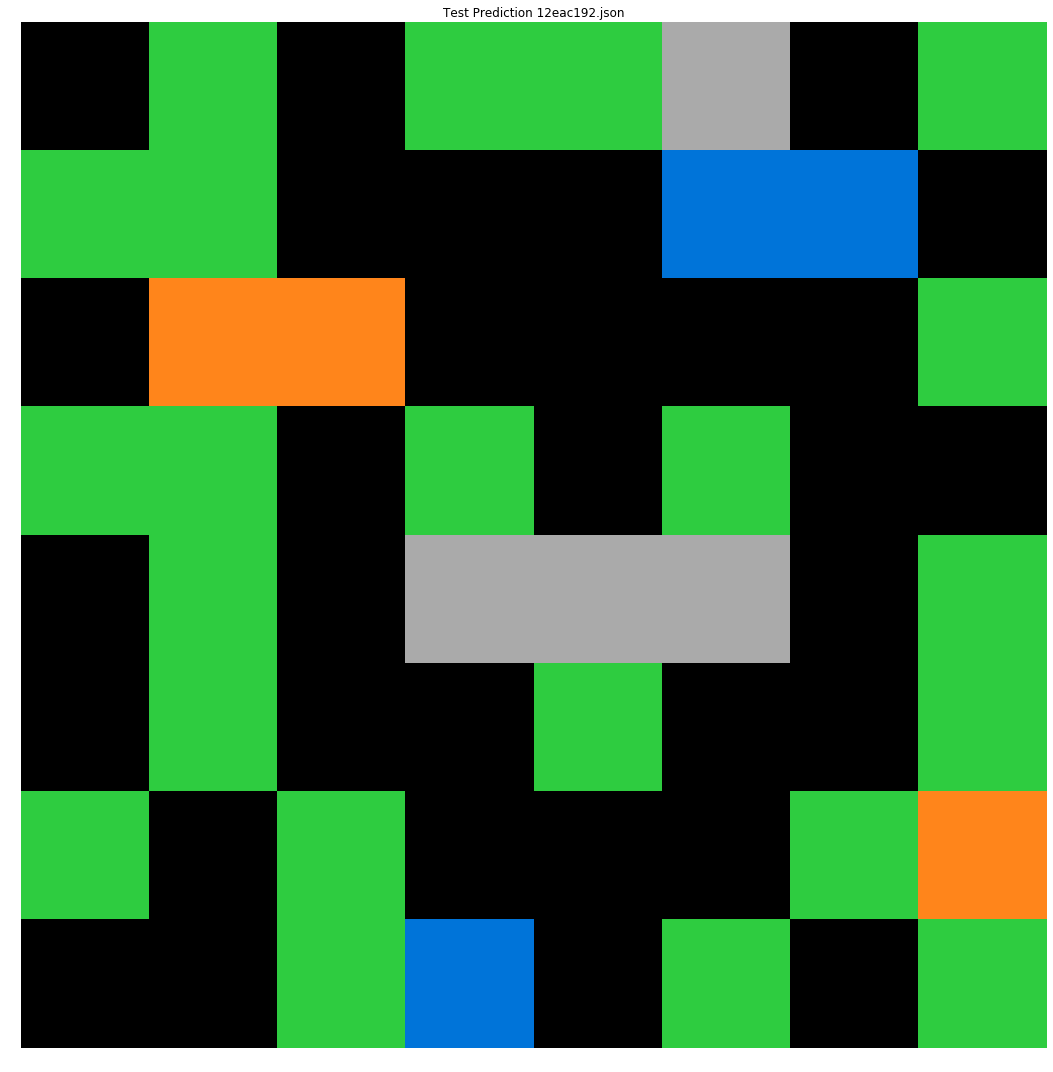

Number of input rows: 7 cols: 15
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/136b0064.json

Made predictions for  13713586


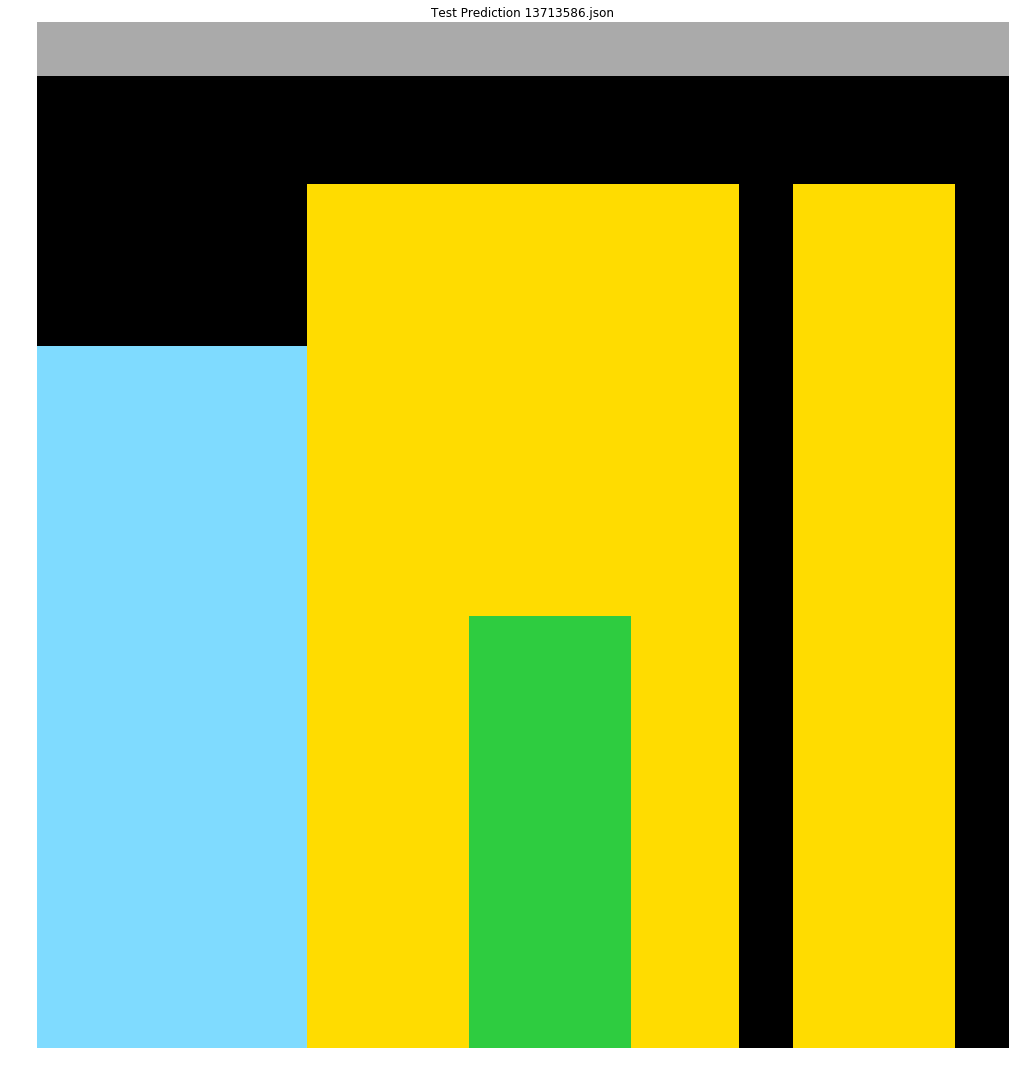

Made predictions for  137f0df0


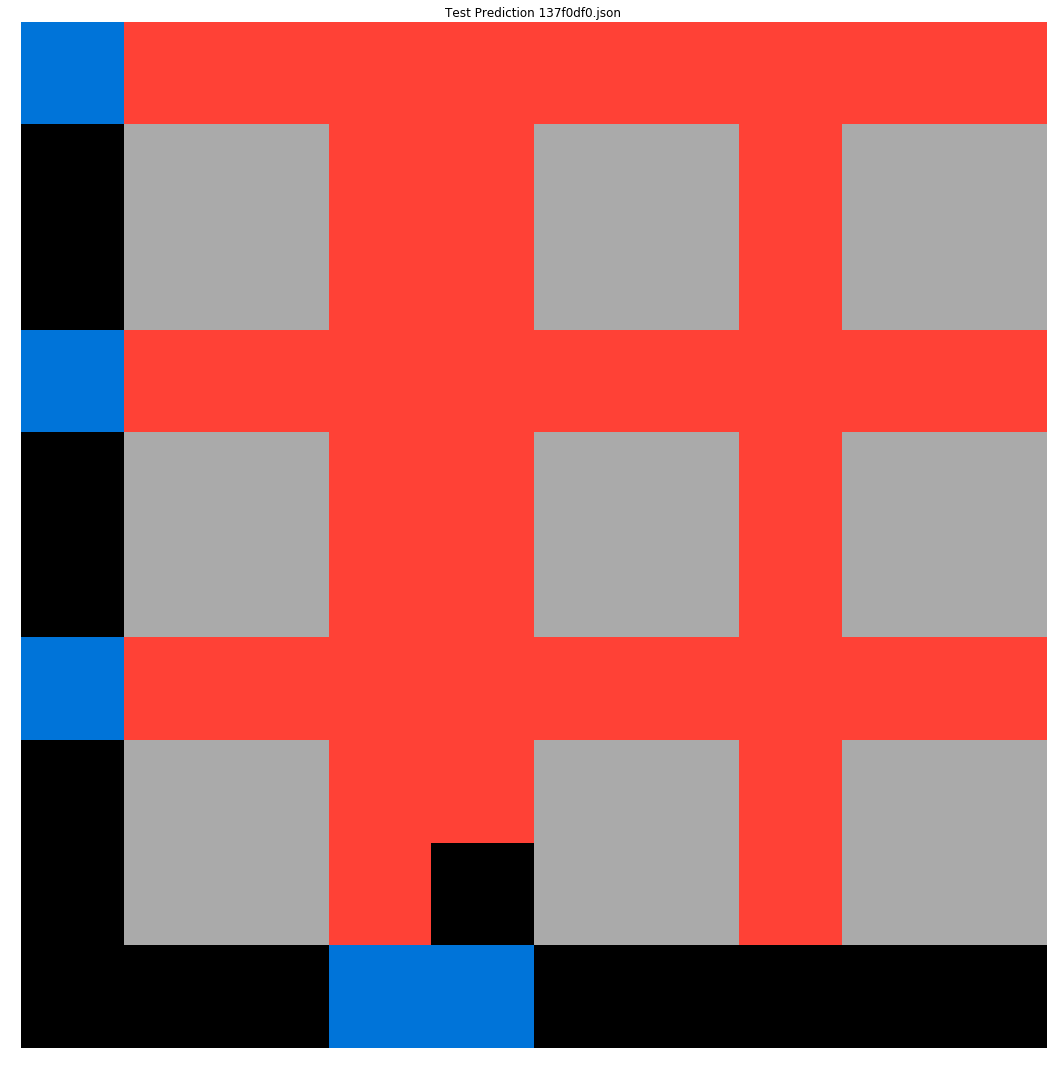

Made predictions for  140c817e


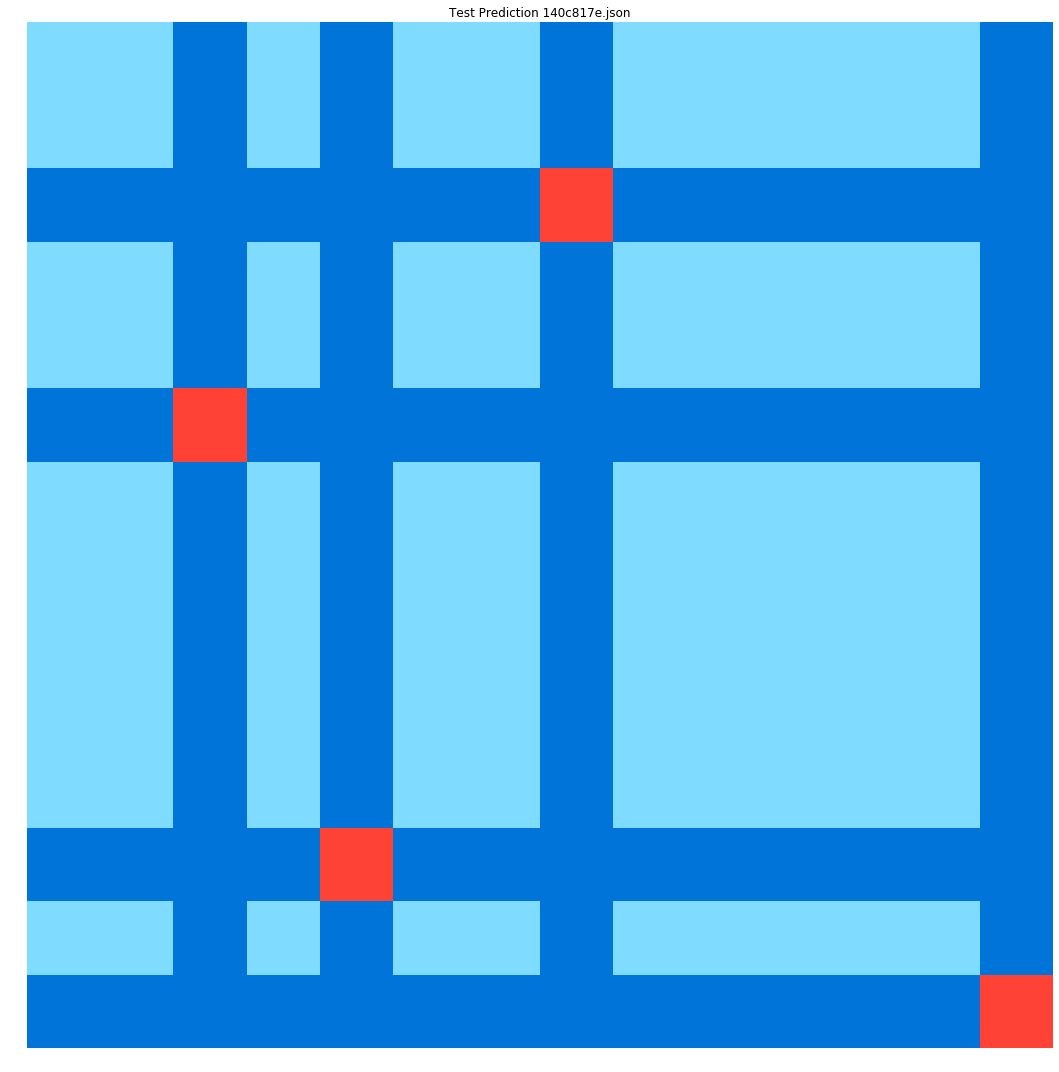

Made predictions for  14754a24


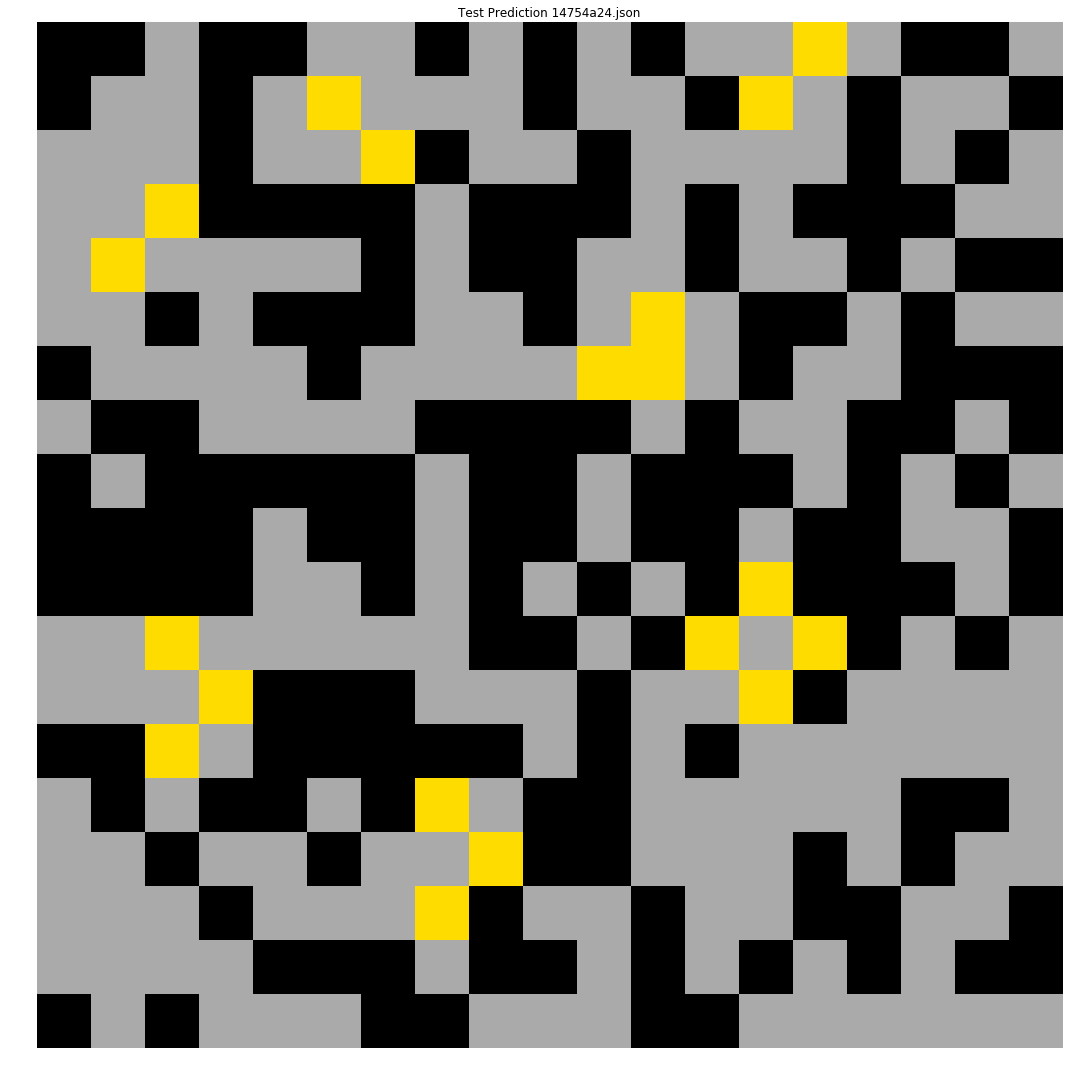

Made predictions for  15113be4


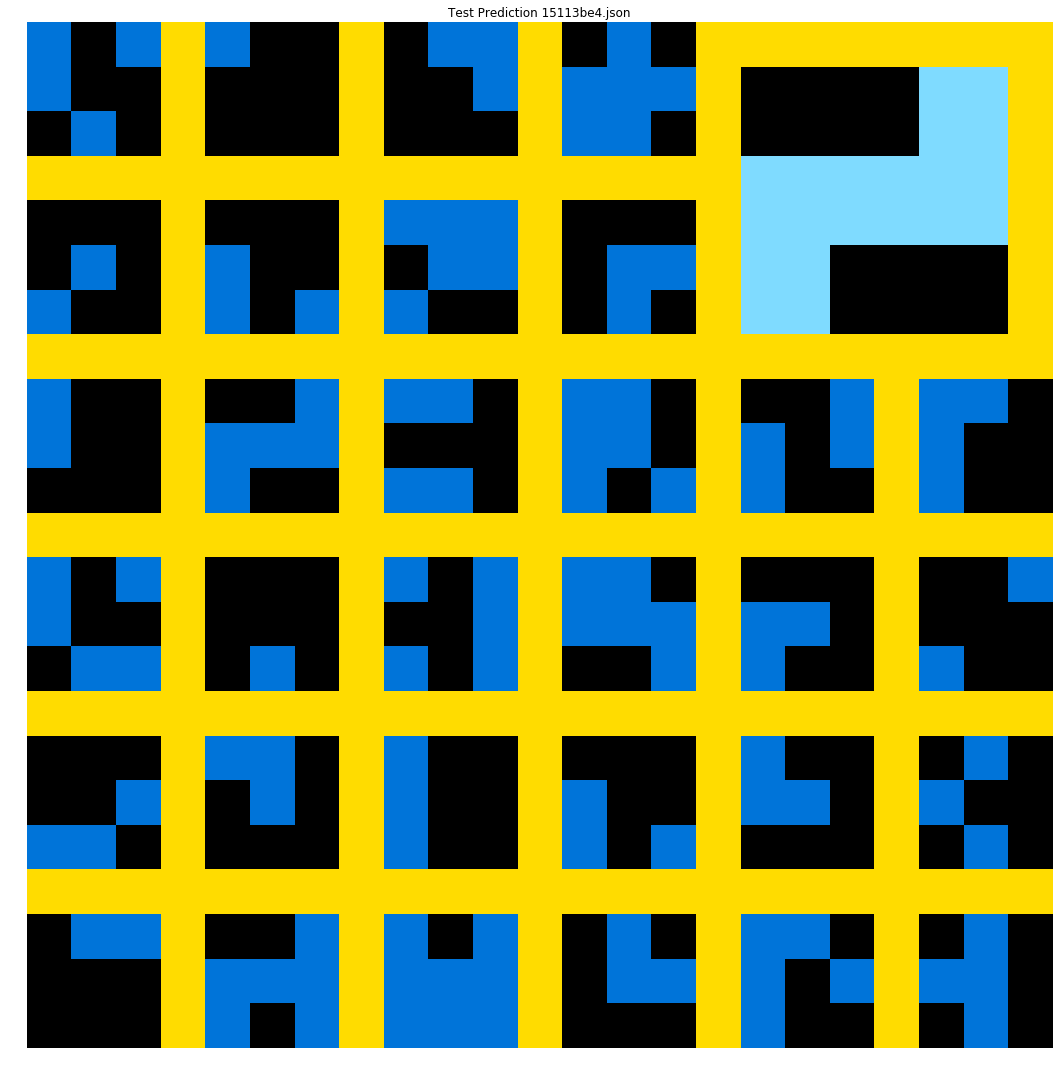

Made predictions for  15663ba9


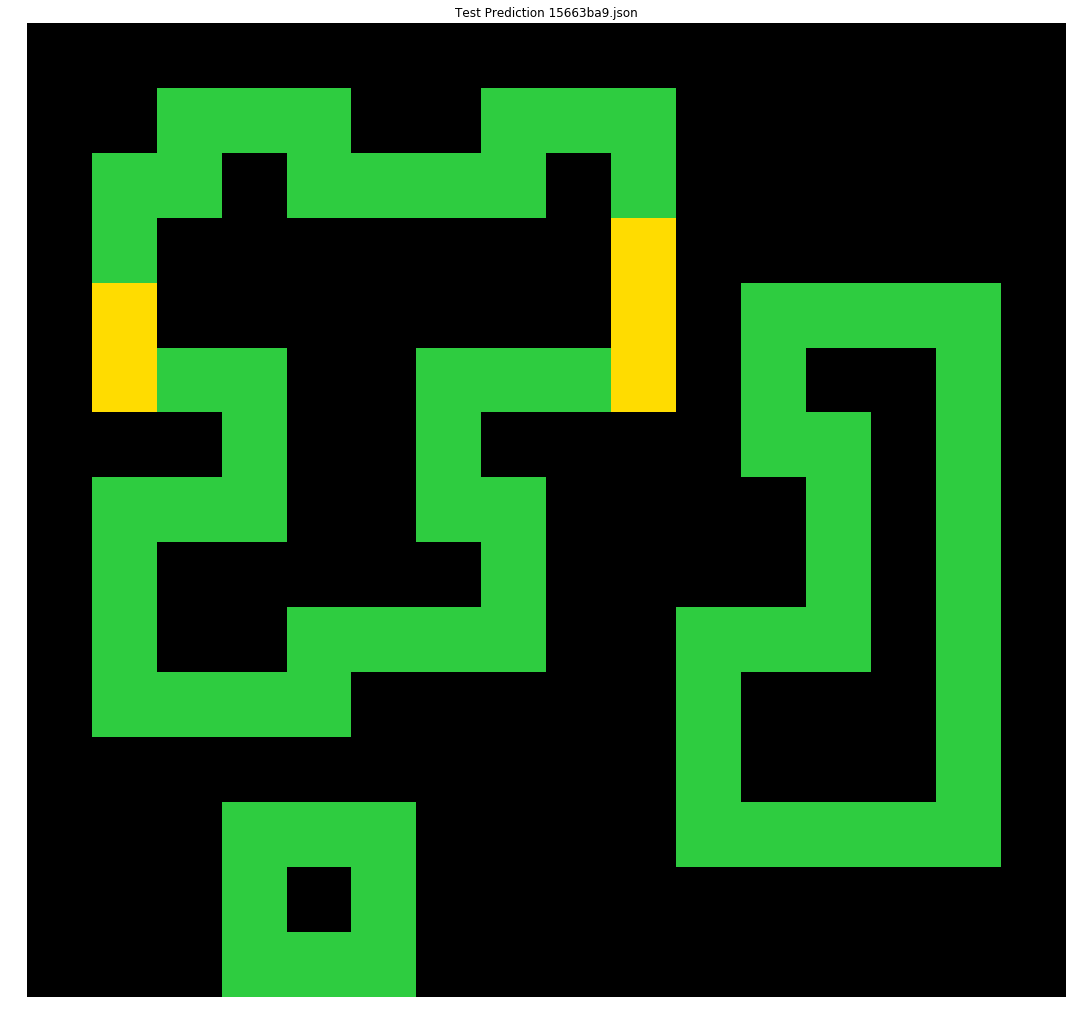

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/15696249.json

Made predictions for  16b78196


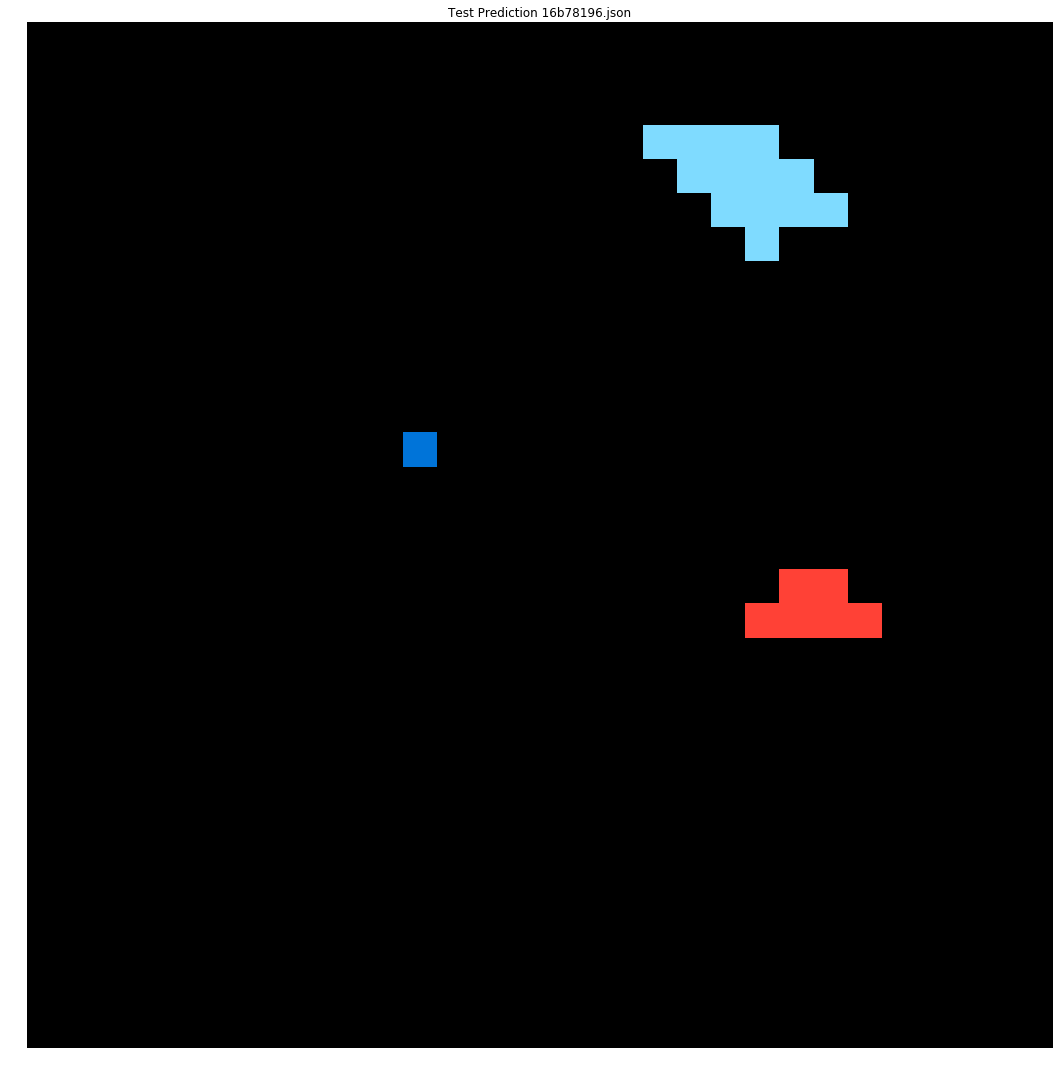

Made predictions for  17b80ad2


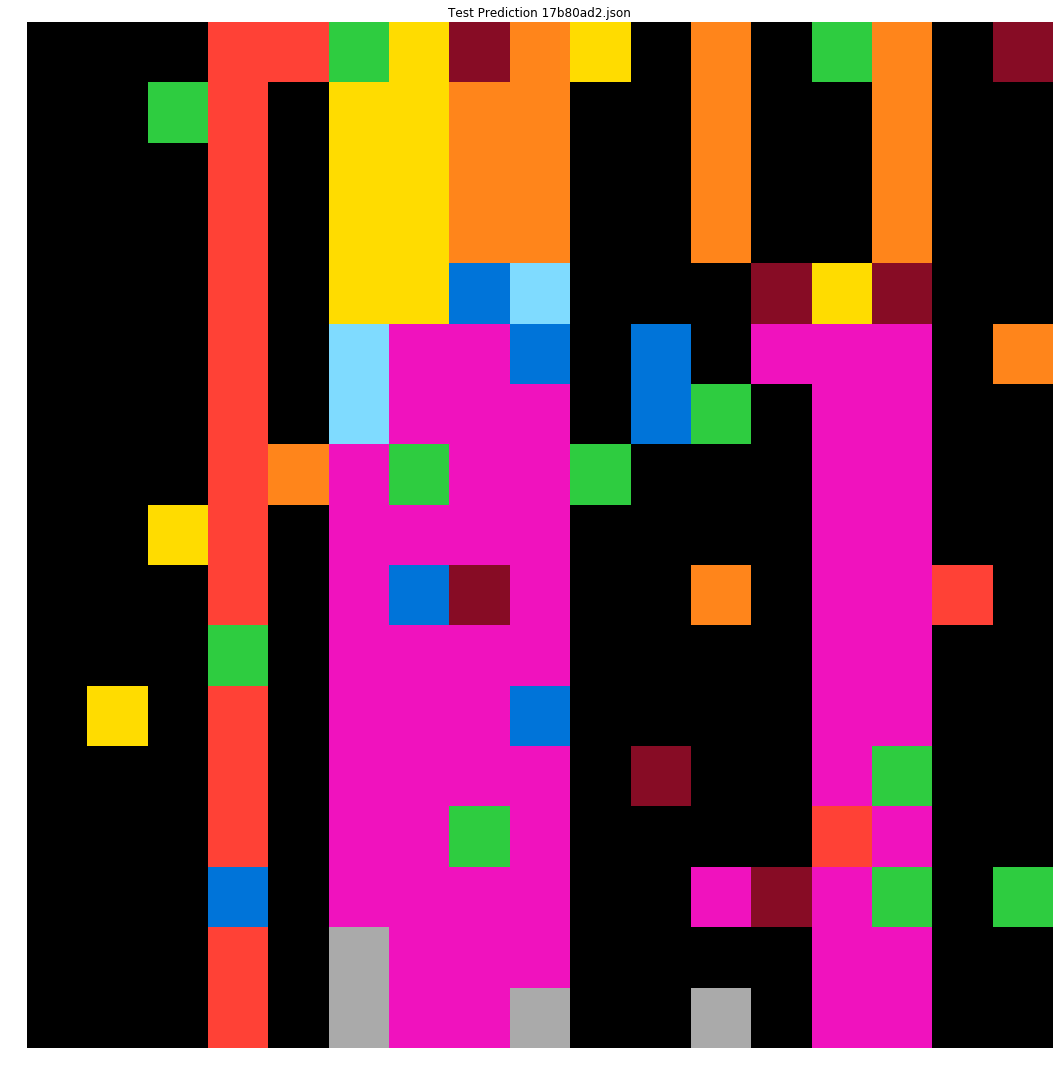

Made predictions for  17cae0c1


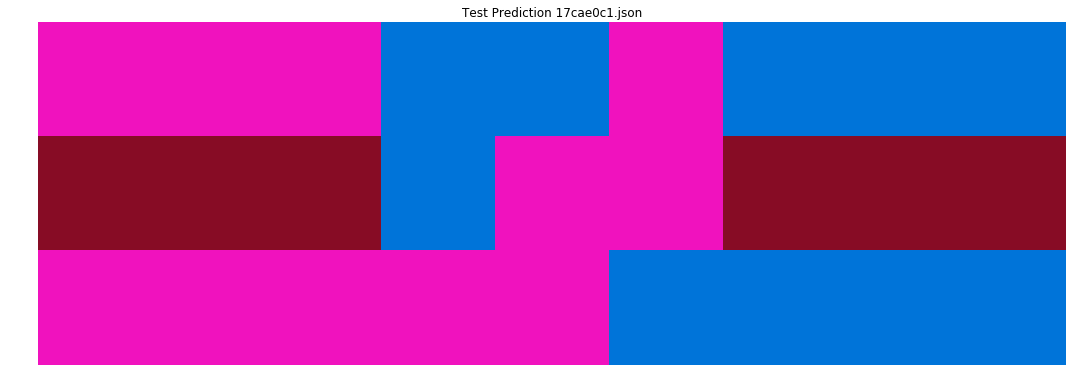

Made predictions for  18419cfa


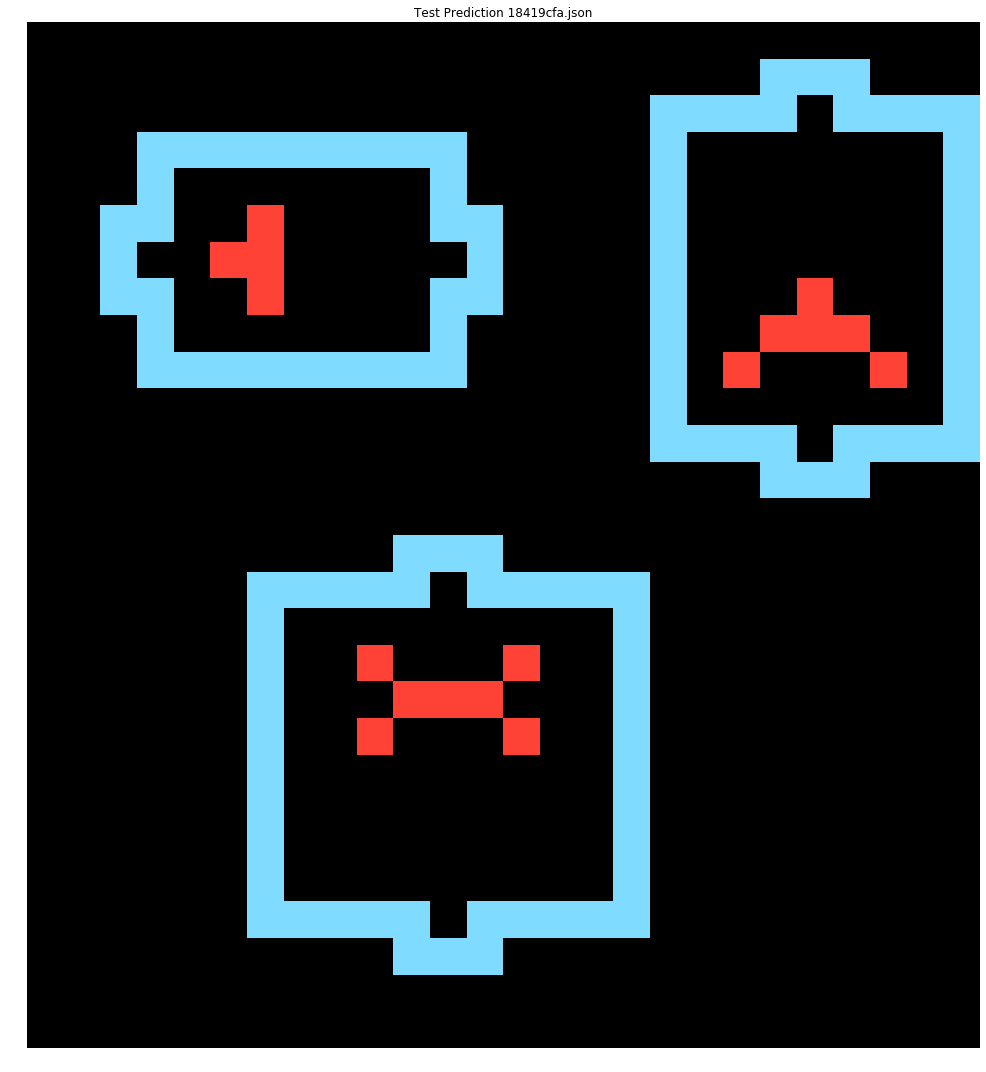

Made predictions for  184a9768


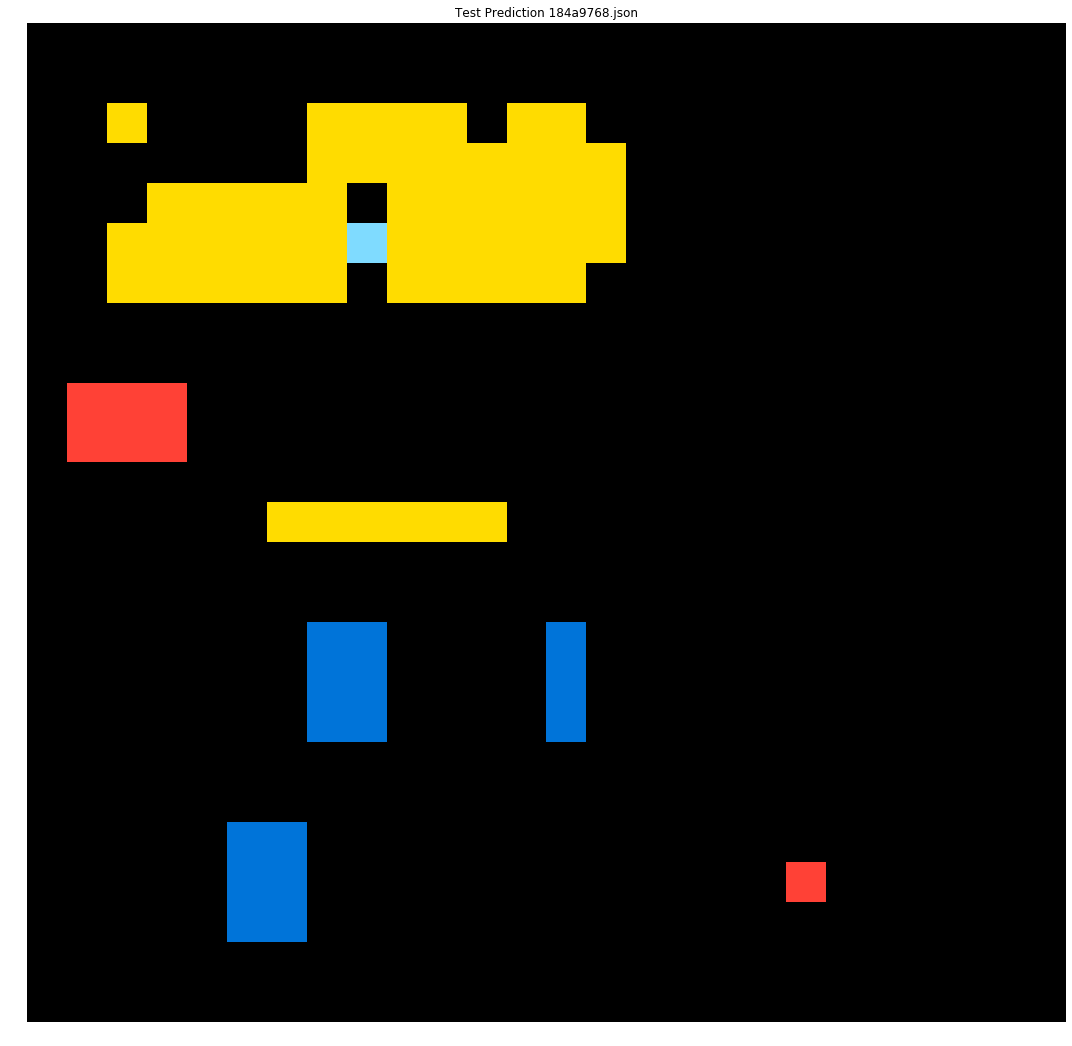

Number of input rows: 5 cols: 13
Number of target rows: 5 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/195ba7dc.json

Number of input rows: 23 cols: 23
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/1990f7a8.json

Number of input rows: 13 cols: 15
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/19bb5feb.json

Number of input rows: 8 cols: 12
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/1a2e2828.json

Number of input rows: 19 cols: 13
Number of target rows: 6 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/1a6449f1.json

Made predictions for  1acc24af


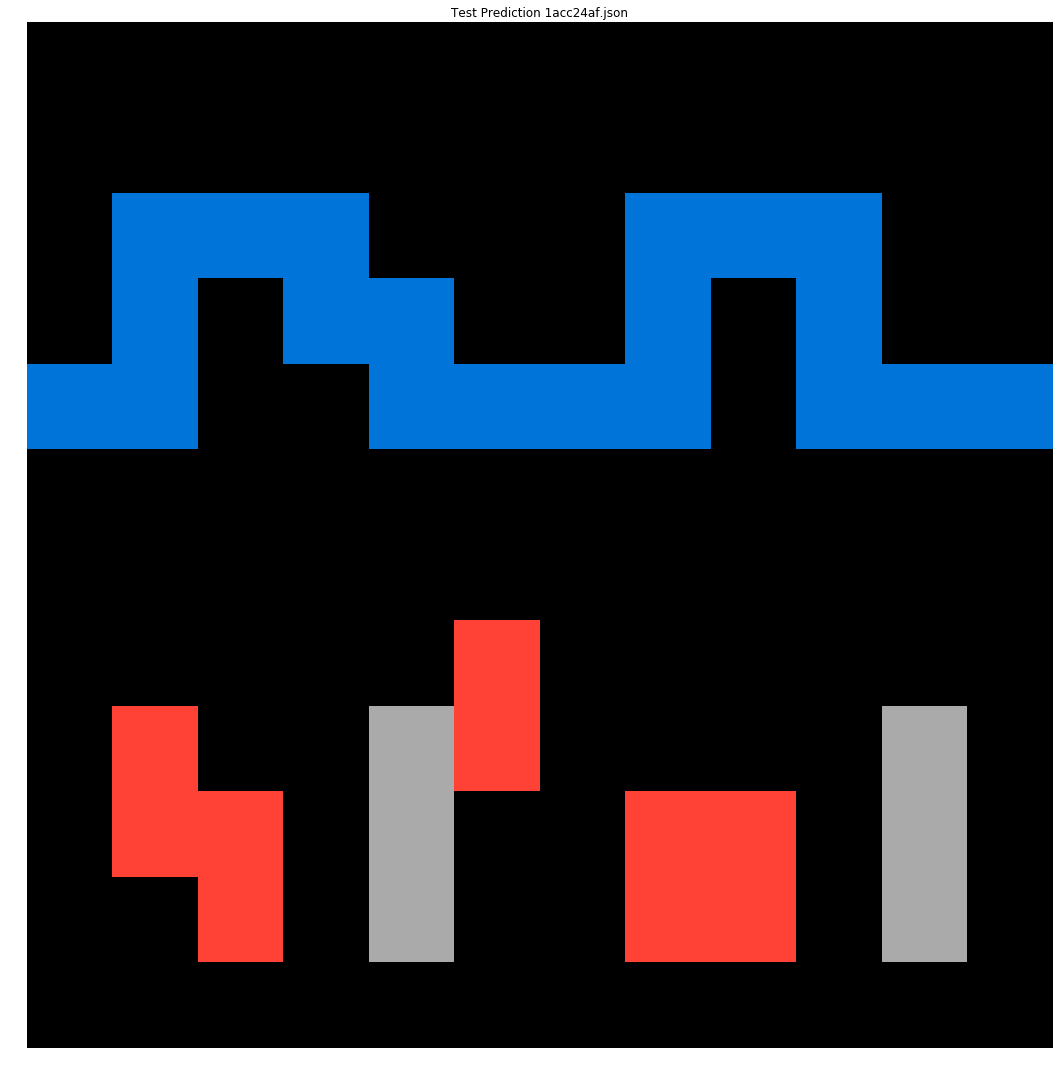

Made predictions for  1c02dbbe


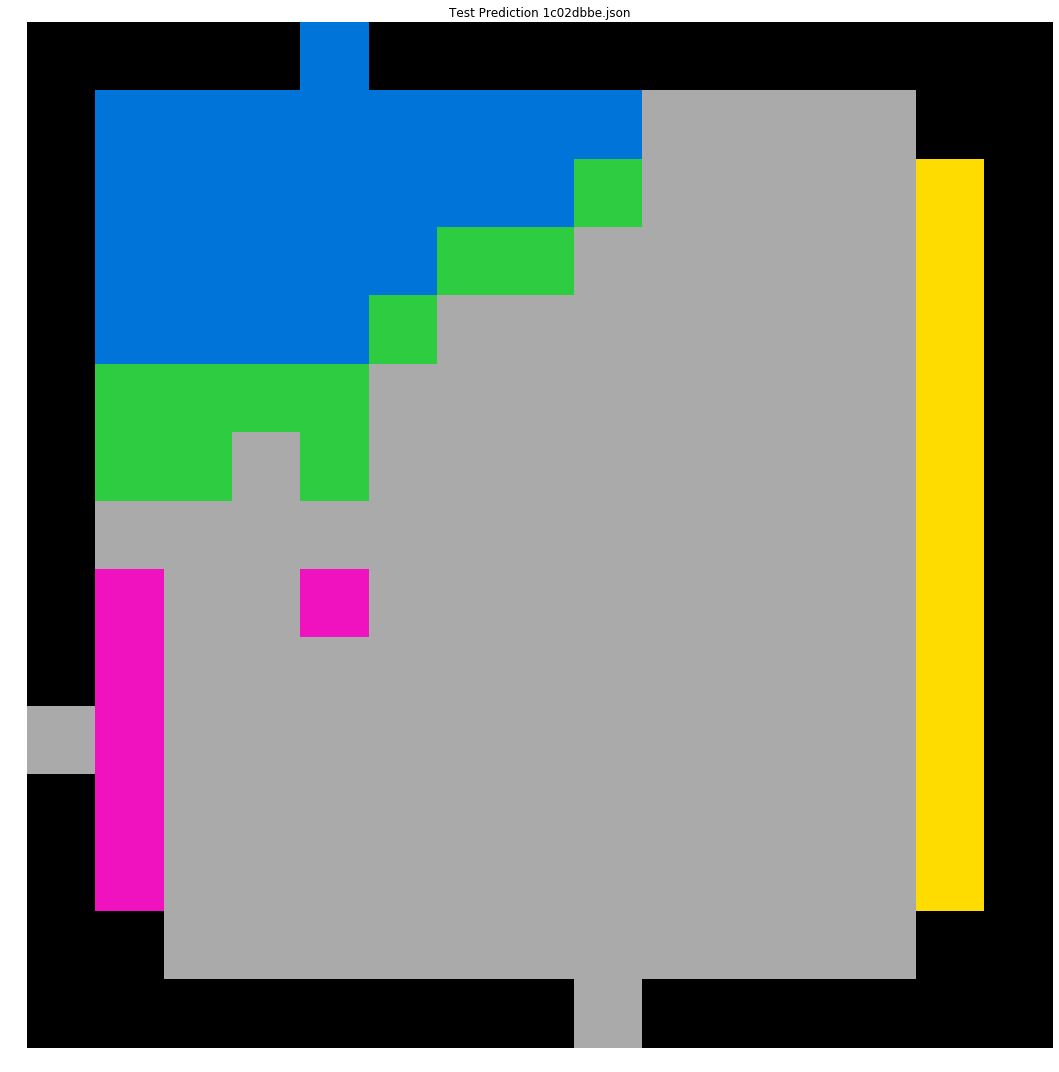

Made predictions for  1c0d0a4b


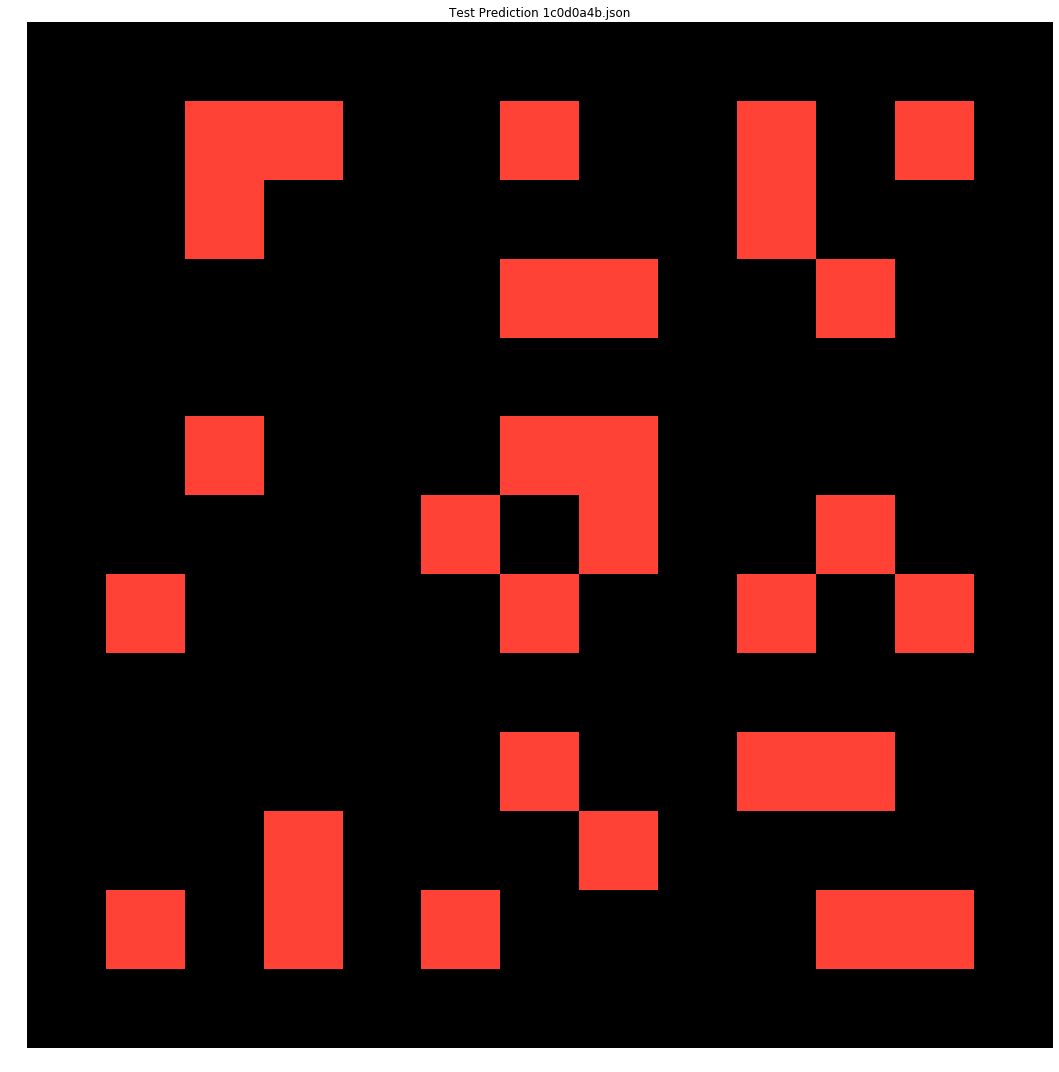

Made predictions for  1c56ad9f


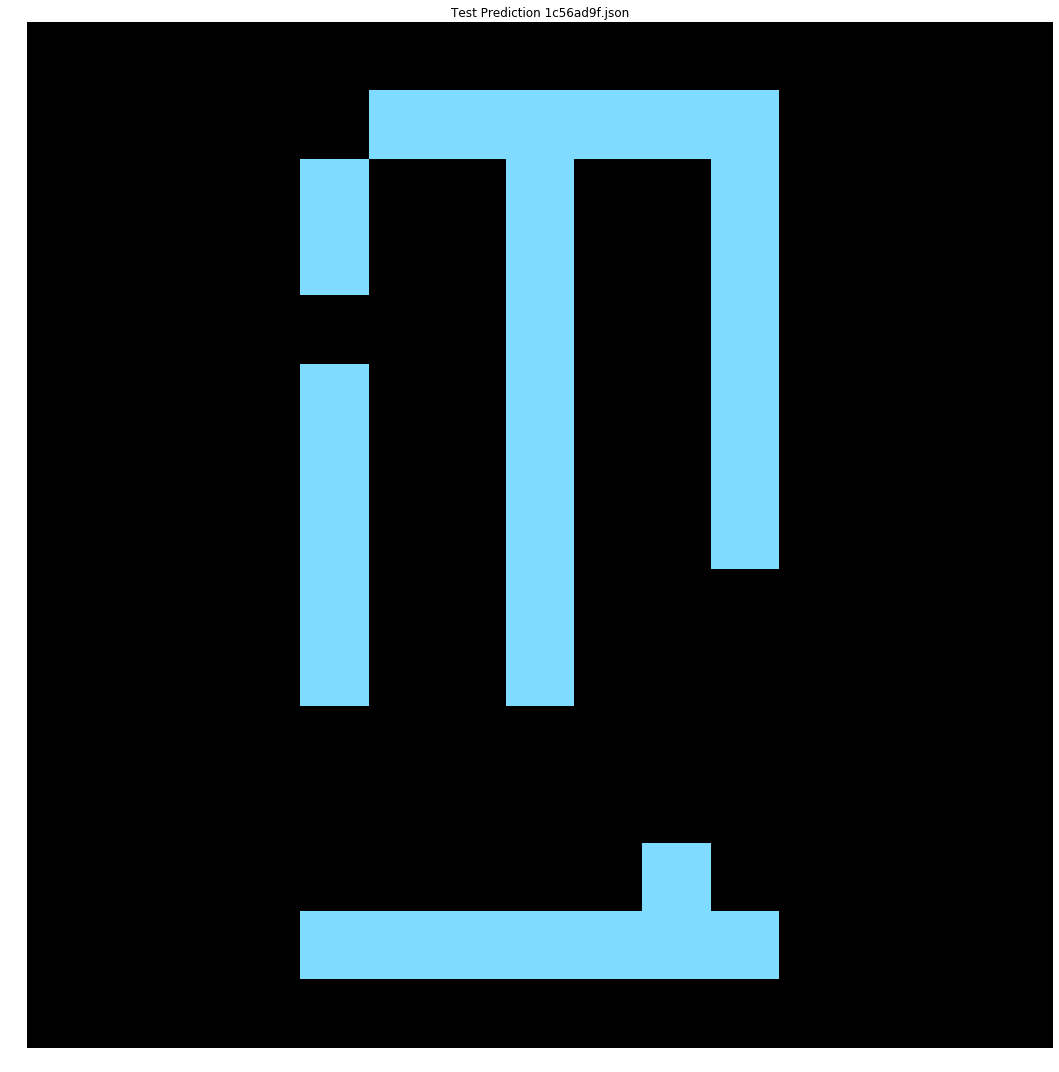

Made predictions for  1d0a4b61


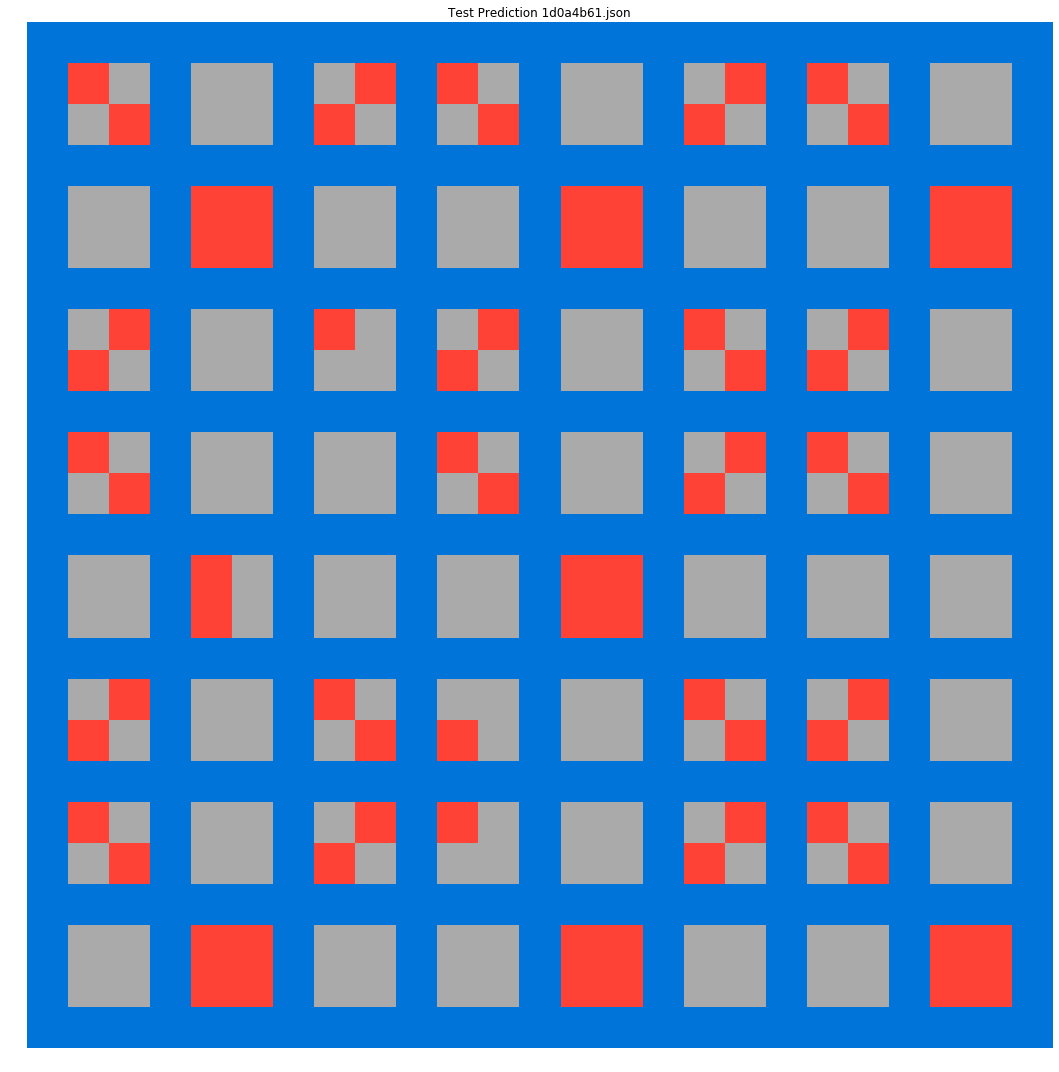

Made predictions for  1d398264


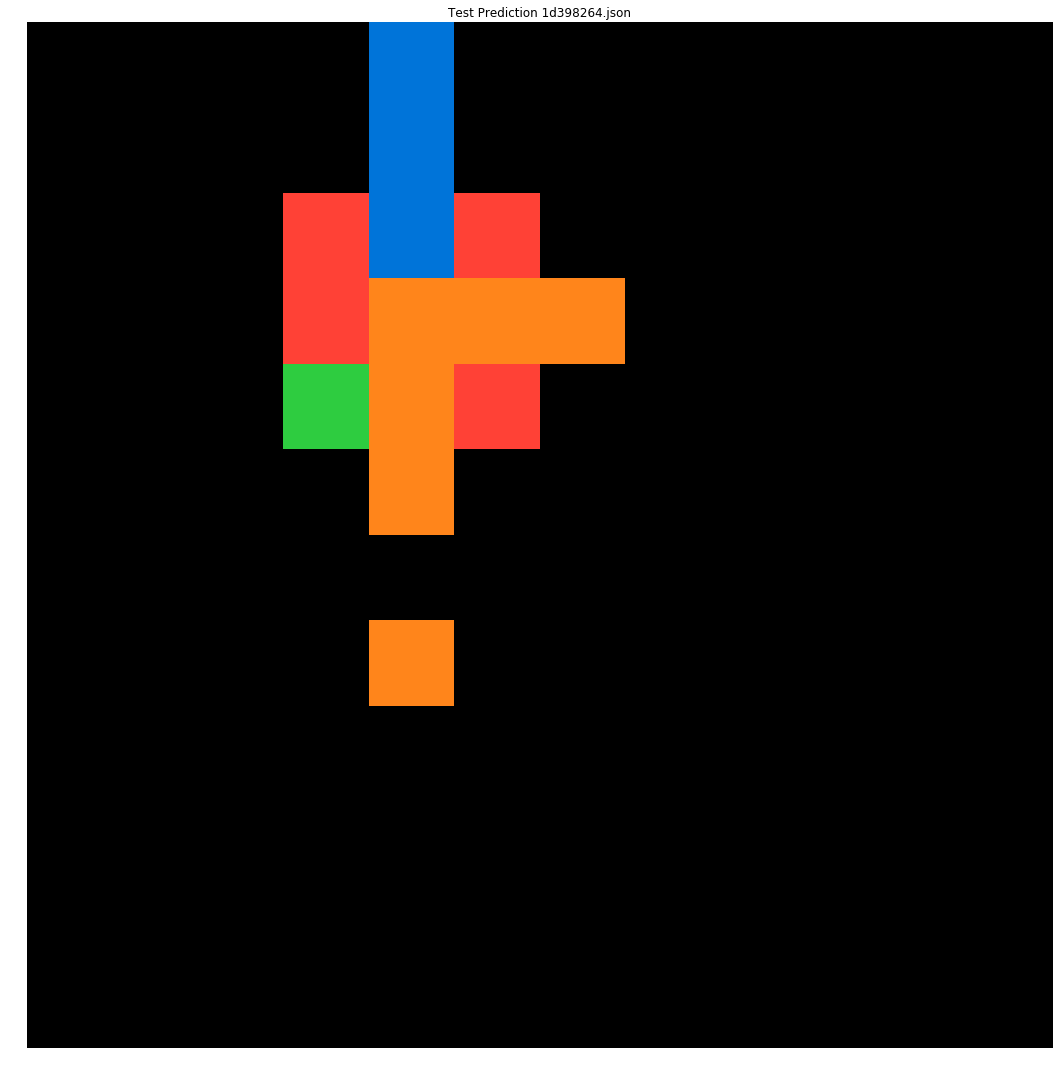

Made predictions for  1d398264


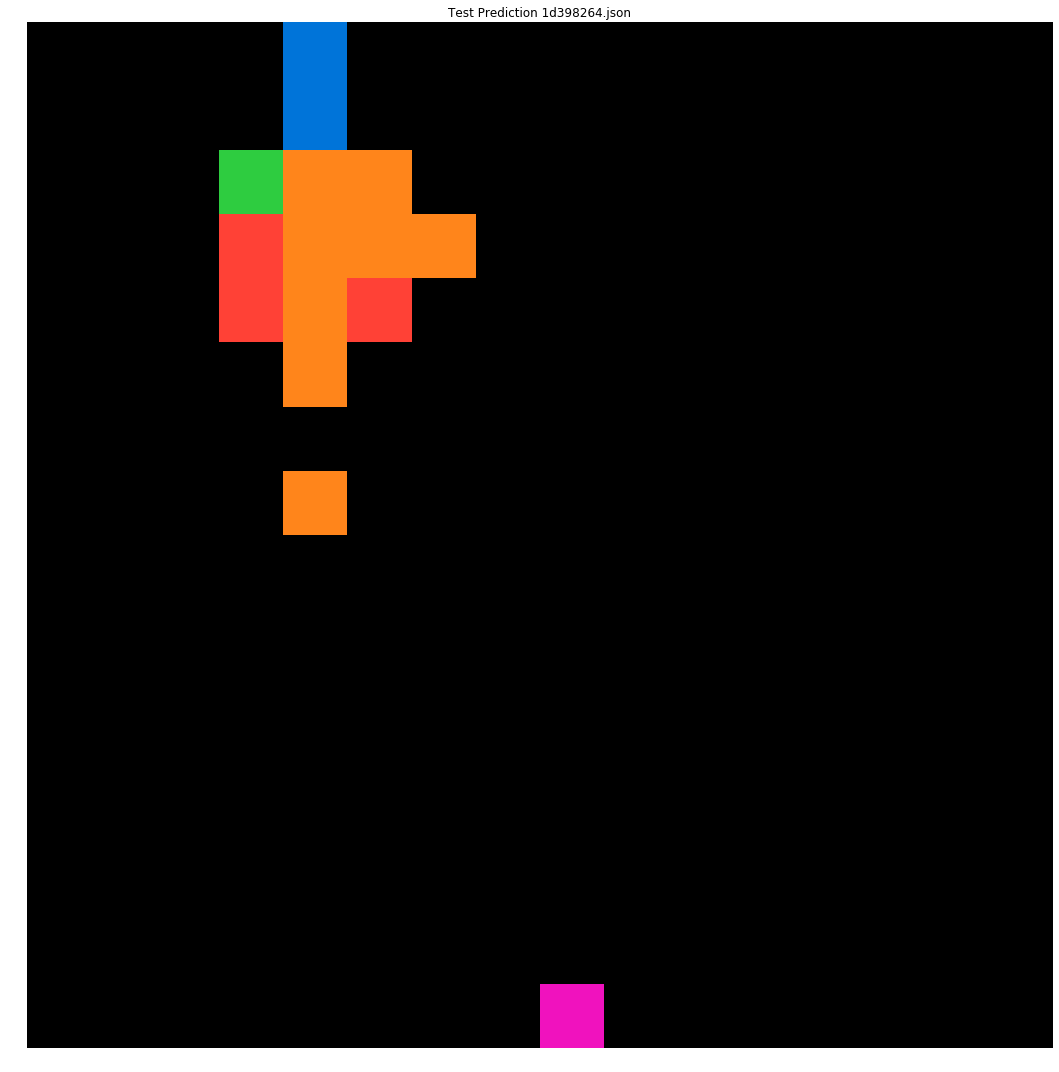

Made predictions for  1da012fc


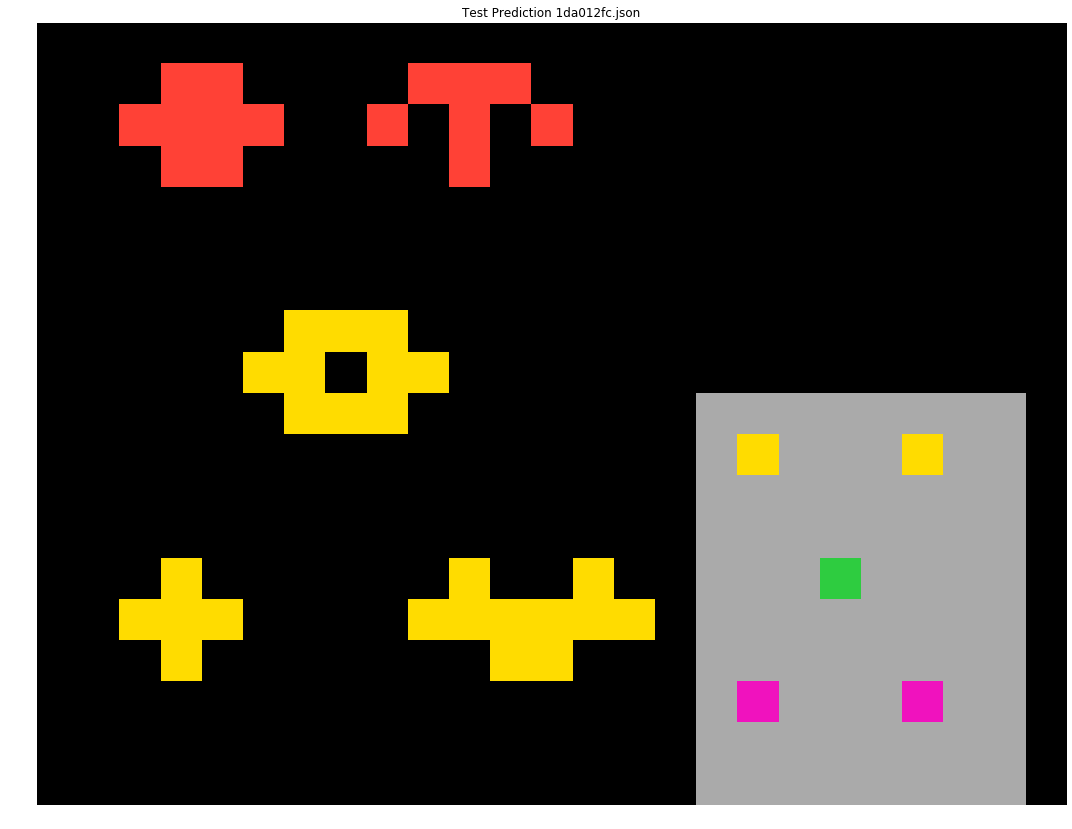

Made predictions for  1e81d6f9


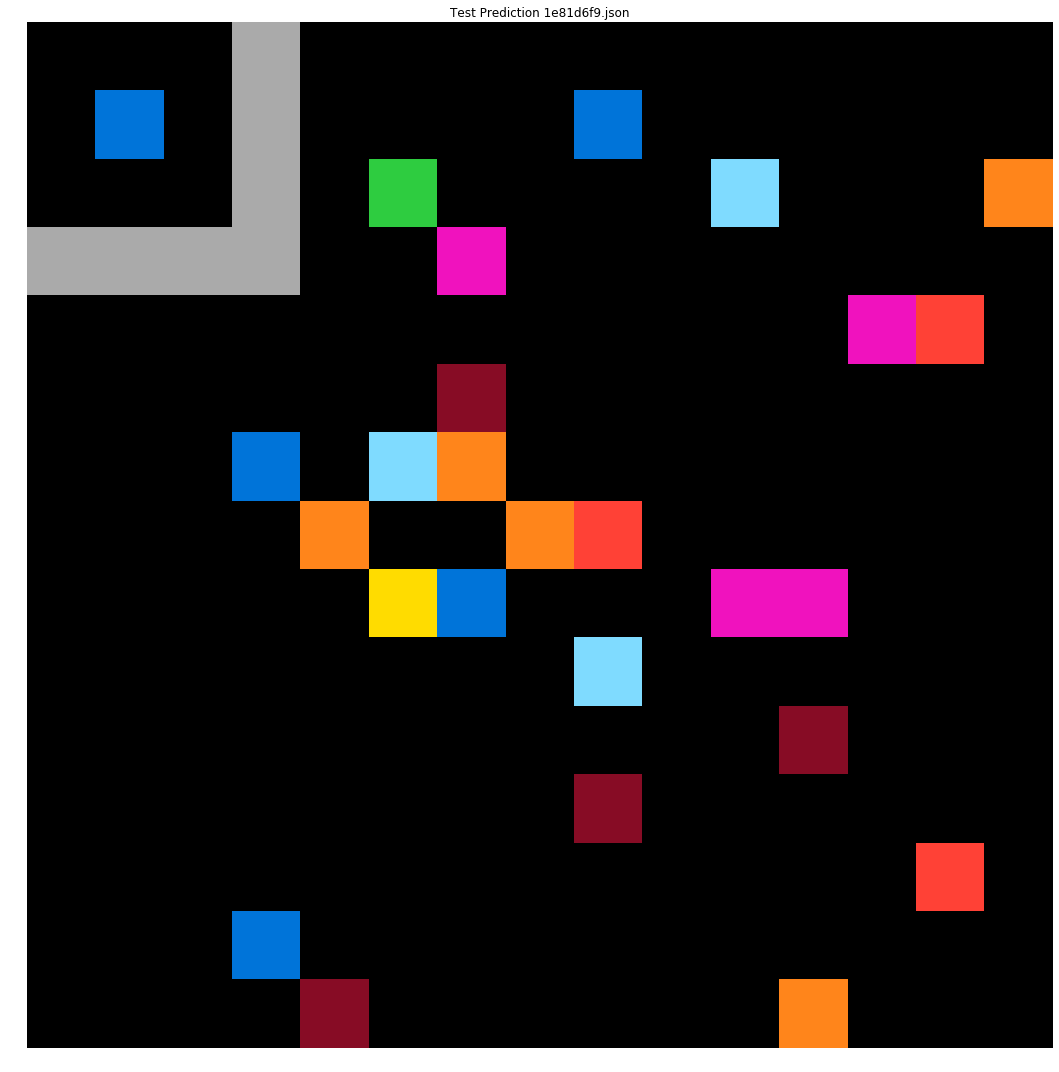

Made predictions for  1e97544e


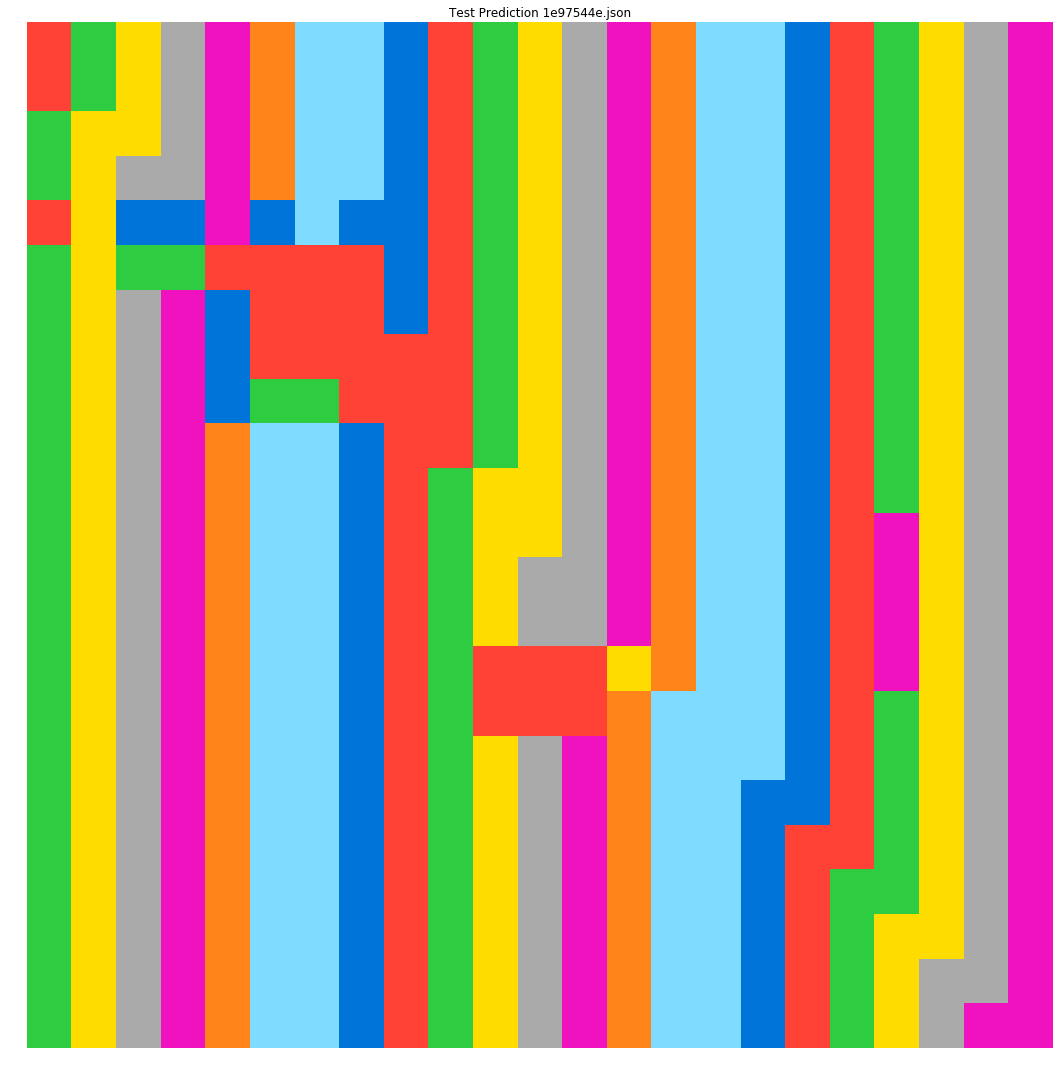

Number of input rows: 23 cols: 25
Number of target rows: 3 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2037f2c7.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2072aba6.json

Number of input rows: 14 cols: 15
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/20818e16.json

Made predictions for  20981f0e


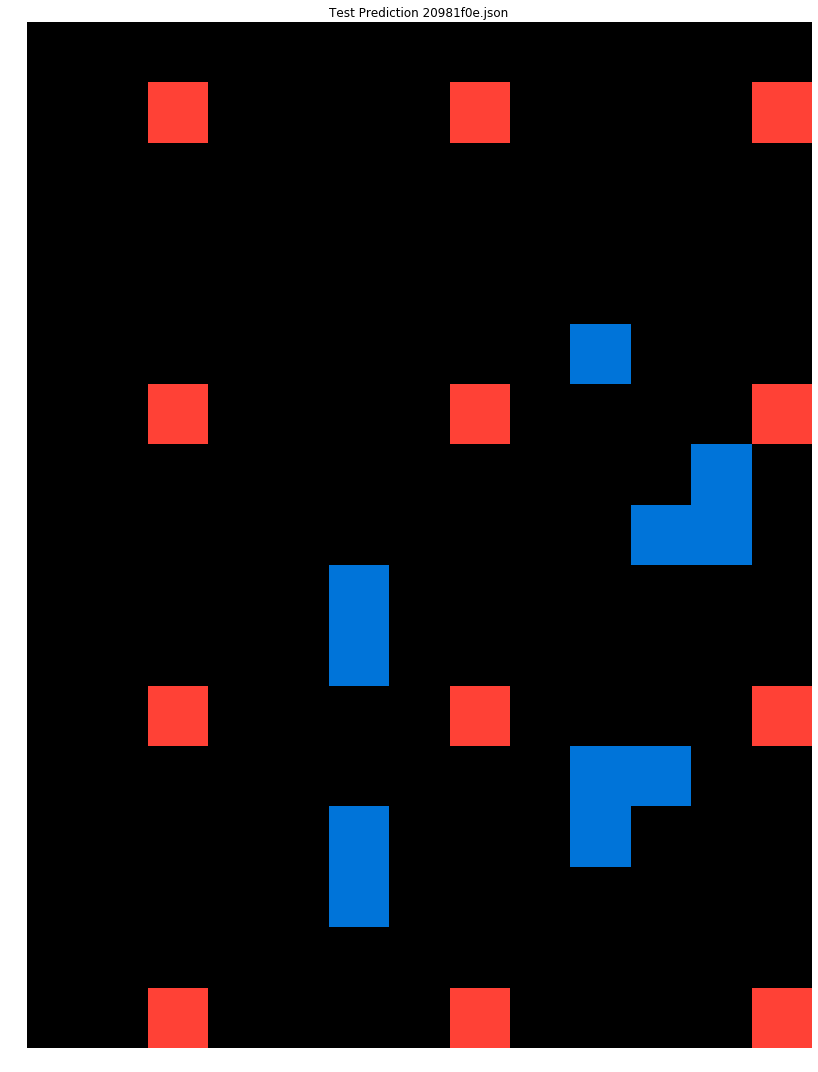

Made predictions for  212895b5


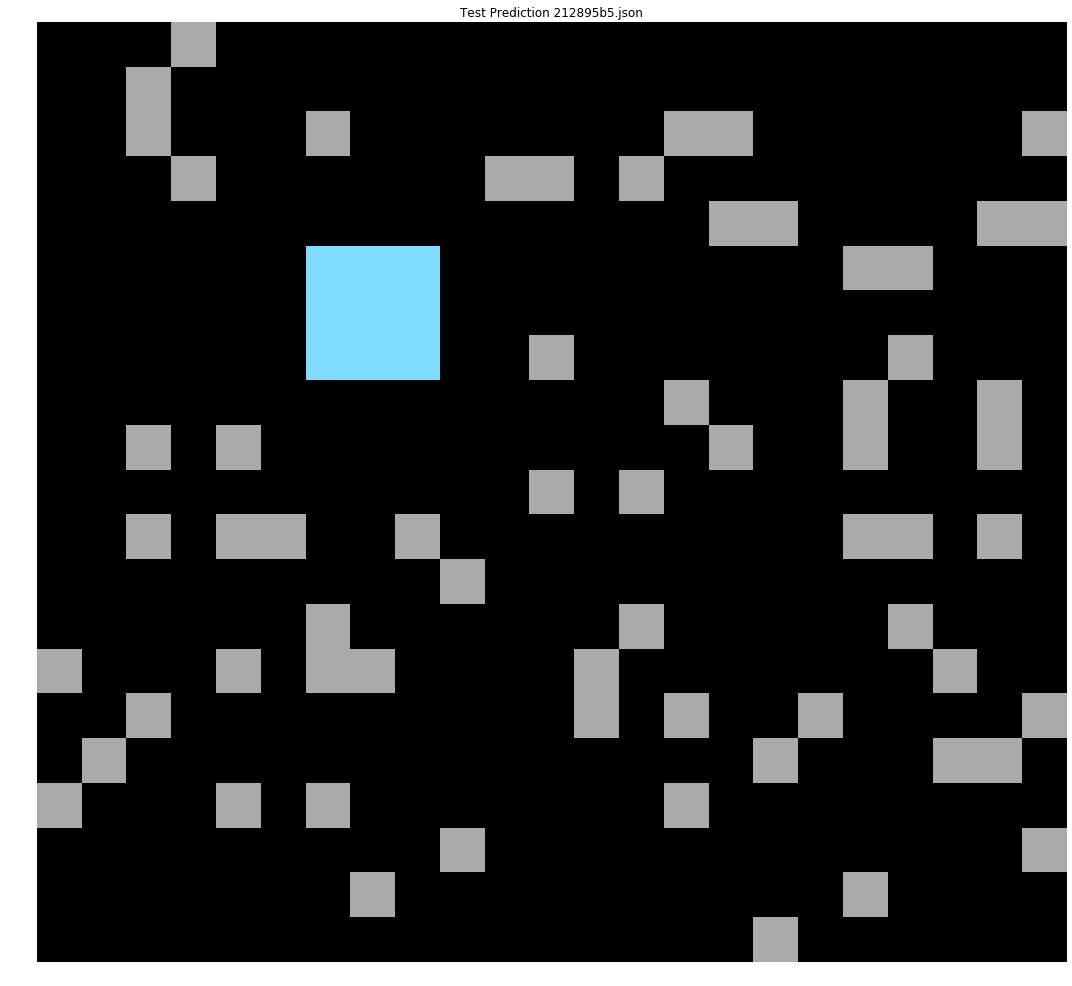

Made predictions for  21f83797


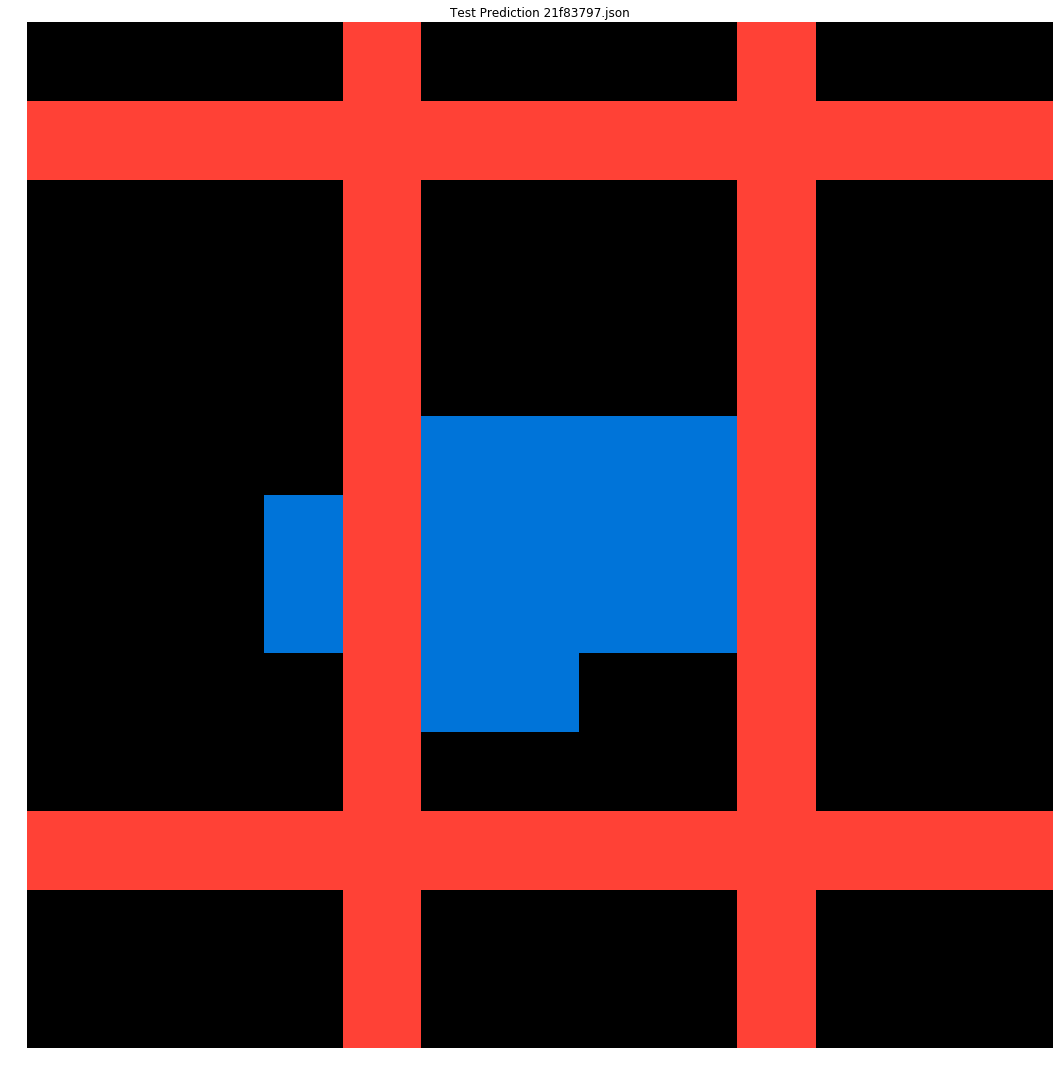

Made predictions for  22a4bbc2


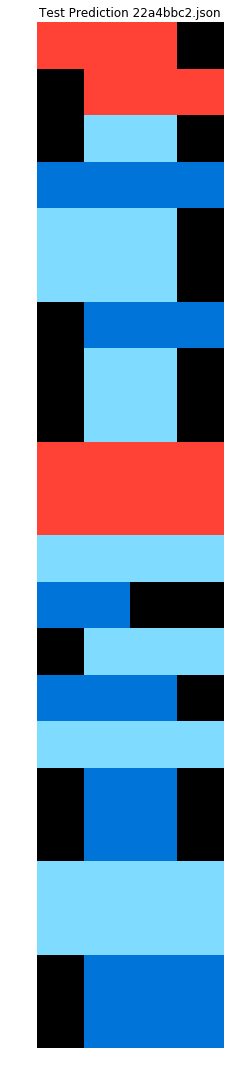

Made predictions for  25094a63


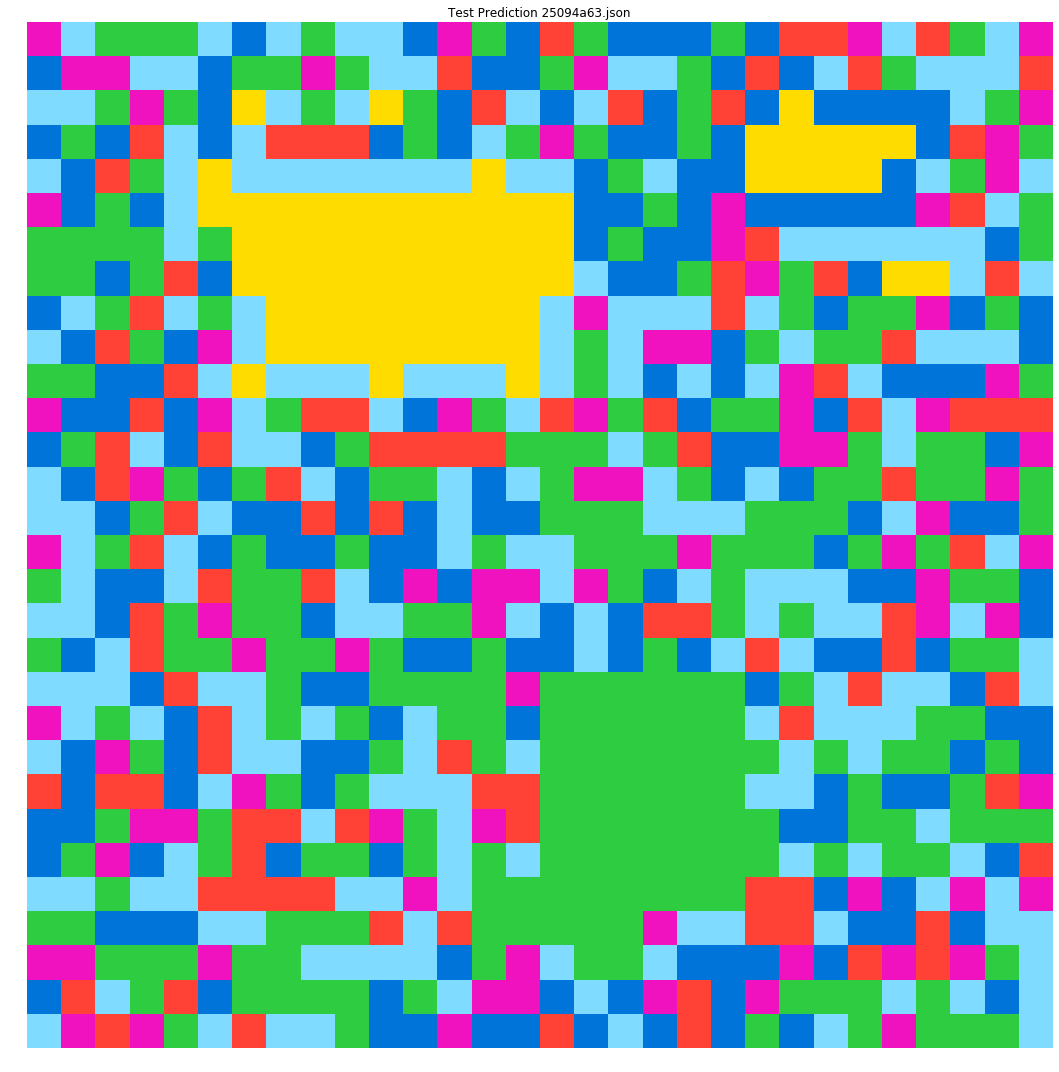

Made predictions for  2546ccf6


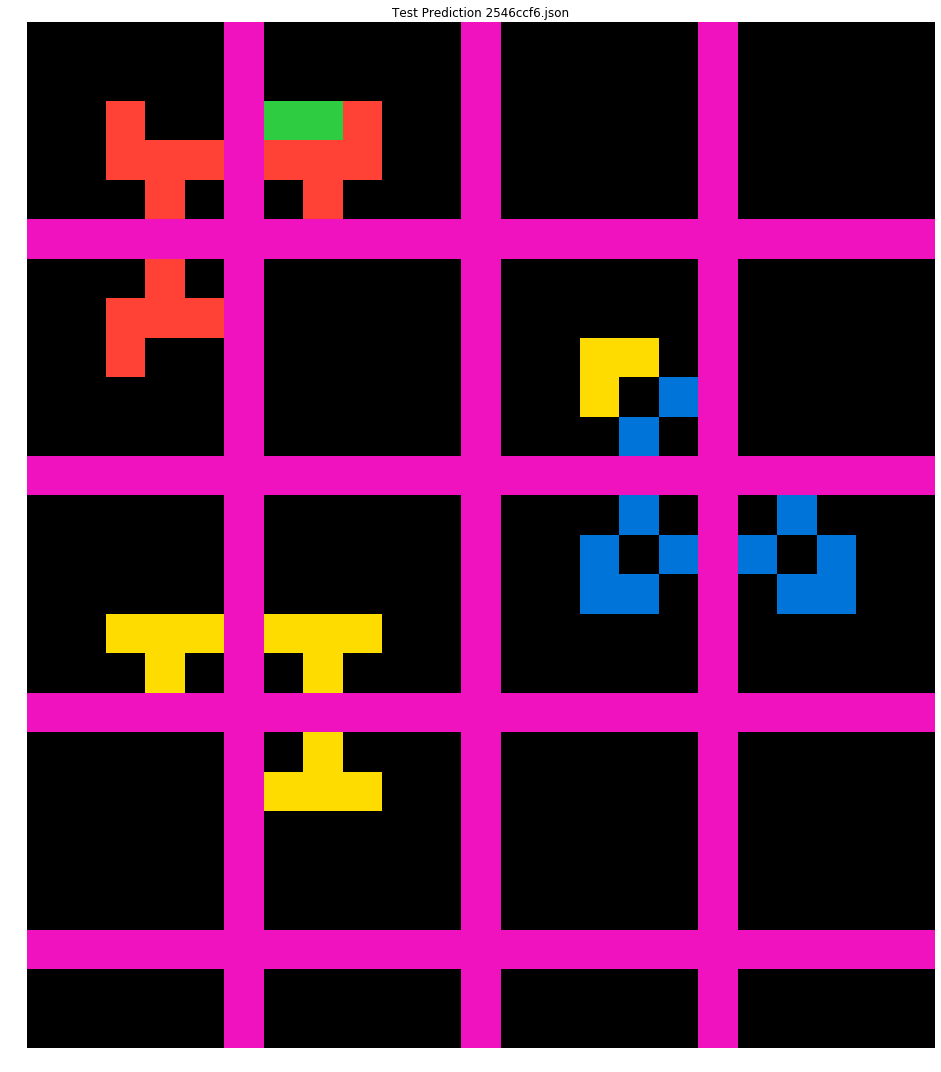

Made predictions for  256b0a75


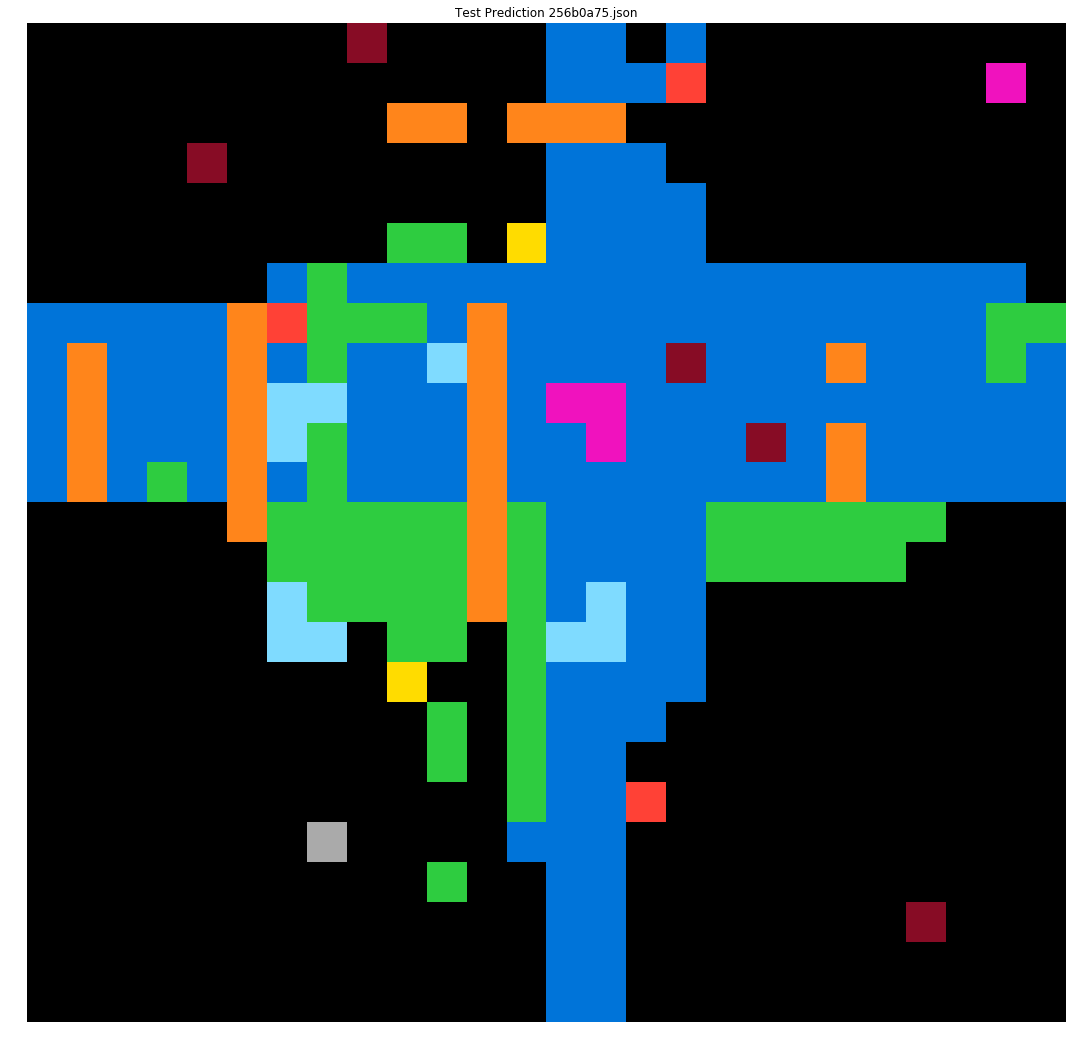

Made predictions for  2685904e


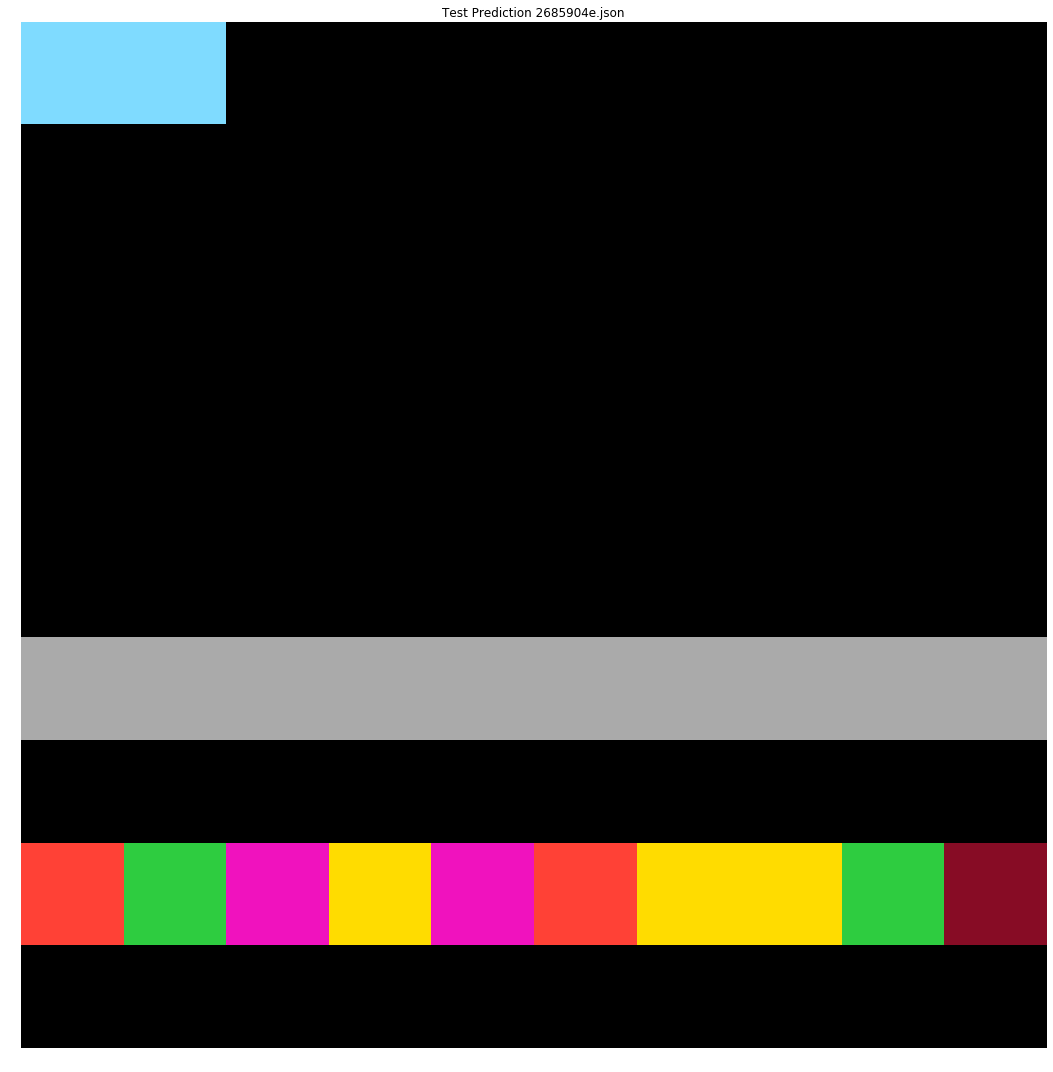

Number of input rows: 9 cols: 7
Number of target rows: 15 cols: 15
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2697da3f.json

Number of input rows: 16 cols: 16
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2753e76c.json

Made predictions for  27a77e38


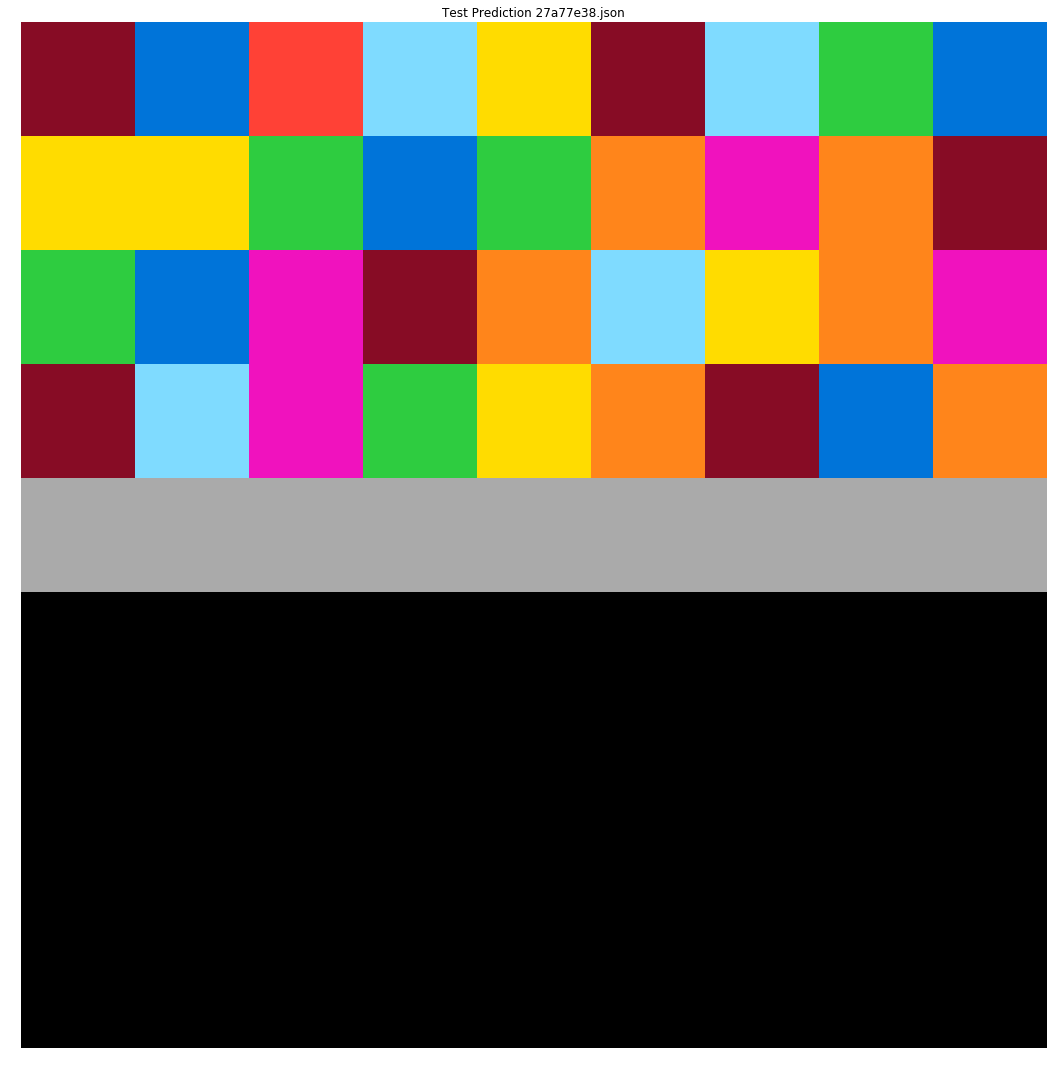

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/27f8ce4f.json

Number of input rows: 4 cols: 19
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/281123b4.json

Made predictions for  292dd178


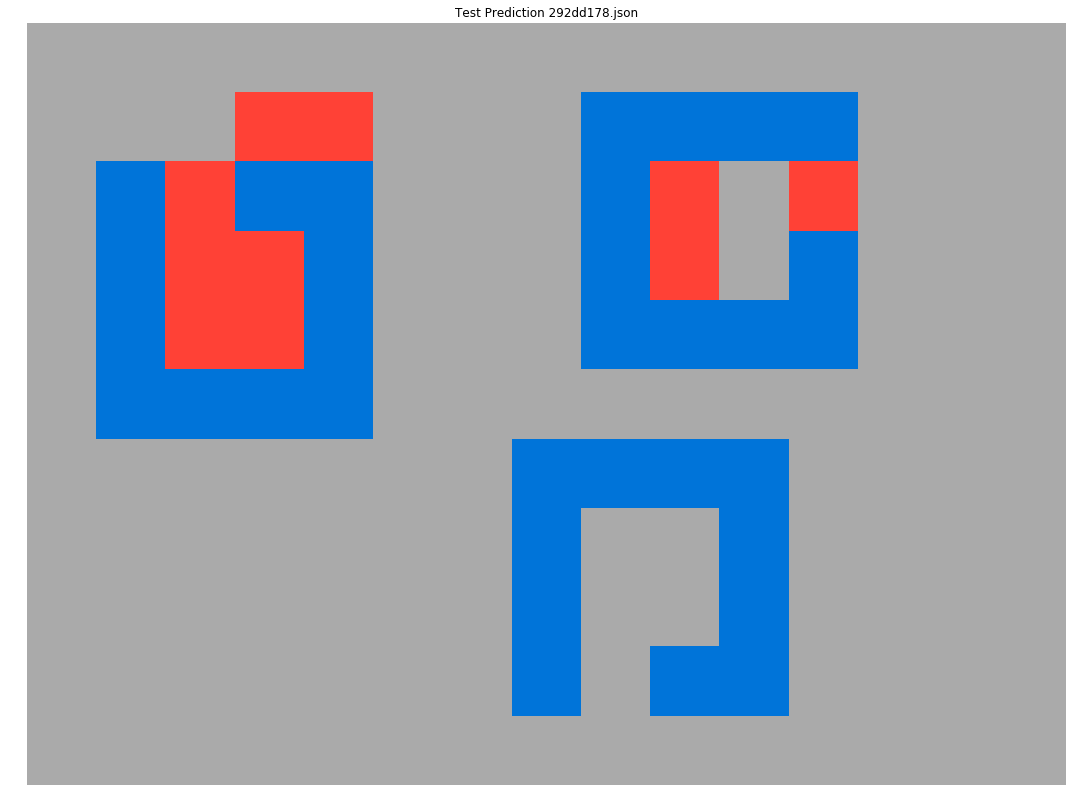

Made predictions for  29700607


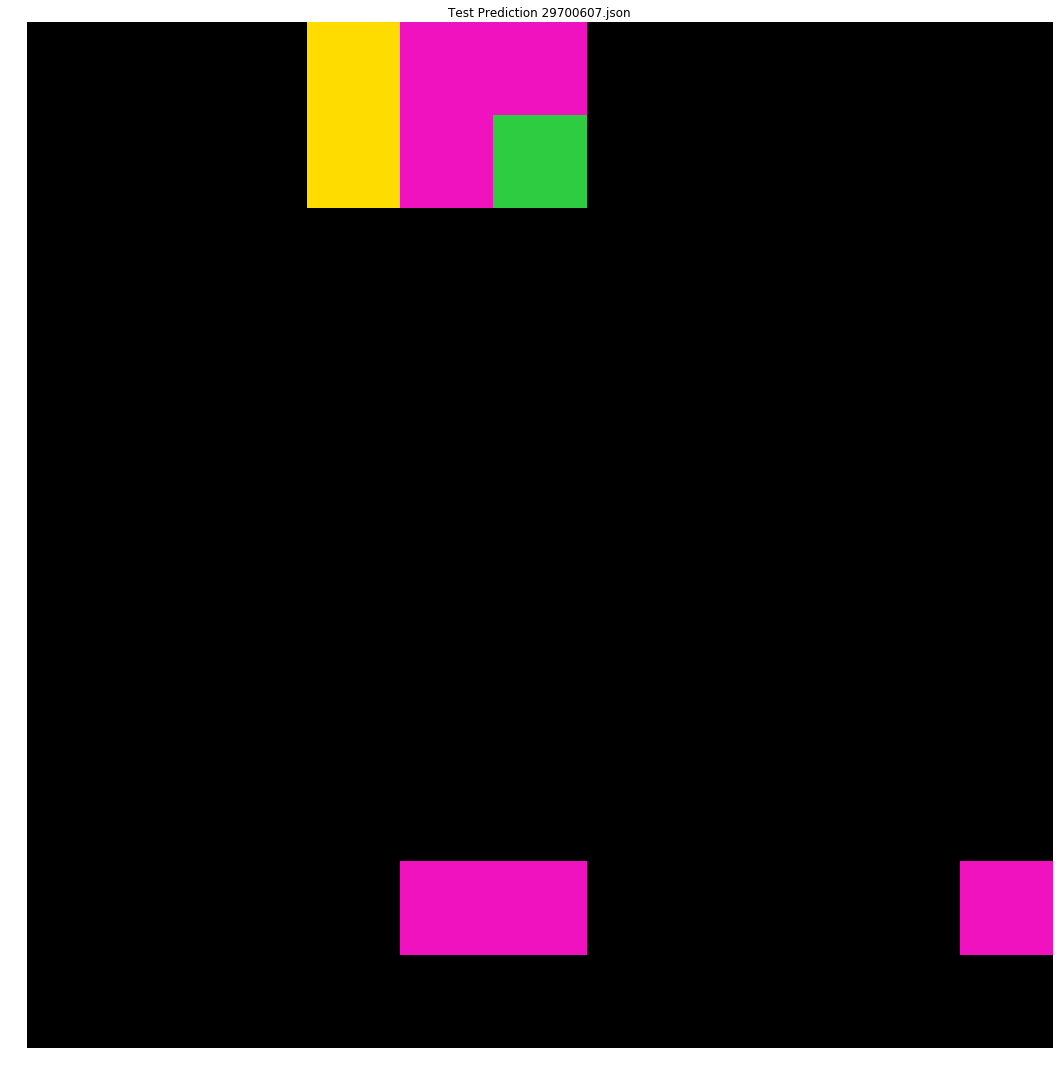

Made predictions for  2a5f8217


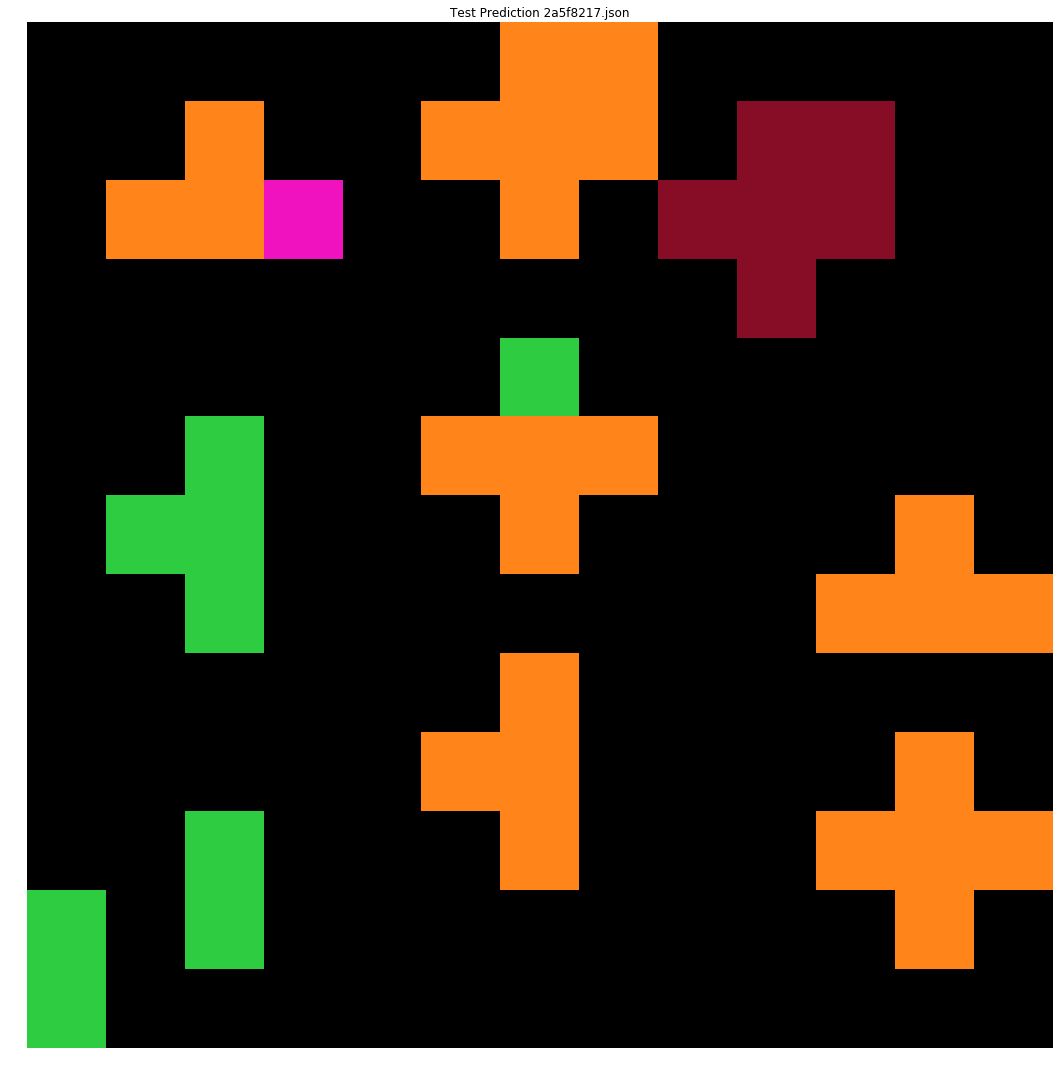

Made predictions for  2b01abd0


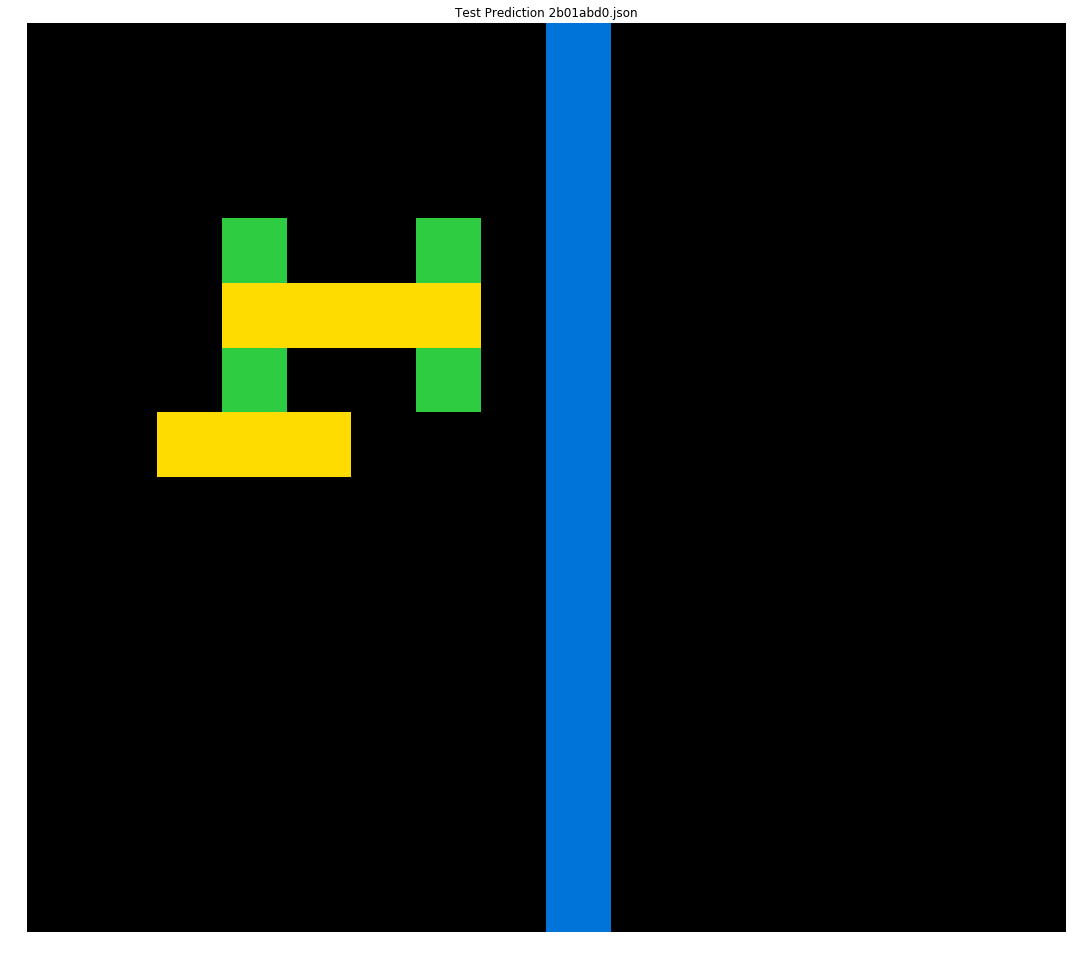

Number of input rows: 23 cols: 23
Number of target rows: 7 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2c0b0aff.json

Made predictions for  2c737e39


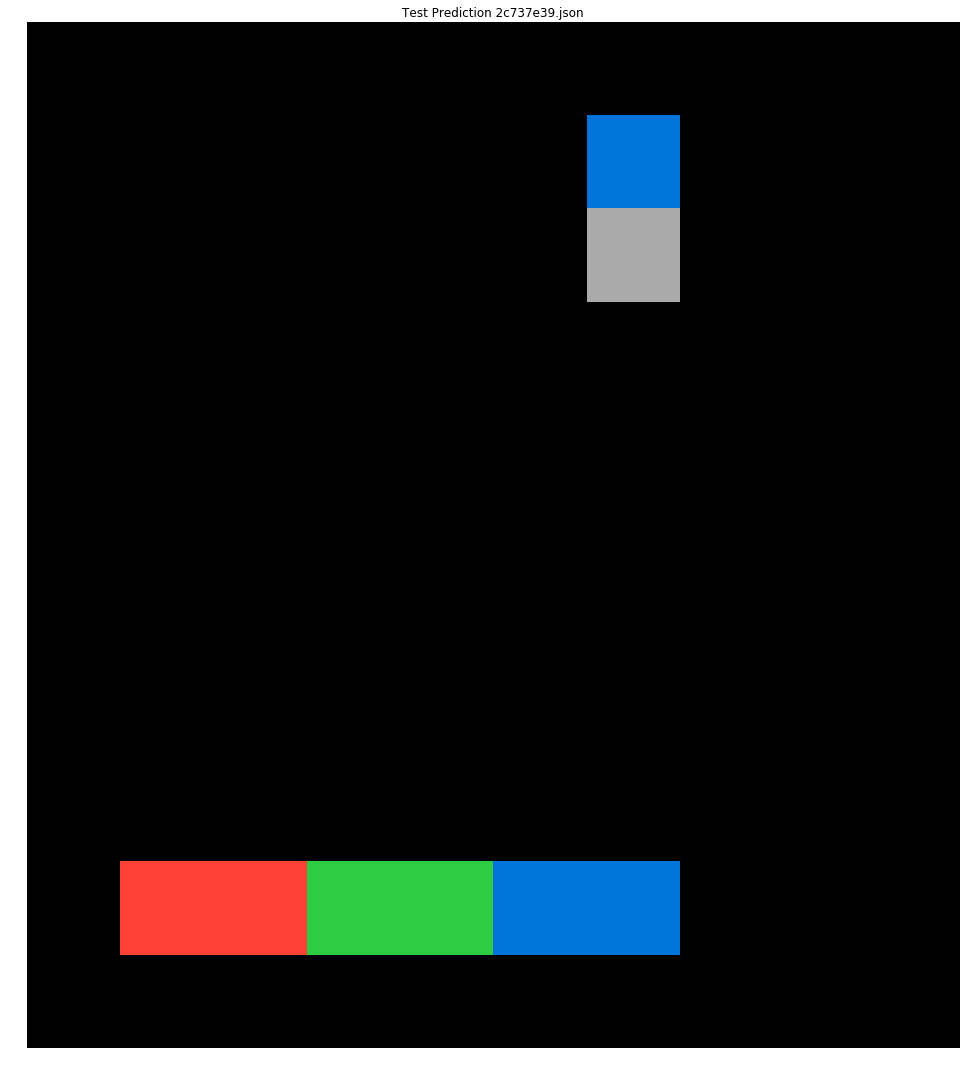

Number of input rows: 20 cols: 23
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2f0c5170.json

Number of input rows: 2 cols: 2
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/310f3251.json

Number of input rows: 20 cols: 20
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3194b014.json

Made predictions for  319f2597


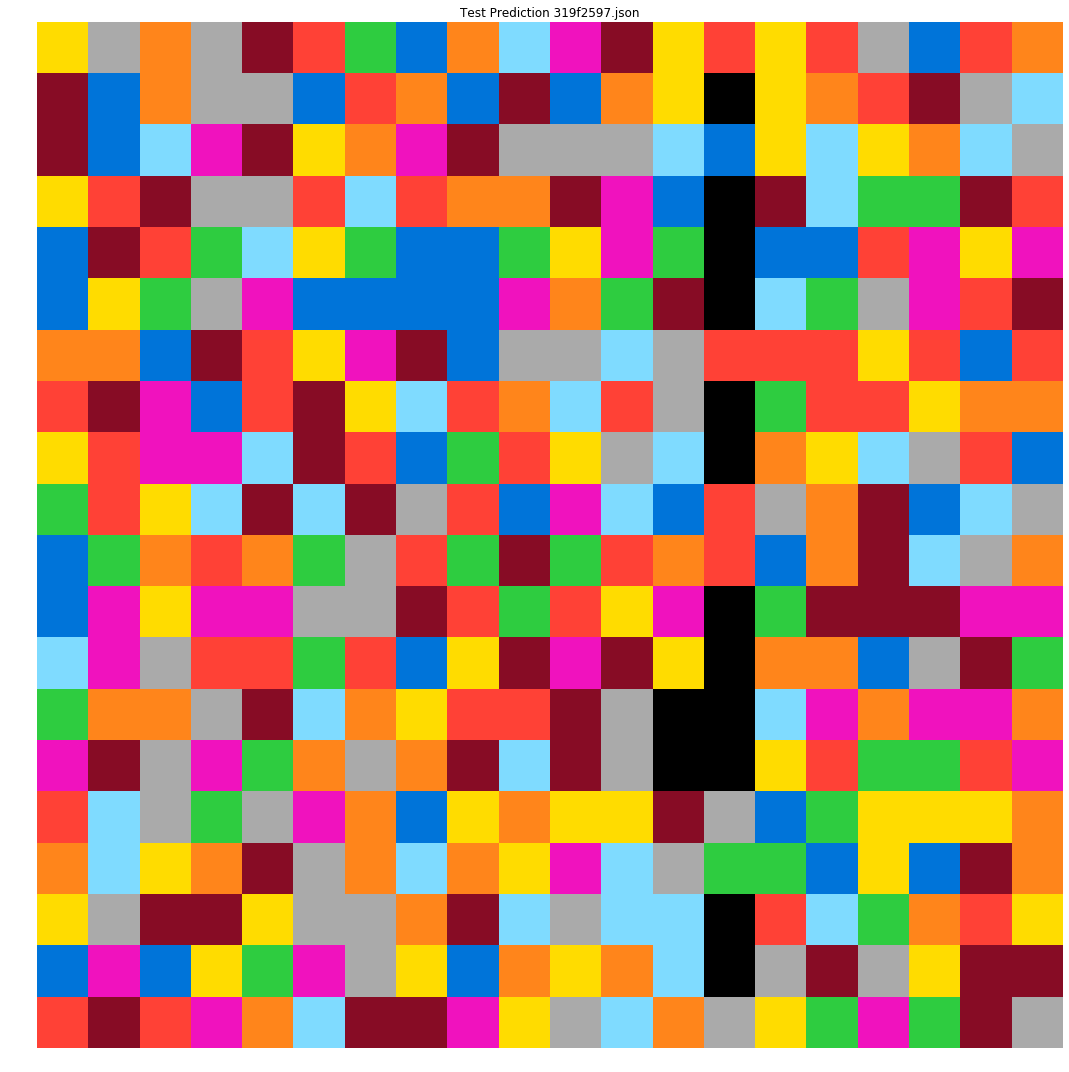

Made predictions for  31adaf00


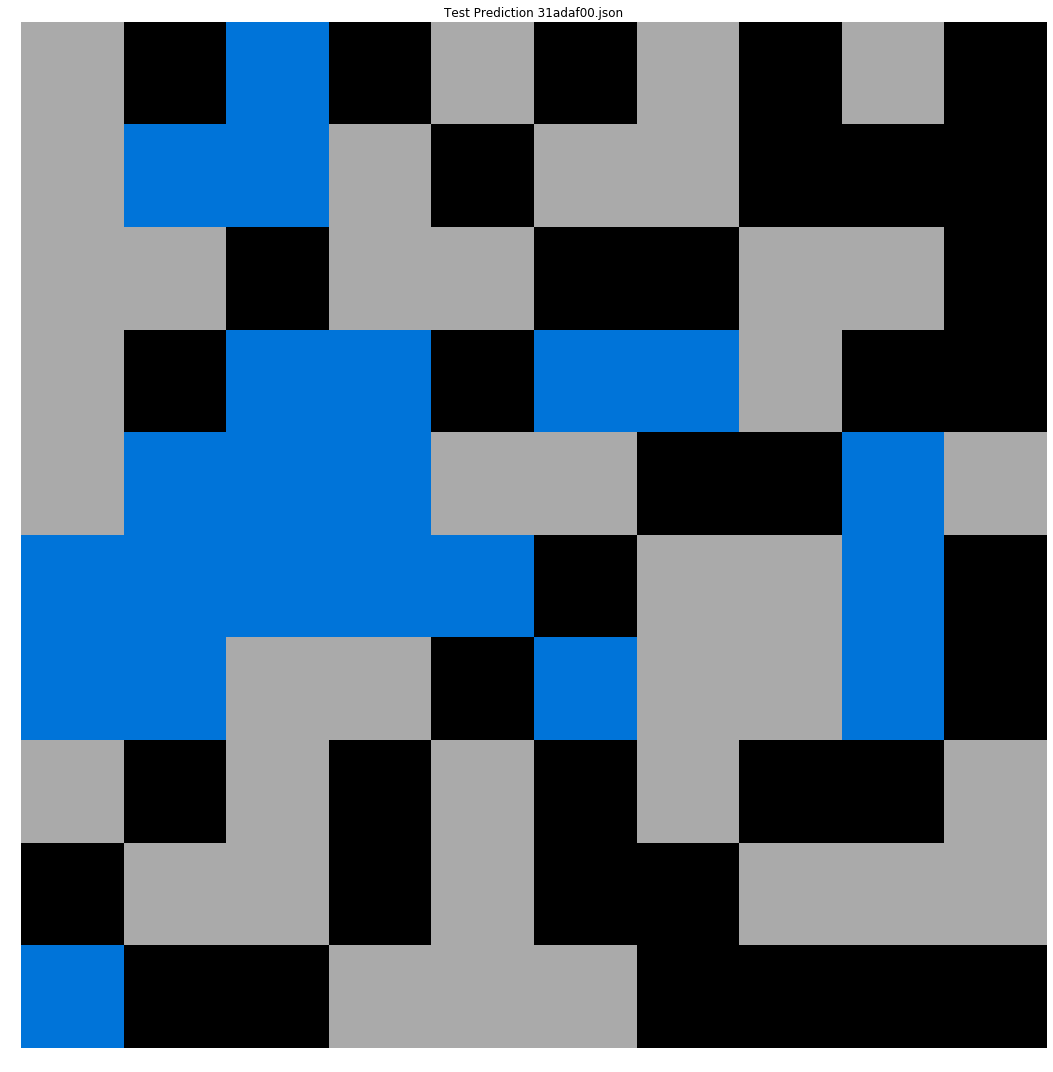

Number of input rows: 6 cols: 5
Number of target rows: 3 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/31d5ba1a.json

Made predictions for  32e9702f


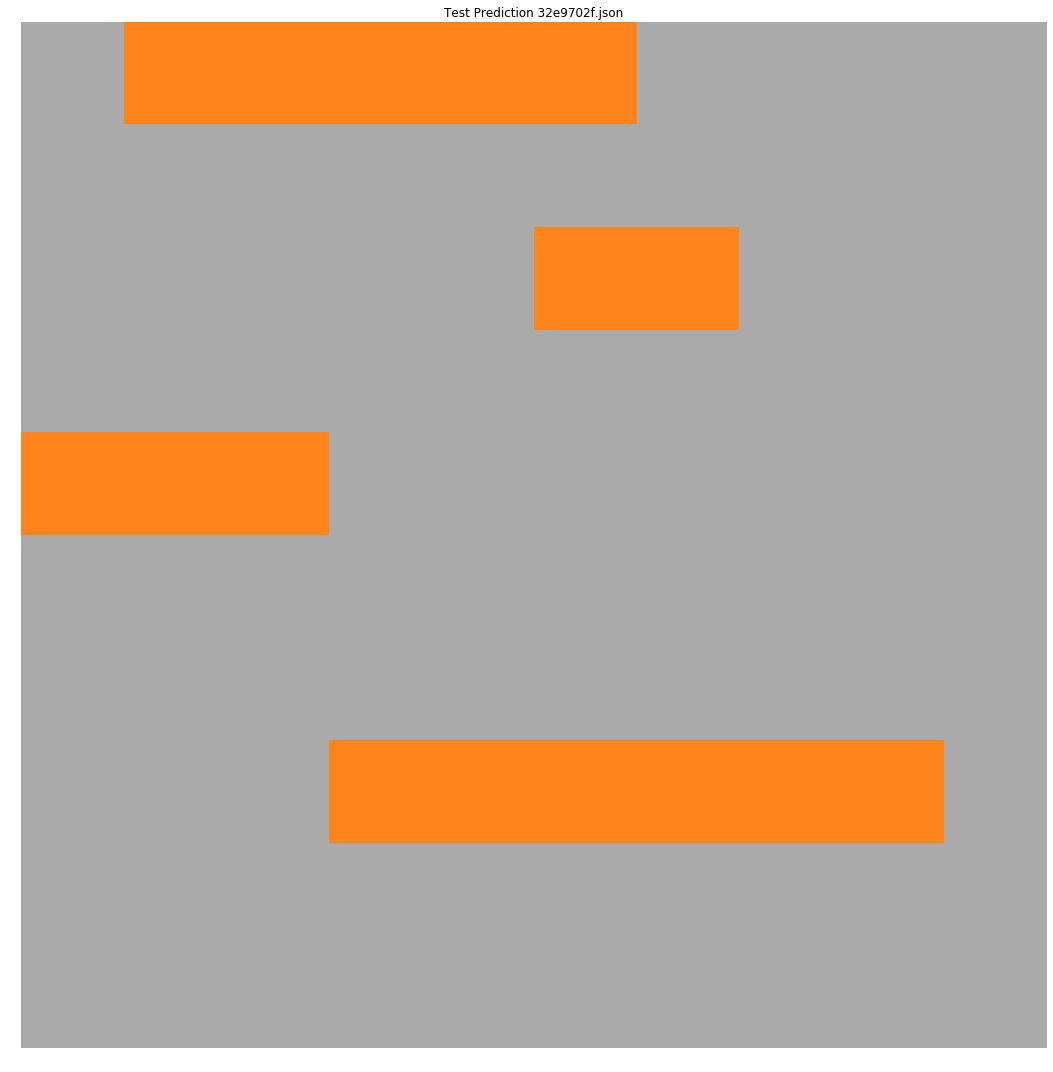

Made predictions for  332efdb3


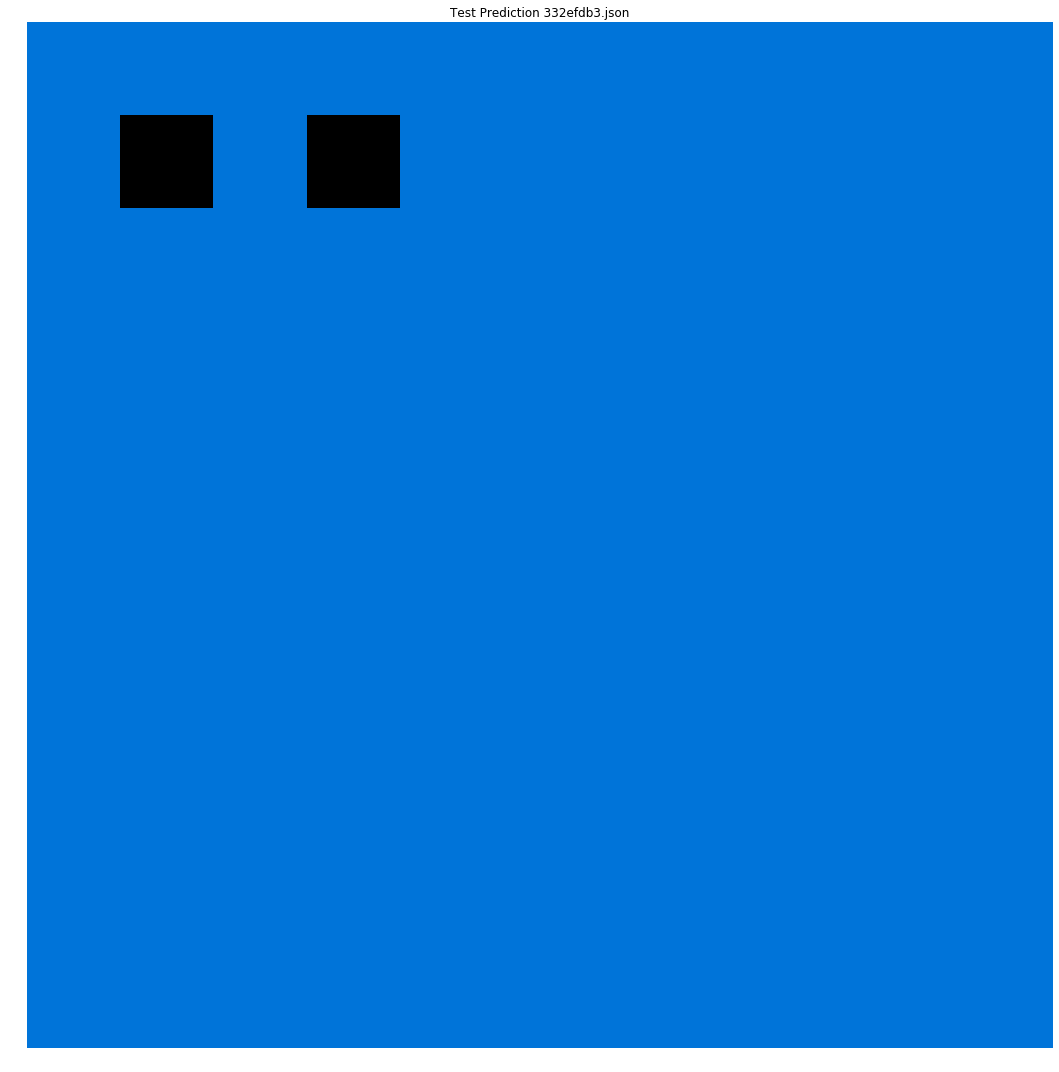

Made predictions for  3391f8c0


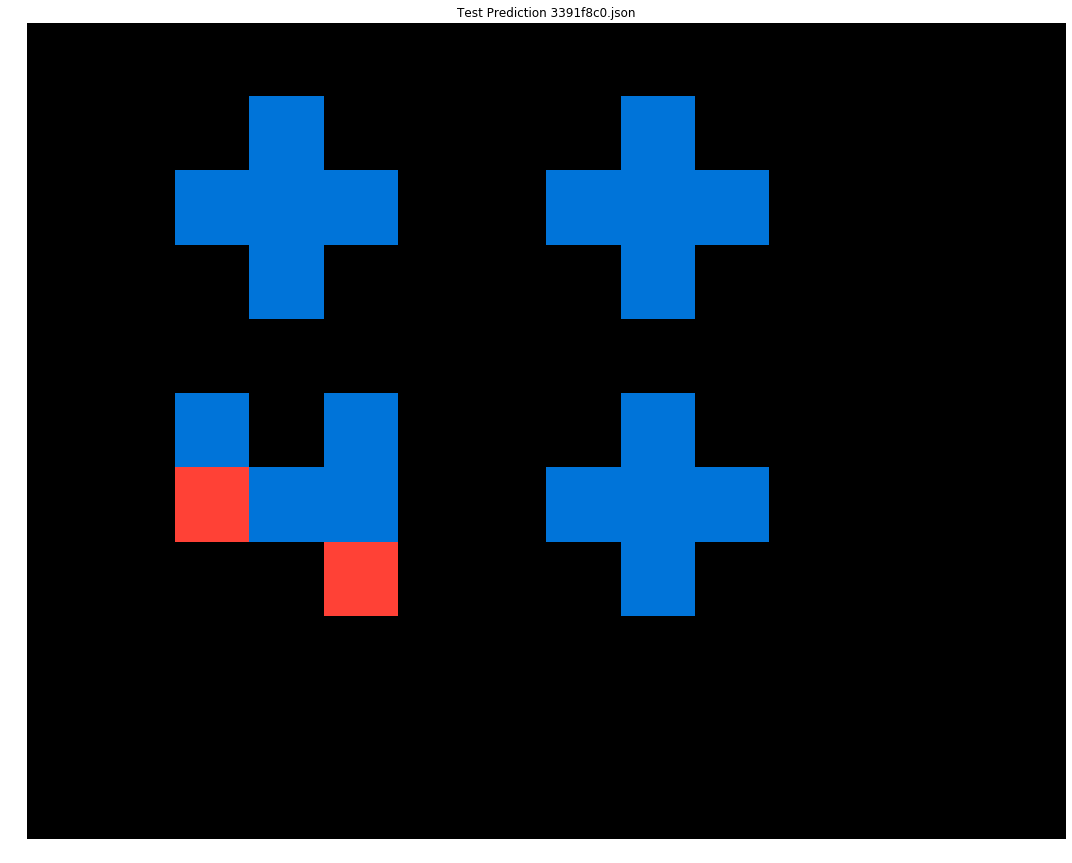

Made predictions for  33b52de3


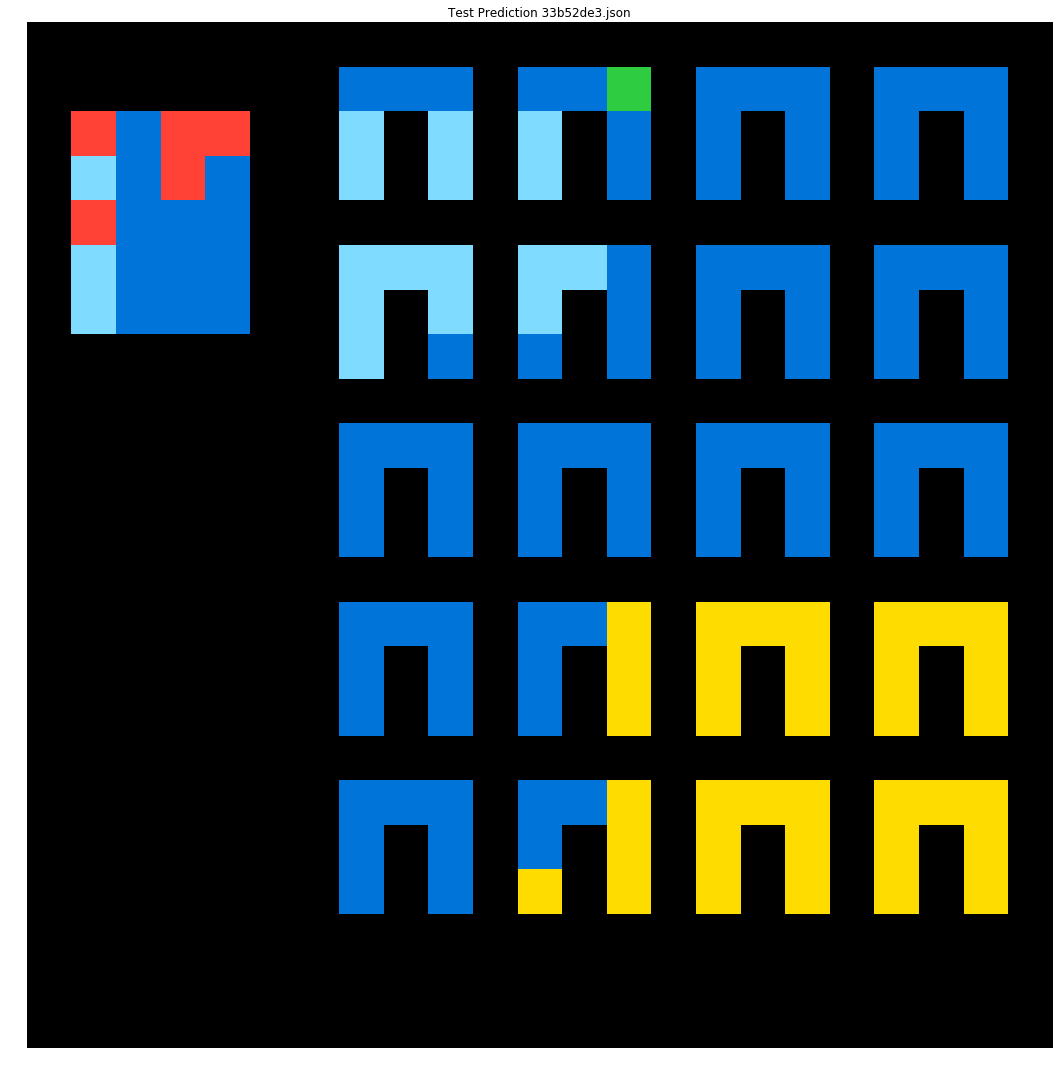

Made predictions for  3490cc26


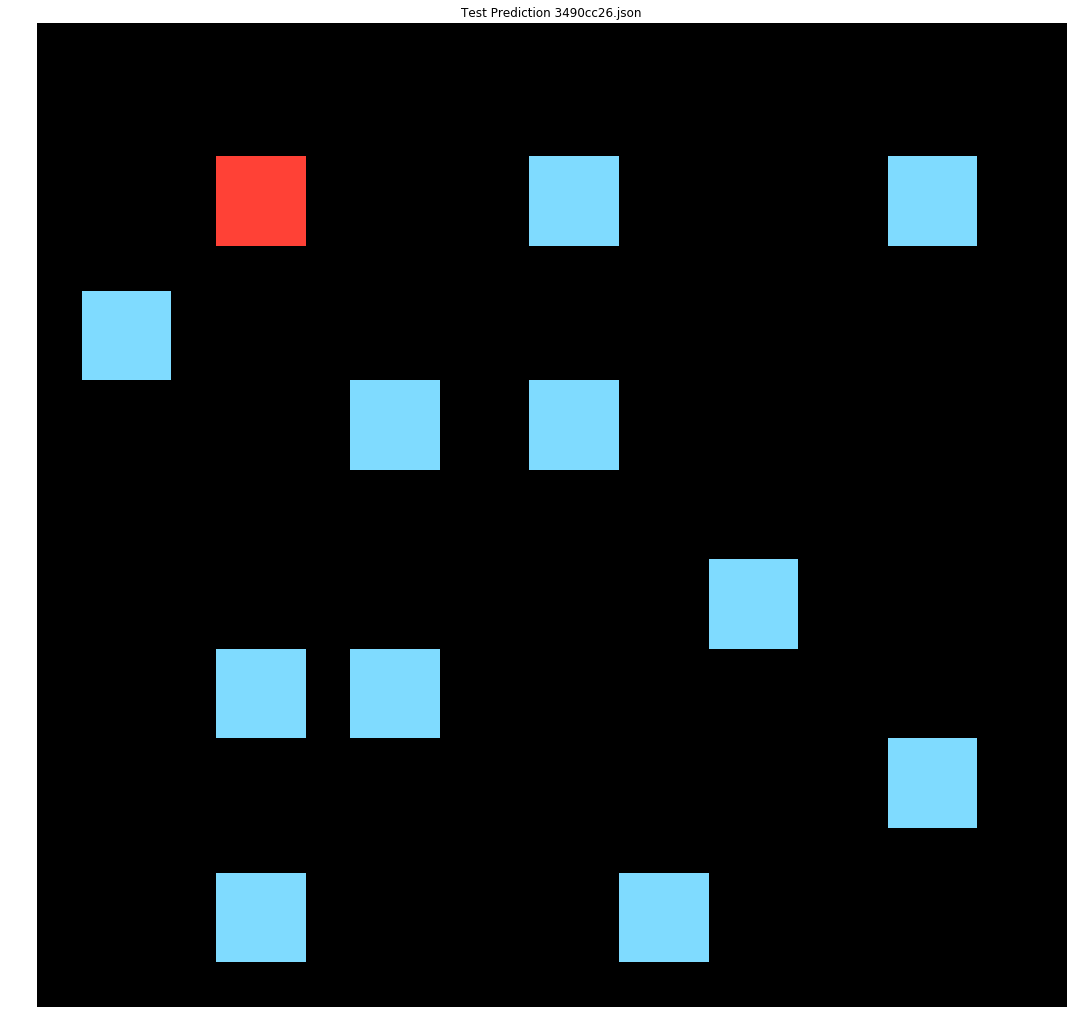

Number of input rows: 5 cols: 9
Number of target rows: 5 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/34b99a2b.json

Number of input rows: 15 cols: 13
Number of target rows: 3 cols: 13
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/351d6448.json

Number of input rows: 14 cols: 18
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/358ba94e.json

Made predictions for  37d3e8b2


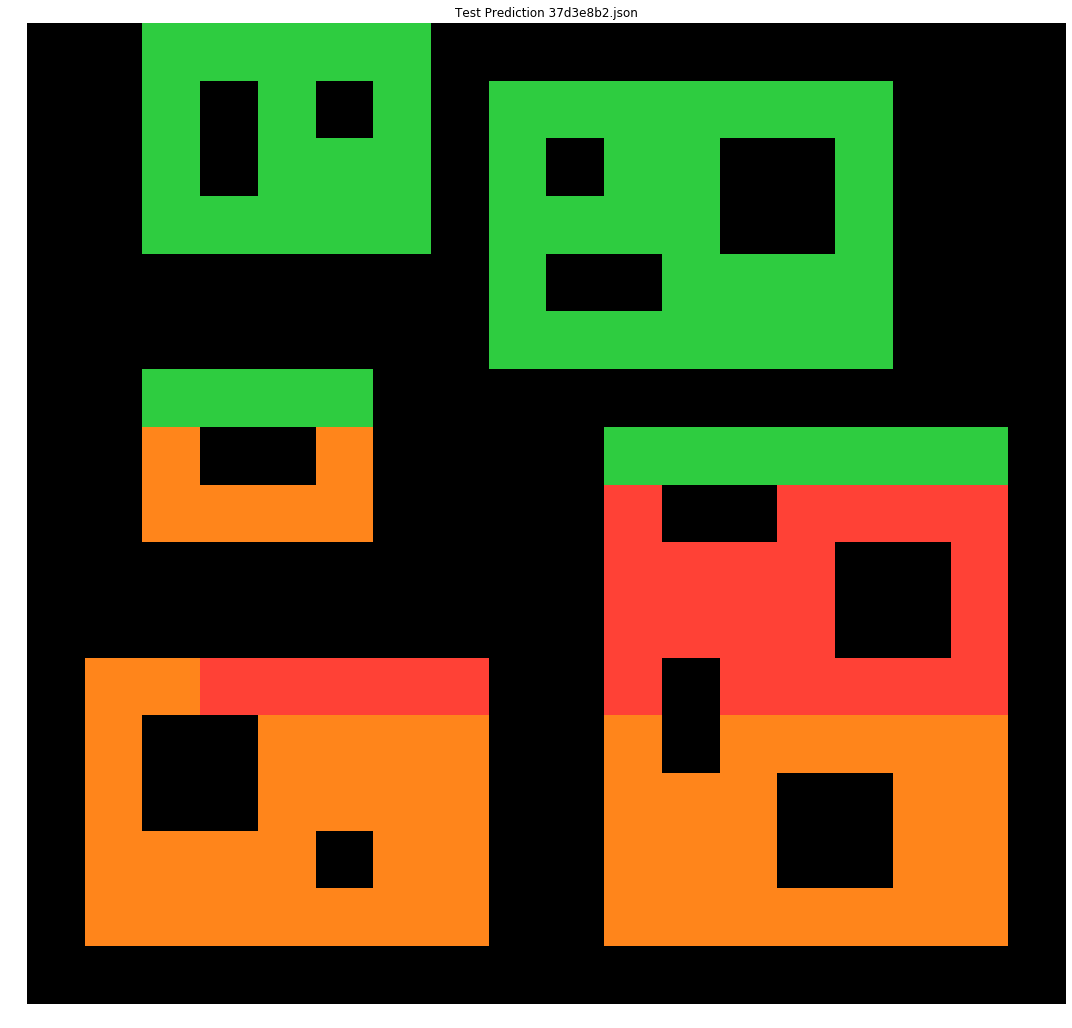

Number of input rows: 5 cols: 5
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3979b1a8.json

Made predictions for  3a301edc


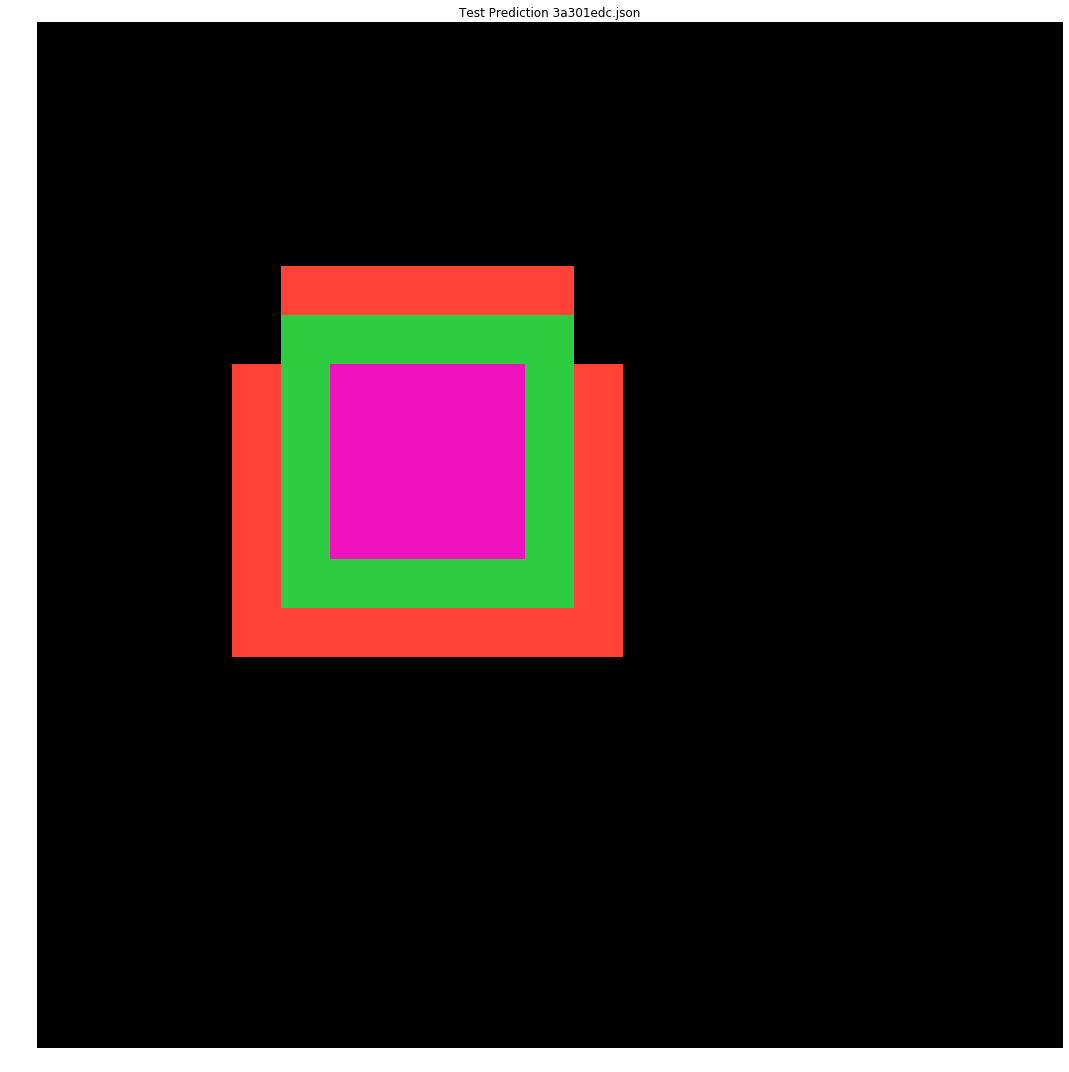

Number of input rows: 7 cols: 7
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3b4c2228.json

Number of input rows: 12 cols: 6
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3d31c5b3.json

Made predictions for  3ed85e70


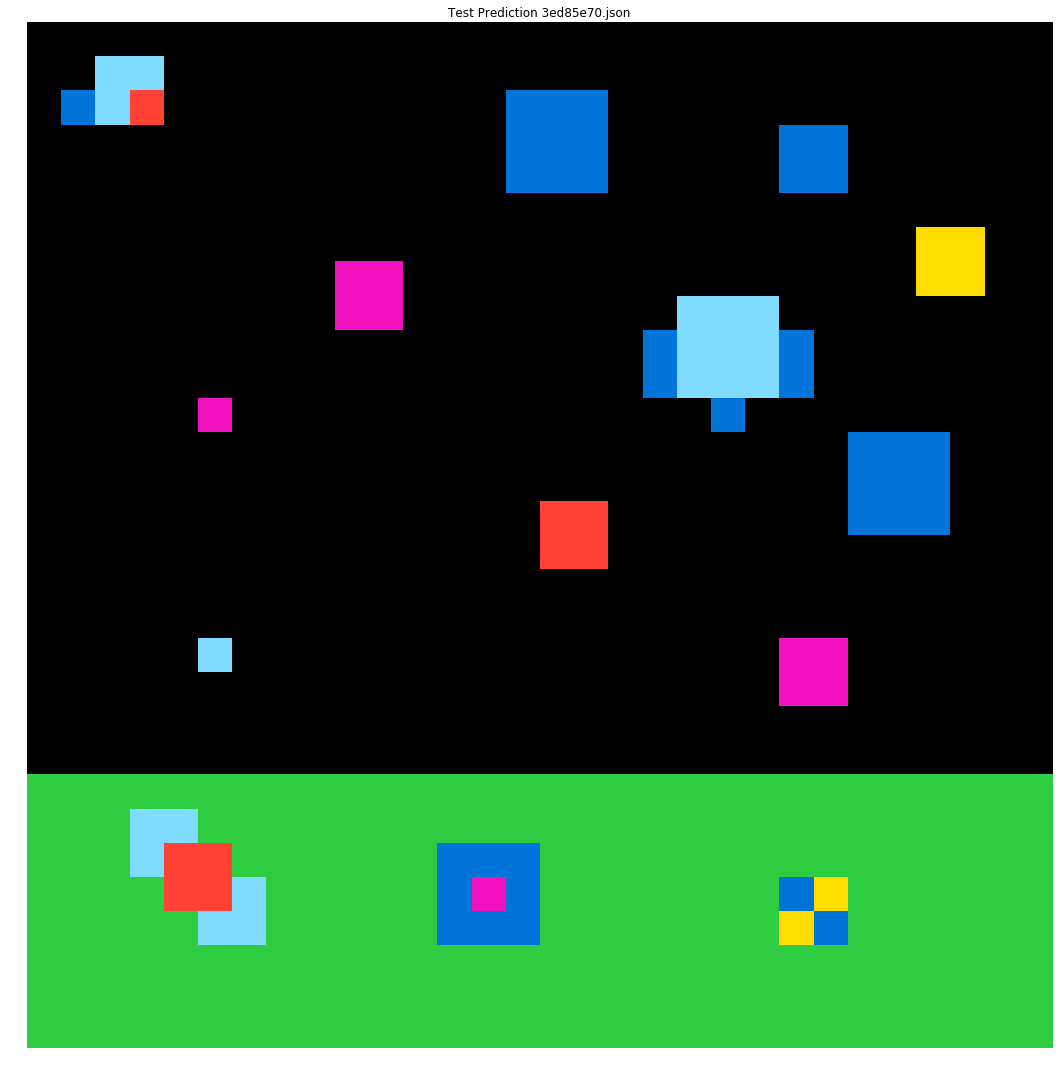

Number of input rows: 23 cols: 29
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3ee1011a.json

Made predictions for  3f23242b


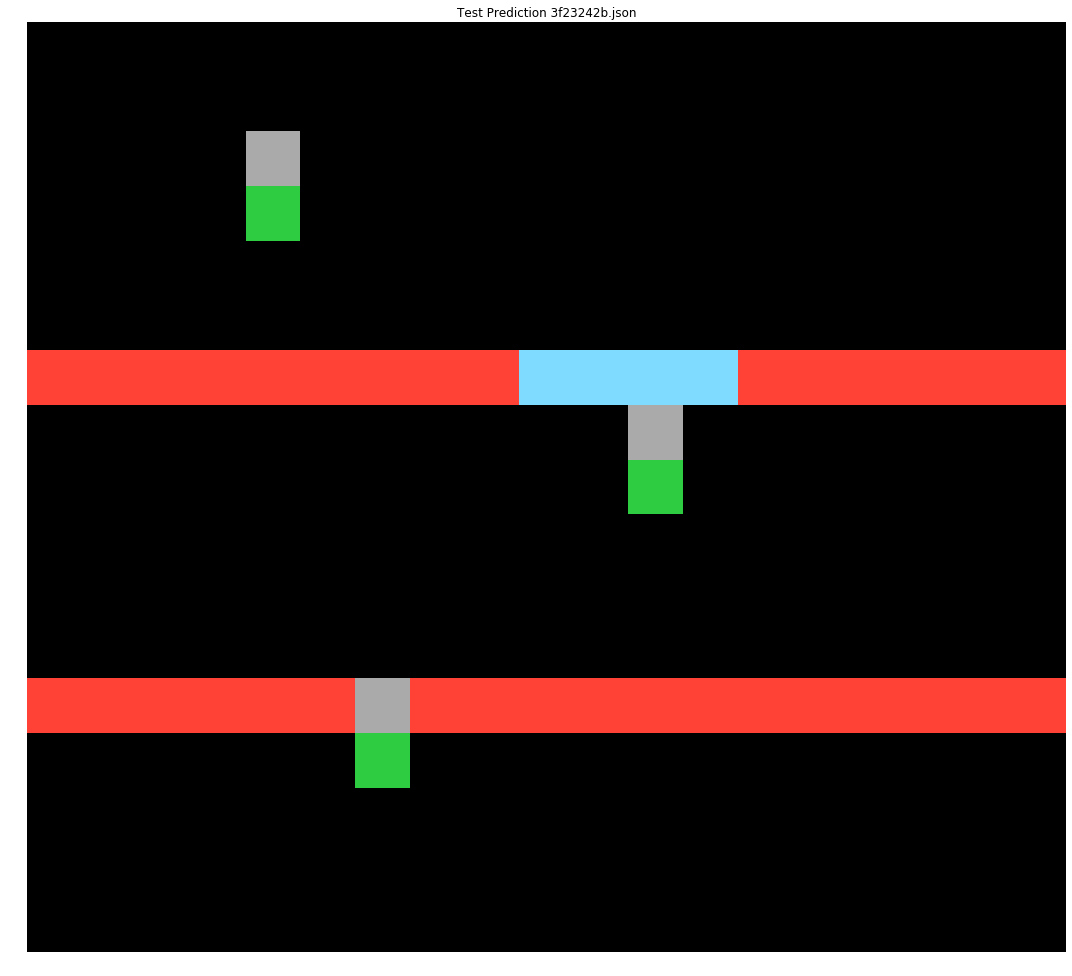

Made predictions for  40f6cd08


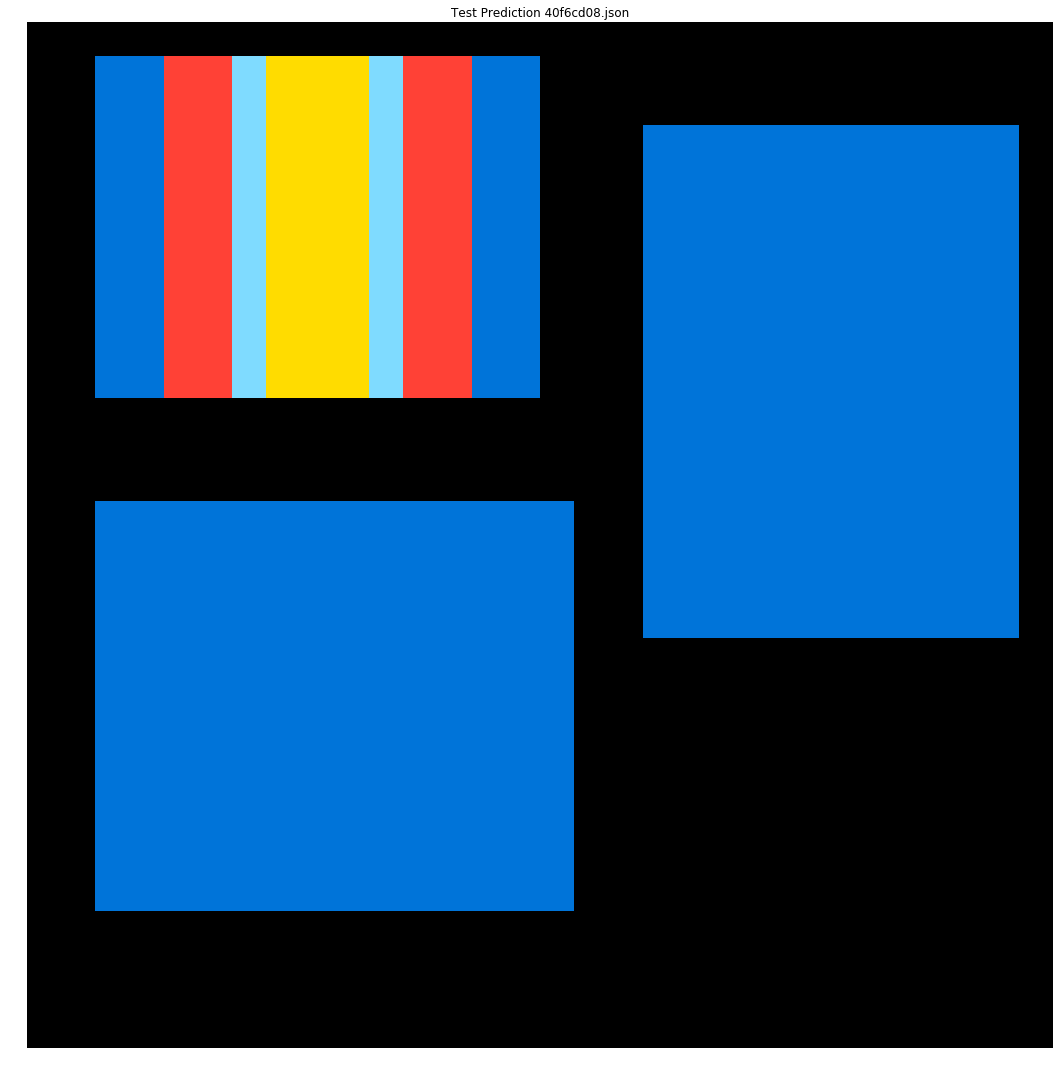

Number of input rows: 18 cols: 22
Number of target rows: 12 cols: 11
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/414297c0.json

Made predictions for  423a55dc


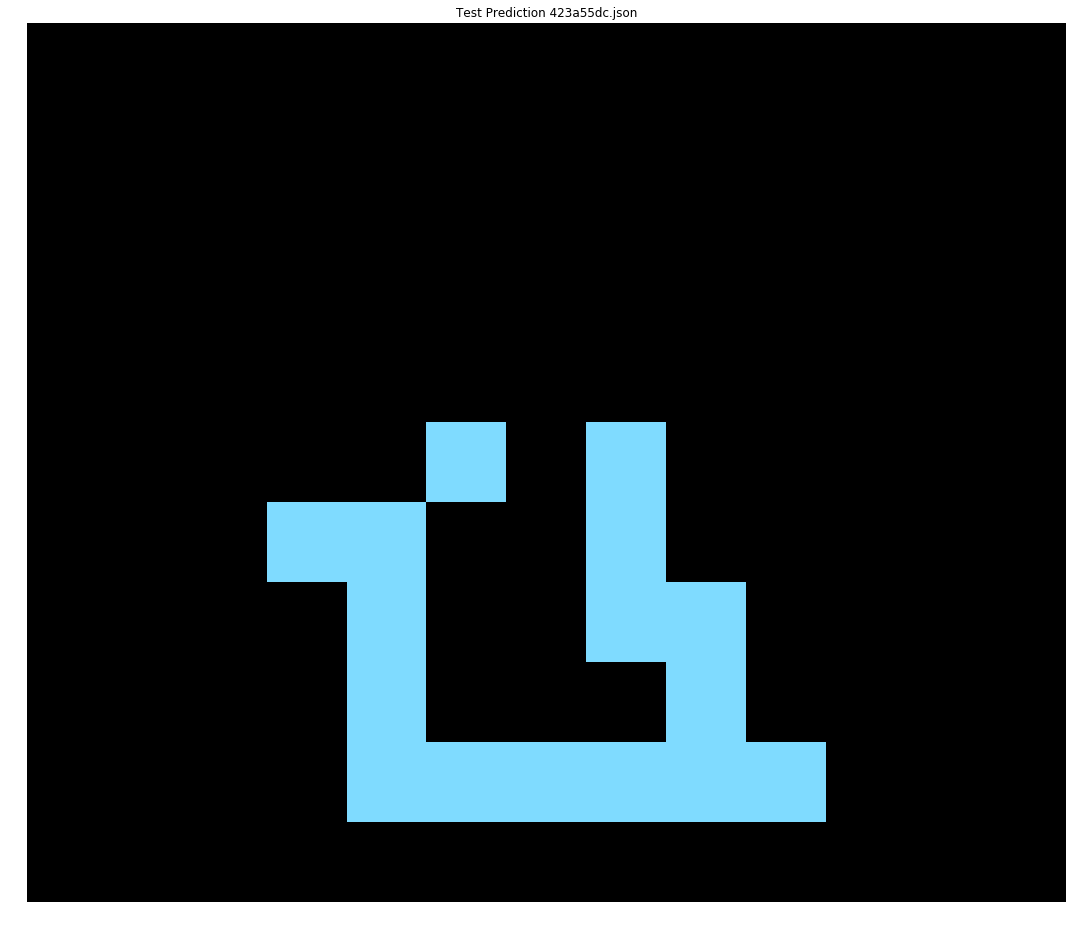

In [9]:
# mode = 'eval'
mode = 'test'
if mode=='eval':
    task_path = evaluation_path
elif mode=='train':
    task_path = training_path
elif mode=='test':
    task_path = test_path

all_task_ids = sorted(os.listdir(task_path))

nfeat = 13
local_neighb = 5
valid_scores = {}

model_accuracies = {'ens': []}
pred_taskids = []

for task_id in all_task_ids:

    task_file = str(task_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    xgb =  XGBClassifier(n_estimators=25, n_jobs=-1)
    xgb.fit(feat, target, verbose=-1)


#     training on input pairs is done.
#     test predictions begins here

    num_test_pairs = len(task['test'])
    for task_num in range(num_test_pairs):
        cur_idx = 0
        input_color = np.array(task['test'][task_num]['input'])
        nrows, ncols = len(task['test'][task_num]['input']), len(
            task['test'][task_num]['input'][0])
        feat = make_features(input_color, nfeat)

        print('Made predictions for ', task_id[:-5])

        preds = xgb.predict(feat).reshape(nrows,ncols)
        
        if (mode=='train') or (mode=='eval'):
            ens_acc = (np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols)

            model_accuracies['ens'].append(ens_acc)

            pred_taskids.append(f'{task_id[:-5]}_{task_num}')

            print('ensemble accuracy',(np.array(task['test'][task_num]['output'])==preds).sum()/(nrows*ncols))
            print()

        preds = preds.astype(int).tolist()
        plot_test(preds, task_id)
        sample_sub.loc[f'{task_id[:-5]}_{task_num}',
                       'output'] = flattener(preds)


In [10]:
if (mode=='train') or (mode=='eval'):
    df = pd.DataFrame(model_accuracies, index=pred_taskids)
    print(df.head(10))

    print(df.describe())
    for c in df.columns:
        print(f'for {c} no. of complete tasks is', (df.loc[:, c]==1).sum())

    df.to_csv('ens_acc.csv')


In [11]:
sample_sub.head()

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000222222277|00000200020207|...
00dbd492_0,|00000000000222220000|02222222223233323000|028...
03560426_0,|4140000000|1000000000|8000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00004444488888...


In [12]:
sample_sub.to_csv('submission.csv')